In [1]:
import numpy as np
from numpy import linalg as LA
import scipy
import itertools as it

In [2]:
counter = {
    'function_eval':0,
    'derivative_eval':0,
    'hessian_eval':0
}

def total_effort(number_of_func_param):
    n = number_of_func_param
    return counter['function_eval']+(counter['derivative_eval']*n)+(counter['hessian_eval']* n**2)

def count_fnc_call_decorator(fnc):
    def count_wrapper(*args, **kwargs):
        global counter
        fnc(*args,**kwargs)
        counter['function_eval'] += 1
        return fnc(*args,**kwargs)
    return count_wrapper

def reset_function_counter():
    global counter
    counter['function_eval']=0
    counter['derivative_eval']=0
    counter['hessian_eval']=0

In [3]:
def ek(k,dim):
    ek = np.zeros(dim)
    ek[k]=1
    return ek

In [4]:
def grad_neumeric(f,values,h=0.00001):
    dim = len(values)
    derviative = lambda val,pos: (f(*(val+h*pos))-f(*val))/h
    return np.array([derviative(values,ek(i,dim))  for i in range(dim)])

In [5]:
test_f = lambda x,y,z: x**2+y**2+z**2
test_val = np.array([1,2,3])
grad_approx = grad_neumeric(test_f,test_val)
grad_approx

array([2.00001, 4.00001, 6.00001])

In [6]:
def hassian_neumeric(f,values,h=0.00001):
    der_hessian_at_val = []
    der_hessian = lambda vec, eki,ekj: (f(*(vec+h*ekj+h*eki))-f(*(vec+h*ekj))-f(*(vec+h*eki))+f(*vec))/h**2 
    dim = len(values)
    for i in range(dim):
       for j in range(dim):
           val = (der_hessian(values,ek(i,dim),ek(j,dim)))
           der_hessian_at_val.append(val)
    der_hessian_at_val = np.array(der_hessian_at_val).reshape(dim,dim)
    return der_hessian_at_val

In [7]:
test_hf = lambda x,y: x**2+y**2
test_hval = np.array([1,2])
print(grad_neumeric(test_hf,test_hval))
print(hassian_neumeric(test_hf,test_hval))

[2.00001 4.00001]
[[2.00000017 0.        ]
 [0.         2.00000017]]


In [8]:
def gradient_at_val(f,gradient_f,values):
    global counter
    counter['derivative_eval'] += 1
    
    grad = []
    if gradient_f is None:
        return np.array(grad_neumeric(f,values))
    for function in gradient_f:
        gradient = function(*values)
        grad.append(gradient)
    
    
    return np.array(grad)

In [9]:
def hassian_at_val(f,gradient2d_f,values):
    global counter
    counter['hessian_eval'] += 1
    
    hassian = []
    if gradient2d_f is None:
        return hassian_neumeric(f,values)
    for gradient_f in gradient2d_f:
        grad = gradient_at_val(f,gradient_f,values)
        hassian.append(grad)
    return np.array(hassian)

In [10]:
def inverse_update_BFGS(Hk1,Hk,f,gradient_f,xk1,xk):
    grad_at_xk1 = gradient_at_val(f,gradient_f,xk1)
    grad_at_xk = gradient_at_val(f,gradient_f,xk)
    yk = grad_at_xk1 - grad_at_xk
    sk = xk1-xk
    
    Hk1 = LA.inv(Hk1)
    Hk = LA.inv(Hk)
    
    common_denominator = np.outer(yk.T,sk)
    term1 = (np.outer((sk-np.dot(Hk,yk)),sk.T) + np.outer(sk, (sk-np.dot(Hk,yk)).T)) / common_denominator
    term2 = np.dot(np.outer((sk-np.dot(Hk1,yk)).T,yk),np.outer(sk,sk.T))/common_denominator**2

    Uk = term1 - term2

    Hk1 = Hk+ Uk
    return Hk1

In [11]:
def gradient_direction(function,gradient_f,gradient2d_f,values,Hk=None,direction_method='newton'):
    dk = []
    grad = gradient_at_val(function,gradient_f,values)
    if direction_method == 'newton':
        dk = - np.dot(LA.inv(hassian_at_val(function,gradient2d_f,values)), grad)
        if - np.dot(grad.T,dk)/(LA.norm(grad)*LA.norm(dk)) < 0.1:
            dk = - grad
    elif direction_method == 'quasi-newton':
#         dk = np.dot(-Hk,grad)
        dk = - np.dot(LA.inv(Hk),grad)
        if - np.dot(grad.T,dk)/(LA.norm(grad)*LA.norm(dk)) < 0.1:
            dk = - grad
    else:
        dk = - grad
    return dk
        

In [12]:
def descent_direction(f,gradient_f,values):
    grad = gradient_at_val(f,gradient_f,values)
    p =  - (LA.norm(grad))**2
    return p

In [13]:
def armijo_step_algorithm(f,gradient_f,dk,values,delta):
    ro = 1
    grad_at_values = gradient_at_val(f,gradient_f,values).T
    while f(*(values+ro*dk)) <= f(*values)+ro*delta*np.dot(grad_at_values,dk):
        ro *= 2
    
    while f(*(values+ro*dk)) > f(*values)+ro*delta*np.dot(grad_at_values,dk):
        ro /= 2
    return ro

In [14]:
# Bazaray shetty function
# f = lambda x,y: (x-2)**4 + (x-2*y)**2
# f = count_fnc_call_decorator(f)
# dfx = lambda x,y: 4*(x-2)**3+2*(x-2*y)
# dfy = lambda x,y: -4*(x-2*y)

# dfx11 = lambda x,y: 12*(x-2)**2+2
# dfx12 = lambda x,y: -4

# dfx21 = lambda x,y: -4
# dfx22 = lambda x,y: 8

In [15]:
# rosenbrook function
f = lambda x,y : 100*(y-x*x)**2 + (1-x)**2
f = count_fnc_call_decorator(f)
dfx = lambda x,y: -400*x*(y-x*x) + 2*x - 2
dfy = lambda x,y: 200*(y-x*x)

dfx11 = lambda x,y: -400*(y-3*x**2)+2
dfx12 = lambda x,y: -400*x

dfx21 = lambda x,y: -400*x
dfx22 = lambda x,y: 200

In [16]:
print(f'dfx numeric: {grad_neumeric(f,[1,2])} ')
print(f'dfx: {dfx(1,2)}  dfy:{dfy(1,2)}')

dfx numeric: [-399.99798996  200.001     ] 
dfx: -400  dfy:200


In [17]:
print(f'dfx numeric: {hassian_neumeric(f,[1,2])} ')
print(f'dfx11: {dfx11(1,2)}  dfx12:{dfx12(1,2)} dfx21:{dfx21(1,2)} dfx22:{dfx22(1,2)}')

dfx numeric: [[ 402.02365881 -400.00216472]
 [-400.00216472  199.99987444]] 
dfx11: 402  dfx12:-400 dfx21:-400 dfx22:200


In [18]:
from numpy import linalg as LA
def general_descent(iteration,function,gradient_f,gradient2d_f,initial,direction_method='newton'):
    Hk = None
    Hk1 = None
    xk = initial
    counter = 0
    xk1 = 0
    delta = 10**(-3)

    if direction_method == 'quasi-newton':
        Hk = hassian_at_val(function,gradient2d_f,initial)
        Hk1 = Hk

    while counter <=iteration:
        dk = gradient_direction(function,gradient_f,gradient2d_f,xk,Hk,direction_method=direction_method)
        step_size = armijo_step_algorithm(function,gradient_f,dk,xk,delta)
        xk1 = xk + step_size*dk
       
        if direction_method == 'quasi-newton':
            Hk1 = inverse_update_BFGS(Hk1,Hk,function,gradient_f,xk1,xk)
            Hk=Hk1
        
        xk = xk1
        print('xk1 at iterate: {}--->: {}'.format(counter,xk1))
        print('dk at iterate: {}--->: {}'.format(counter,dk))
        print('step_size at iterate: {}--->: {}'.format(counter,step_size))
        counter += 1
        if LA.norm(gradient_at_val(function,gradient_f,xk))<=0.01:
            break
    return xk1

In [19]:
general_descent(10000,f,np.array([dfx,dfy]),np.array([[dfx11,dfx12],[dfx21,dfx22]]),np.array([0,10]),direction_method='newton')

xk1 at iterate: 0--->: [-0.00050025  0.        ]
dk at iterate: 0--->: [-5.00250125e-04 -1.00000000e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 0.24961229 -0.00025018]
dk at iterate: 1--->: [ 1.00045018 -0.0010007 ]
step_size at iterate: 1--->: 0.25
xk1 at iterate: 2--->: [0.36068791 0.18031445]
dk at iterate: 2--->: [0.05553781 0.09028231]
step_size at iterate: 2--->: 2.0
xk1 at iterate: 3--->: [0.28999676 0.07910088]
dk at iterate: 3--->: [-0.07069115 -0.10121357]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [0.4675466  0.18457726]
dk at iterate: 4--->: [0.35509967 0.21095275]
step_size at iterate: 4--->: 0.5
xk1 at iterate: 5--->: [1.01333688 0.96712255]
dk at iterate: 5--->: [0.06822378 0.09781816]
step_size at iterate: 5--->: 8.0
xk1 at iterate: 6--->: [1.01230667 1.02476374]
dk at iterate: 6--->: [-0.00103021  0.05764119]
step_size at iterate: 6--->: 1.0
xk1 at iterate: 7--->: [1.00000261 0.99985383]
dk at iterate: 7--->: [-0.01230406 -0.0249099 ]
st

array([1.00000008, 1.00000015])

In [20]:
print(f'function call for newton with derivative and hessian functions{counter}')
print(total_effort(2))
reset_function_counter()

function call for newton with derivative and hessian functions{'function_eval': 98, 'derivative_eval': 45, 'hessian_eval': 9}
224


In [21]:
general_descent(20000,f,None,None,np.array([0,10]),direction_method='newton')

xk1 at iterate: 0--->: [-0.00050525 -0.00011075]
dk at iterate: 0--->: [-5.05251010e-04 -1.00001108e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 0.2441883  -0.00032907]
dk at iterate: 1--->: [ 9.78774212e-01 -8.73253118e-04]
step_size at iterate: 1--->: 0.25
xk1 at iterate: 2--->: [0.36046982 0.17636526]
dk at iterate: 2--->: [0.05814076 0.08834716]
step_size at iterate: 2--->: 2.0
xk1 at iterate: 3--->: [0.28333041 0.07431986]
dk at iterate: 3--->: [-0.07713941 -0.1020454 ]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [0.44658878 0.16980925]
dk at iterate: 4--->: [0.32651673 0.19097877]
step_size at iterate: 4--->: 0.5
xk1 at iterate: 5--->: [0.76552571 0.57318891]
dk at iterate: 5--->: [0.07973423 0.10084492]
step_size at iterate: 5--->: 4.0
xk1 at iterate: 6--->: [0.89564018 0.79807355]
dk at iterate: 6--->: [0.06505724 0.11244232]
step_size at iterate: 6--->: 2.0
xk1 at iterate: 7--->: [0.89317424 0.7996723 ]
dk at iterate: 7--->: [-1.26256224  0.818556

array([0.99833482, 0.99666587])

In [22]:
print(f'function call for newton with neumerical approximation of derivative and hessian{counter}')
print(total_effort(2))
reset_function_counter()

function call for newton with neumerical approximation of derivative and hessian{'function_eval': 466, 'derivative_eval': 36, 'hessian_eval': 12}
586


In [23]:
general_descent(10000,f,np.array([dfx,dfy]),np.array([[dfx11,dfx12],[dfx21,dfx22]]),np.array([0,10]),direction_method='quasi-newton')

xk1 at iterate: 0--->: [-0.00050025  0.        ]
dk at iterate: 0--->: [-5.00250125e-04 -1.00000000e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [2.49624819e-01 6.25625469e-06]
dk at iterate: 1--->: [2.00100055e+00 5.00500375e-05]
step_size at iterate: 1--->: 0.125
xk1 at iterate: 2--->: [1.05573797e-01 4.98268125e-06]
dk at iterate: 2--->: [-3.60127554e-02 -3.18393360e-07]
step_size at iterate: 2--->: 4.0
xk1 at iterate: 3--->: [0.12617348 0.03482012]
dk at iterate: 3--->: [1.31837993 2.22816878]
step_size at iterate: 3--->: 0.015625
xk1 at iterate: 4--->: [0.14727929 0.00528829]
dk at iterate: 4--->: [ 2.70154334 -3.7800744 ]
step_size at iterate: 4--->: 0.0078125
xk1 at iterate: 5--->: [0.50887085 0.25763882]
dk at iterate: 5--->: [185.13487799 129.20347441]
step_size at iterate: 5--->: 0.001953125
xk1 at iterate: 6--->: [0.52004998 0.26173481]
dk at iterate: 6--->: [0.71546411 0.26214333]
step_size at iterate: 6--->: 0.015625
xk1 at iterate: 7--->: [0.51671621 0.268

step_size at iterate: 66--->: 0.001953125
xk1 at iterate: 67--->: [0.78841539 0.62103652]
dk at iterate: 67--->: [-2.72344549e-05  1.58803964e-05]
step_size at iterate: 67--->: 16.0
xk1 at iterate: 68--->: [0.792847   0.62470697]
dk at iterate: 68--->: [36.30373711 30.06836141]
step_size at iterate: 68--->: 0.0001220703125
xk1 at iterate: 69--->: [0.79106032 0.62613218]
dk at iterate: 69--->: [-0.0071467   0.00570084]
step_size at iterate: 69--->: 0.25
xk1 at iterate: 70--->: [0.79209635 0.62599322]
dk at iterate: 70--->: [ 0.53044514 -0.07114867]
step_size at iterate: 70--->: 0.001953125
xk1 at iterate: 71--->: [0.79196758 0.62601169]
dk at iterate: 71--->: [-0.00103015  0.00014776]
step_size at iterate: 71--->: 0.125
xk1 at iterate: 72--->: [0.79252408 0.62976469]
dk at iterate: 72--->: [0.03561569 0.24019237]
step_size at iterate: 72--->: 0.015625
xk1 at iterate: 73--->: [0.79240698 0.62738526]
dk at iterate: 73--->: [-0.0001171  -0.00237944]
step_size at iterate: 73--->: 1.0
xk1 at

xk1 at iterate: 127--->: [0.86567092 0.74956836]
dk at iterate: 127--->: [-0.05733764  0.18798347]
step_size at iterate: 127--->: 0.00390625
xk1 at iterate: 128--->: [0.86631888 0.74949718]
dk at iterate: 128--->: [ 0.33175545 -0.03644416]
step_size at iterate: 128--->: 0.001953125
xk1 at iterate: 129--->: [0.86599445 0.7502872 ]
dk at iterate: 129--->: [-0.08305304  0.20224382]
step_size at iterate: 129--->: 0.00390625
xk1 at iterate: 130--->: [0.86674849 0.75015407]
dk at iterate: 130--->: [ 0.38606456 -0.06816064]
step_size at iterate: 130--->: 0.001953125
xk1 at iterate: 131--->: [0.8665249  0.75058331]
dk at iterate: 131--->: [-0.11447359  0.21977346]
step_size at iterate: 131--->: 0.001953125
xk1 at iterate: 132--->: [0.8665323  0.75092946]
dk at iterate: 132--->: [ 1.93870283 90.73923446]
step_size at iterate: 132--->: 3.814697265625e-06
xk1 at iterate: 133--->: [0.86708834 0.75090945]
dk at iterate: 133--->: [ 0.2846927  -0.01024618]
step_size at iterate: 133--->: 0.001953125
x

xk1 at iterate: 192--->: [0.87512459 0.76581453]
dk at iterate: 192--->: [ 0.04715063 -2.30635565]
step_size at iterate: 192--->: 6.103515625e-05
xk1 at iterate: 193--->: [0.87559288 0.76582567]
dk at iterate: 193--->: [0.23976493 0.0057054 ]
step_size at iterate: 193--->: 0.001953125
xk1 at iterate: 194--->: [0.87541939 0.76647976]
dk at iterate: 194--->: [-0.04441436  0.16744574]
step_size at iterate: 194--->: 0.00390625
xk1 at iterate: 195--->: [0.87598855 0.76643263]
dk at iterate: 195--->: [ 0.29140744 -0.02412913]
step_size at iterate: 195--->: 0.001953125
xk1 at iterate: 196--->: [0.87569363 0.76715396]
dk at iterate: 196--->: [-0.07549873  0.18466088]
step_size at iterate: 196--->: 0.00390625
xk1 at iterate: 197--->: [0.875739   0.76656763]
dk at iterate: 197--->: [ 0.02322728 -0.30020116]
step_size at iterate: 197--->: 0.001953125
xk1 at iterate: 198--->: [0.87671957 0.76711631]
dk at iterate: 198--->: [0.12551302 0.07023153]
step_size at iterate: 198--->: 0.0078125
xk1 at ite

xk1 at iterate: 257--->: [0.88835825 0.78835558]
dk at iterate: 257--->: [ 0.25094416 -0.01502498]
step_size at iterate: 257--->: 0.001953125
xk1 at iterate: 258--->: [0.88822191 0.78867776]
dk at iterate: 258--->: [-0.0698016   0.16495885]
step_size at iterate: 258--->: 0.001953125
xk1 at iterate: 259--->: [0.88873378 0.78888121]
dk at iterate: 259--->: [0.13103699 0.05208112]
step_size at iterate: 259--->: 0.00390625
xk1 at iterate: 260--->: [0.88849733 0.78925875]
dk at iterate: 260--->: [-0.12105986  0.1933044 ]
step_size at iterate: 260--->: 0.001953125
xk1 at iterate: 261--->: [0.88854338 0.78983437]
dk at iterate: 261--->: [0.00147356 0.01841969]
step_size at iterate: 261--->: 0.03125
xk1 at iterate: 262--->: [0.88920438 0.7897074 ]
dk at iterate: 262--->: [ 0.33843388 -0.06500563]
step_size at iterate: 262--->: 0.001953125
xk1 at iterate: 263--->: [0.88895844 0.79008906]
dk at iterate: 263--->: [-0.12592185  0.19540675]
step_size at iterate: 263--->: 0.001953125
xk1 at iterate:

xk1 at iterate: 320--->: [0.93326126 0.87126205]
dk at iterate: 320--->: [-0.52577281  4.61837785]
step_size at iterate: 320--->: 0.000244140625
xk1 at iterate: 321--->: [0.9332947 0.8707867]
dk at iterate: 321--->: [ 0.00214013 -0.03042255]
step_size at iterate: 321--->: 0.015625
xk1 at iterate: 322--->: [0.93574615 0.87394043]
dk at iterate: 322--->: [0.03922324 0.0504596 ]
step_size at iterate: 322--->: 0.0625
xk1 at iterate: 323--->: [0.93476866 0.87459685]
dk at iterate: 323--->: [-0.50047771  0.33608763]
step_size at iterate: 323--->: 0.001953125
xk1 at iterate: 324--->: [0.93561091 0.87428263]
dk at iterate: 324--->: [ 0.43123493 -0.16088058]
step_size at iterate: 324--->: 0.001953125
xk1 at iterate: 325--->: [0.93506924 0.87470652]
dk at iterate: 325--->: [-0.27733493  0.21703098]
step_size at iterate: 325--->: 0.001953125
xk1 at iterate: 326--->: [0.93558004 0.87456901]
dk at iterate: 326--->: [ 0.26152848 -0.07040493]
step_size at iterate: 326--->: 0.001953125
xk1 at iterate:

xk1 at iterate: 394--->: [0.94069911 0.88438474]
dk at iterate: 394--->: [0.0680983  0.02713404]
step_size at iterate: 394--->: 0.00390625
xk1 at iterate: 395--->: [0.94053306 0.88444521]
dk at iterate: 395--->: [-43.52783196  15.85092476]
step_size at iterate: 395--->: 3.814697265625e-06
xk1 at iterate: 396--->: [0.94076657 0.88456805]
dk at iterate: 396--->: [0.05977837 0.03144786]
step_size at iterate: 396--->: 0.00390625
xk1 at iterate: 397--->: [0.94062371 0.88463906]
dk at iterate: 397--->: [-37.4517889   18.61424626]
step_size at iterate: 397--->: 3.814697265625e-06
xk1 at iterate: 398--->: [0.94089079 0.88474367]
dk at iterate: 398--->: [0.06837271 0.02678004]
step_size at iterate: 398--->: 0.00390625
xk1 at iterate: 399--->: [0.94072368 0.88480326]
dk at iterate: 399--->: [-43.8059082   15.62341726]
step_size at iterate: 399--->: 3.814697265625e-06
xk1 at iterate: 400--->: [0.94095486 0.88492653]
dk at iterate: 400--->: [0.05918205 0.0315558 ]
step_size at iterate: 400--->: 0.

xk1 at iterate: 468--->: [0.94405436 0.89076279]
dk at iterate: 468--->: [0.0604456 0.0275042]
step_size at iterate: 468--->: 0.00390625
xk1 at iterate: 469--->: [0.94390231 0.89082892]
dk at iterate: 469--->: [-39.8592617   17.33677777]
step_size at iterate: 469--->: 3.814697265625e-06
xk1 at iterate: 470--->: [0.9441597  0.89092473]
dk at iterate: 470--->: [0.06589184 0.02452772]
step_size at iterate: 470--->: 0.00390625
xk1 at iterate: 471--->: [0.94399097 0.89098345]
dk at iterate: 471--->: [-44.23049655  15.39273356]
step_size at iterate: 471--->: 3.814697265625e-06
xk1 at iterate: 472--->: [0.94422868 0.89108931]
dk at iterate: 472--->: [0.06085494 0.02709937]
step_size at iterate: 472--->: 0.00390625
xk1 at iterate: 473--->: [0.94407494 0.89115475]
dk at iterate: 473--->: [-40.30399297  17.15491875]
step_size at iterate: 473--->: 3.814697265625e-06
xk1 at iterate: 474--->: [0.9443308  0.89125064]
dk at iterate: 474--->: [0.06550191 0.0245469 ]
step_size at iterate: 474--->: 0.00

xk1 at iterate: 526--->: [0.94648133 0.89533791]
dk at iterate: 526--->: [0.06262831 0.02372468]
step_size at iterate: 526--->: 0.00390625
xk1 at iterate: 527--->: [0.94631701 0.89539721]
dk at iterate: 527--->: [-43.07468848  15.54403718]
step_size at iterate: 527--->: 3.814697265625e-06
xk1 at iterate: 528--->: [0.94656094 0.89548992]
dk at iterate: 528--->: [0.06244531 0.02373447]
step_size at iterate: 528--->: 0.00390625
xk1 at iterate: 529--->: [0.94639702 0.89554931]
dk at iterate: 529--->: [-42.96983765  15.56911216]
step_size at iterate: 529--->: 3.814697265625e-06
xk1 at iterate: 530--->: [0.94664129 0.8956415 ]
dk at iterate: 530--->: [0.06253438 0.02360087]
step_size at iterate: 530--->: 0.00390625
xk1 at iterate: 531--->: [0.94647692 0.89570062]
dk at iterate: 531--->: [-43.08987893  15.49584601]
step_size at iterate: 531--->: 3.814697265625e-06
xk1 at iterate: 532--->: [0.94672065 0.89579276]
dk at iterate: 532--->: [0.06239432 0.02358845]
step_size at iterate: 532--->: 0.

xk1 at iterate: 585--->: [0.94855798 0.89965315]
dk at iterate: 585--->: [-43.45935428  14.74670767]
step_size at iterate: 585--->: 3.814697265625e-06
xk1 at iterate: 586--->: [0.94879818 0.89973838]
dk at iterate: 586--->: [0.06149043 0.02181923]
step_size at iterate: 586--->: 0.00390625
xk1 at iterate: 587--->: [0.94863234 0.89979453]
dk at iterate: 587--->: [-43.47433156  14.71782293]
step_size at iterate: 587--->: 3.814697265625e-06
xk1 at iterate: 588--->: [0.9488724  0.89987952]
dk at iterate: 588--->: [0.06145561 0.02175749]
step_size at iterate: 588--->: 0.00390625
xk1 at iterate: 589--->: [0.9487065  0.89993555]
dk at iterate: 589--->: [-43.4887074  14.6891799]
step_size at iterate: 589--->: 3.814697265625e-06
xk1 at iterate: 590--->: [0.94894643 0.9000203 ]
dk at iterate: 590--->: [0.06142144 0.02169562]
step_size at iterate: 590--->: 0.00390625
xk1 at iterate: 591--->: [0.94878048 0.90007623]
dk at iterate: 591--->: [-43.50356221  14.6603124 ]
step_size at iterate: 591--->: 

step_size at iterate: 643--->: 3.814697265625e-06
xk1 at iterate: 644--->: [0.95087447 0.90369058]
dk at iterate: 644--->: [0.06054396 0.02008131]
step_size at iterate: 644--->: 0.00390625
xk1 at iterate: 645--->: [0.95070691 0.90374351]
dk at iterate: 645--->: [-43.92525368  13.87377406]
step_size at iterate: 645--->: 3.814697265625e-06
xk1 at iterate: 646--->: [0.95094329 0.90382172]
dk at iterate: 646--->: [0.06051412 0.02002303]
step_size at iterate: 646--->: 0.00390625
xk1 at iterate: 647--->: [0.95077566 0.90387453]
dk at iterate: 647--->: [-43.94292378  13.84414376]
step_size at iterate: 647--->: 3.814697265625e-06
xk1 at iterate: 648--->: [0.95101193 0.90395252]
dk at iterate: 648--->: [0.06048453 0.01996483]
step_size at iterate: 648--->: 0.00390625
xk1 at iterate: 649--->: [0.95084423 0.90400522]
dk at iterate: 649--->: [-43.9608324   13.81446355]
step_size at iterate: 649--->: 3.814697265625e-06
xk1 at iterate: 650--->: [0.95108039 0.90408298]
dk at iterate: 650--->: [0.0604

xk1 at iterate: 719--->: [0.95312753 0.90836277]
dk at iterate: 719--->: [-44.88108549  12.71599631]
step_size at iterate: 719--->: 3.814697265625e-06
xk1 at iterate: 720--->: [0.95336071 0.90843255]
dk at iterate: 720--->: [0.05969515 0.01786214]
step_size at iterate: 720--->: 0.00390625
xk1 at iterate: 721--->: [0.95318935 0.90848092]
dk at iterate: 721--->: [-44.92278231  12.68143057]
step_size at iterate: 721--->: 3.814697265625e-06
xk1 at iterate: 722--->: [0.95342249 0.90855046]
dk at iterate: 722--->: [0.05968609 0.01780088]
step_size at iterate: 722--->: 0.00390625
xk1 at iterate: 723--->: [0.95325096 0.9085987 ]
dk at iterate: 723--->: [-44.96604641  12.64653331]
step_size at iterate: 723--->: 3.814697265625e-06
xk1 at iterate: 724--->: [0.95348408 0.90866799]
dk at iterate: 724--->: [0.05967825 0.01773921]
step_size at iterate: 724--->: 0.00390625
xk1 at iterate: 725--->: [0.95331238 0.9087161 ]
dk at iterate: 725--->: [-45.01098843  12.6112801 ]
step_size at iterate: 725--->

xk1 at iterate: 807--->: [0.95654129 0.91490929]
dk at iterate: 807--->: [-30.17972948  16.11381644]
step_size at iterate: 807--->: 3.814697265625e-06
xk1 at iterate: 808--->: [0.95666476 0.91493349]
dk at iterate: 808--->: [0.06321504 0.01238963]
step_size at iterate: 808--->: 0.001953125
xk1 at iterate: 809--->: [0.95664111 0.91493268]
dk at iterate: 809--->: [-12.39955454  -0.42307255]
step_size at iterate: 809--->: 1.9073486328125e-06
xk1 at iterate: 810--->: [0.95663243 0.91529131]
dk at iterate: 810--->: [-0.00111103  0.04590479]
step_size at iterate: 810--->: 0.0078125
xk1 at iterate: 811--->: [0.95663666 0.91506291]
dk at iterate: 811--->: [   4.4347828 -239.4974281]
step_size at iterate: 811--->: 9.5367431640625e-07
xk1 at iterate: 812--->: [0.95683974 0.91513383]
dk at iterate: 812--->: [0.05198925 0.01815602]
step_size at iterate: 812--->: 0.00390625
xk1 at iterate: 813--->: [0.956703   0.91529339]
dk at iterate: 813--->: [-0.070009    0.08169055]
step_size at iterate: 813--

xk1 at iterate: 865--->: [0.96149743 0.92416591]
dk at iterate: 865--->: [ 0.08698871 -0.00501586]
step_size at iterate: 865--->: 0.001953125
xk1 at iterate: 866--->: [0.96143182 0.92415164]
dk at iterate: 866--->: [-0.2687506  -0.05844755]
step_size at iterate: 866--->: 0.000244140625
xk1 at iterate: 867--->: [0.96143504 0.92446336]
dk at iterate: 867--->: [0.00041206 0.03990106]
step_size at iterate: 867--->: 0.0078125
xk1 at iterate: 868--->: [0.96166533 0.92442195]
dk at iterate: 868--->: [ 0.1179069  -0.02120631]
step_size at iterate: 868--->: 0.001953125
xk1 at iterate: 869--->: [0.9615567  0.92436007]
dk at iterate: 869--->: [-0.00695233 -0.00395998]
step_size at iterate: 869--->: 0.015625
xk1 at iterate: 870--->: [0.96150618 0.92441372]
dk at iterate: 870--->: [-0.8276581   0.87892615]
step_size at iterate: 870--->: 6.103515625e-05
xk1 at iterate: 871--->: [0.9616861  0.92447654]
dk at iterate: 871--->: [0.04605965 0.0160831 ]
step_size at iterate: 871--->: 0.00390625
xk1 at it

xk1 at iterate: 935--->: [0.96808611 0.93692477]
dk at iterate: 935--->: [ 0.07476315 -0.00549793]
step_size at iterate: 935--->: 0.001953125
xk1 at iterate: 936--->: [0.96799474 0.93690484]
dk at iterate: 936--->: [-3.65479576e-04 -7.97519730e-05]
step_size at iterate: 936--->: 0.25
xk1 at iterate: 937--->: [0.96797673 0.93699442]
dk at iterate: 937--->: [-0.14753739  0.73389003]
step_size at iterate: 937--->: 0.0001220703125
xk1 at iterate: 938--->: [0.96811352 0.93698838]
dk at iterate: 938--->: [ 0.07003402 -0.00309279]
step_size at iterate: 938--->: 0.001953125
xk1 at iterate: 939--->: [0.96803815 0.93697033]
dk at iterate: 939--->: [-1.23492696 -0.29575042]
step_size at iterate: 939--->: 6.103515625e-05
xk1 at iterate: 940--->: [0.96808914 0.93698582]
dk at iterate: 940--->: [2.03995487e-04 6.19460347e-05]
step_size at iterate: 940--->: 0.25
xk1 at iterate: 941--->: [0.9681722  0.93748548]
dk at iterate: 941--->: [0.08504893 0.51165352]
step_size at iterate: 941--->: 0.0009765625

xk1 at iterate: 998--->: [0.98313758 0.96641577]
dk at iterate: 998--->: [ 0.03982406 -0.00302304]
step_size at iterate: 998--->: 0.001953125
xk1 at iterate: 999--->: [0.98311082 0.9664091 ]
dk at iterate: 999--->: [-3.34454056e-06 -8.33470648e-07]
step_size at iterate: 999--->: 8.0
xk1 at iterate: 1000--->: [0.98309256 0.9664855 ]
dk at iterate: 1000--->: [-0.00467342  0.01955618]
step_size at iterate: 1000--->: 0.00390625
xk1 at iterate: 1001--->: [0.98309463 0.96644773]
dk at iterate: 1001--->: [ 2.06551412e-06 -3.77632819e-05]
step_size at iterate: 1001--->: 1.0
xk1 at iterate: 1002--->: [0.98313968 0.9664584 ]
dk at iterate: 1002--->: [0.02306751 0.00546398]
step_size at iterate: 1002--->: 0.001953125
xk1 at iterate: 1003--->: [0.98312472 0.96649951]
dk at iterate: 1003--->: [-0.00766337  0.02104686]
step_size at iterate: 1003--->: 0.001953125
xk1 at iterate: 1004--->: [0.9831241 0.966546 ]
dk at iterate: 1004--->: [-0.16240481 12.18806214]
step_size at iterate: 1004--->: 3.814697

array([0.99627337, 0.99255052])

In [24]:
print(f'function call for quasi-newton with derivative and hessian functions{counter}')
print(total_effort(2))
reset_function_counter()

function call for quasi-newton with derivative and hessian functions{'function_eval': 25908, 'derivative_eval': 5227, 'hessian_eval': 1}
36366


In [25]:
general_descent(20000,f,None,None,np.array([0,10]),direction_method='quasi-newton')

xk1 at iterate: 0--->: [-0.00050525 -0.00011075]
dk at iterate: 0--->: [-5.05251010e-04 -1.00001108e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [0.24962259 0.0025395 ]
dk at iterate: 1--->: [2.00102271 0.02120203]
step_size at iterate: 1--->: 0.125
xk1 at iterate: 2--->: [0.1106804  0.00202631]
dk at iterate: 2--->: [-0.03473555 -0.0001283 ]
step_size at iterate: 2--->: 4.0
xk1 at iterate: 3--->: [1.43660847 2.04579521]
dk at iterate: 3--->: [1.32592807 2.0437689 ]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [1.4488883  2.10411122]
dk at iterate: 4--->: [0.00019187 0.00091119]
step_size at iterate: 4--->: 64.0
xk1 at iterate: 5--->: [1.45073922 2.10316612]
dk at iterate: 5--->: [ 1.89534361 -0.96778181]
step_size at iterate: 5--->: 0.0009765625
xk1 at iterate: 6--->: [1.44901297 2.10345385]
dk at iterate: 6--->: [-1.76768762  0.29463466]
step_size at iterate: 6--->: 0.0009765625
xk1 at iterate: 7--->: [1.44993032 2.10378637]
dk at iterate: 7--->: [240.47880

xk1 at iterate: 60--->: [1.13986224 1.29992979]
dk at iterate: 60--->: [-0.30517017  0.00761268]
step_size at iterate: 60--->: 0.0009765625
xk1 at iterate: 61--->: [1.13989597 1.29942287]
dk at iterate: 61--->: [ 0.0086334  -0.12977161]
step_size at iterate: 61--->: 0.00390625
xk1 at iterate: 62--->: [1.13939281 1.29939745]
dk at iterate: 62--->: [-0.25761691 -0.01301092]
step_size at iterate: 62--->: 0.001953125
xk1 at iterate: 63--->: [1.13964133 1.29916572]
dk at iterate: 63--->: [ 0.25448409 -0.23729702]
step_size at iterate: 63--->: 0.0009765625
xk1 at iterate: 64--->: [1.12642736 1.27458591]
dk at iterate: 64--->: [-13.53110659 -25.16971932]
step_size at iterate: 64--->: 0.0009765625
xk1 at iterate: 65--->: [1.12867094 1.27257455]
dk at iterate: 65--->: [ 0.03589743 -0.03218176]
step_size at iterate: 65--->: 0.0625
xk1 at iterate: 66--->: [1.1290438  1.27464663]
dk at iterate: 66--->: [ 3.05445061 16.97447795]
step_size at iterate: 66--->: 0.0001220703125
xk1 at iterate: 67--->: 

xk1 at iterate: 119--->: [0.96889192 0.93850954]
dk at iterate: 119--->: [ 0.06678905 -0.0051682 ]
step_size at iterate: 119--->: 0.001953125
xk1 at iterate: 120--->: [0.96885576 0.9384996 ]
dk at iterate: 120--->: [-0.29623927 -0.08137588]
step_size at iterate: 120--->: 0.0001220703125
xk1 at iterate: 121--->: [0.96880903 0.93863779]
dk at iterate: 121--->: [-0.01196114  0.03537513]
step_size at iterate: 121--->: 0.00390625
xk1 at iterate: 122--->: [0.96895898 0.93861754]
dk at iterate: 122--->: [ 0.07677016 -0.01036848]
step_size at iterate: 122--->: 0.001953125
xk1 at iterate: 123--->: [0.96891396 0.9385964 ]
dk at iterate: 123--->: [-0.00288083 -0.00135263]
step_size at iterate: 123--->: 0.015625
xk1 at iterate: 124--->: [0.96887826 0.93867174]
dk at iterate: 124--->: [-0.01827968  0.03857324]
step_size at iterate: 124--->: 0.001953125
xk1 at iterate: 125--->: [0.96888191 0.9387671 ]
dk at iterate: 125--->: [1.46009610e-05 3.81448514e-04]
step_size at iterate: 125--->: 0.25
xk1 at 

step_size at iterate: 176--->: 0.001953125
xk1 at iterate: 177--->: [0.97533967 0.95125198]
dk at iterate: 177--->: [-0.01665314  0.03083041]
step_size at iterate: 177--->: 0.001953125
xk1 at iterate: 178--->: [0.97534567 0.95134712]
dk at iterate: 178--->: [0.09835065 1.55882808]
step_size at iterate: 178--->: 6.103515625e-05
xk1 at iterate: 179--->: [0.97547106 0.95132644]
dk at iterate: 179--->: [ 0.06419887 -0.01058909]
step_size at iterate: 179--->: 0.001953125
xk1 at iterate: 180--->: [0.97541832 0.95130159]
dk at iterate: 180--->: [-0.43201239 -0.20356753]
step_size at iterate: 180--->: 0.0001220703125
xk1 at iterate: 181--->: [0.97538313 0.95140652]
dk at iterate: 181--->: [-0.00900844  0.02686277]
step_size at iterate: 181--->: 0.00390625
xk1 at iterate: 182--->: [0.97549795 0.95139118]
dk at iterate: 182--->: [ 0.05878729 -0.00785321]
step_size at iterate: 182--->: 0.001953125
xk1 at iterate: 183--->: [0.97545814 0.951374  ]
dk at iterate: 183--->: [-0.01019093 -0.00440013]
s

xk1 at iterate: 238--->: [0.97936516 0.95907322]
dk at iterate: 238--->: [-1.77221666e-05 -2.17450095e-06]
step_size at iterate: 238--->: 2.0
xk1 at iterate: 239--->: [0.97967447 0.96004691]
dk at iterate: 239--->: [0.00494902 0.01557902]
step_size at iterate: 239--->: 0.0625
xk1 at iterate: 240--->: [0.97961488 0.95948726]
dk at iterate: 240--->: [-1.48977582e-05 -1.39913397e-04]
step_size at iterate: 240--->: 4.0
xk1 at iterate: 241--->: [0.97968031 0.95986503]
dk at iterate: 241--->: [ 8.57556234 49.51517674]
step_size at iterate: 241--->: 7.62939453125e-06
xk1 at iterate: 242--->: [0.98030223 0.96051441]
dk at iterate: 242--->: [3.88699647e-05 4.05863993e-05]
step_size at iterate: 242--->: 16.0
xk1 at iterate: 243--->: [0.98009084 0.96071313]
dk at iterate: 243--->: [-221.65743525  208.37393107]
step_size at iterate: 243--->: 9.5367431640625e-07
xk1 at iterate: 244--->: [0.98008148 0.9605675 ]
dk at iterate: 244--->: [-1.16938004e-06 -1.82039991e-05]
step_size at iterate: 244--->: 

xk1 at iterate: 306--->: [nan nan]
dk at iterate: 306--->: [nan nan]
step_size at iterate: 306--->: 1
xk1 at iterate: 307--->: [nan nan]
dk at iterate: 307--->: [nan nan]
step_size at iterate: 307--->: 1
xk1 at iterate: 308--->: [nan nan]
dk at iterate: 308--->: [nan nan]
step_size at iterate: 308--->: 1
xk1 at iterate: 309--->: [nan nan]
dk at iterate: 309--->: [nan nan]
step_size at iterate: 309--->: 1
xk1 at iterate: 310--->: [nan nan]
dk at iterate: 310--->: [nan nan]
step_size at iterate: 310--->: 1
xk1 at iterate: 311--->: [nan nan]
dk at iterate: 311--->: [nan nan]
step_size at iterate: 311--->: 1
xk1 at iterate: 312--->: [nan nan]
dk at iterate: 312--->: [nan nan]
step_size at iterate: 312--->: 1
xk1 at iterate: 313--->: [nan nan]
dk at iterate: 313--->: [nan nan]
step_size at iterate: 313--->: 1


C:\anaconda\envs\optds\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\anaconda\envs\optds\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


xk1 at iterate: 314--->: [nan nan]
dk at iterate: 314--->: [nan nan]
step_size at iterate: 314--->: 1
xk1 at iterate: 315--->: [nan nan]
dk at iterate: 315--->: [nan nan]
step_size at iterate: 315--->: 1
xk1 at iterate: 316--->: [nan nan]
dk at iterate: 316--->: [nan nan]
step_size at iterate: 316--->: 1
xk1 at iterate: 317--->: [nan nan]
dk at iterate: 317--->: [nan nan]
step_size at iterate: 317--->: 1
xk1 at iterate: 318--->: [nan nan]
dk at iterate: 318--->: [nan nan]
step_size at iterate: 318--->: 1
xk1 at iterate: 319--->: [nan nan]
dk at iterate: 319--->: [nan nan]
step_size at iterate: 319--->: 1
xk1 at iterate: 320--->: [nan nan]
dk at iterate: 320--->: [nan nan]
step_size at iterate: 320--->: 1
xk1 at iterate: 321--->: [nan nan]
dk at iterate: 321--->: [nan nan]
step_size at iterate: 321--->: 1
xk1 at iterate: 322--->: [nan nan]
dk at iterate: 322--->: [nan nan]
step_size at iterate: 322--->: 1
xk1 at iterate: 323--->: [nan nan]
dk at iterate: 323--->: [nan nan]
step_size at 

xk1 at iterate: 400--->: [nan nan]
dk at iterate: 400--->: [nan nan]
step_size at iterate: 400--->: 1
xk1 at iterate: 401--->: [nan nan]
dk at iterate: 401--->: [nan nan]
step_size at iterate: 401--->: 1
xk1 at iterate: 402--->: [nan nan]
dk at iterate: 402--->: [nan nan]
step_size at iterate: 402--->: 1
xk1 at iterate: 403--->: [nan nan]
dk at iterate: 403--->: [nan nan]
step_size at iterate: 403--->: 1
xk1 at iterate: 404--->: [nan nan]
dk at iterate: 404--->: [nan nan]
step_size at iterate: 404--->: 1
xk1 at iterate: 405--->: [nan nan]
dk at iterate: 405--->: [nan nan]
step_size at iterate: 405--->: 1
xk1 at iterate: 406--->: [nan nan]
dk at iterate: 406--->: [nan nan]
step_size at iterate: 406--->: 1
xk1 at iterate: 407--->: [nan nan]
dk at iterate: 407--->: [nan nan]
step_size at iterate: 407--->: 1
xk1 at iterate: 408--->: [nan nan]
dk at iterate: 408--->: [nan nan]
step_size at iterate: 408--->: 1
xk1 at iterate: 409--->: [nan nan]
dk at iterate: 409--->: [nan nan]
step_size at 

xk1 at iterate: 486--->: [nan nan]
dk at iterate: 486--->: [nan nan]
step_size at iterate: 486--->: 1
xk1 at iterate: 487--->: [nan nan]
dk at iterate: 487--->: [nan nan]
step_size at iterate: 487--->: 1
xk1 at iterate: 488--->: [nan nan]
dk at iterate: 488--->: [nan nan]
step_size at iterate: 488--->: 1
xk1 at iterate: 489--->: [nan nan]
dk at iterate: 489--->: [nan nan]
step_size at iterate: 489--->: 1
xk1 at iterate: 490--->: [nan nan]
dk at iterate: 490--->: [nan nan]
step_size at iterate: 490--->: 1
xk1 at iterate: 491--->: [nan nan]
dk at iterate: 491--->: [nan nan]
step_size at iterate: 491--->: 1
xk1 at iterate: 492--->: [nan nan]
dk at iterate: 492--->: [nan nan]
step_size at iterate: 492--->: 1
xk1 at iterate: 493--->: [nan nan]
dk at iterate: 493--->: [nan nan]
step_size at iterate: 493--->: 1
xk1 at iterate: 494--->: [nan nan]
dk at iterate: 494--->: [nan nan]
step_size at iterate: 494--->: 1
xk1 at iterate: 495--->: [nan nan]
dk at iterate: 495--->: [nan nan]
step_size at 

xk1 at iterate: 571--->: [nan nan]
dk at iterate: 571--->: [nan nan]
step_size at iterate: 571--->: 1
xk1 at iterate: 572--->: [nan nan]
dk at iterate: 572--->: [nan nan]
step_size at iterate: 572--->: 1
xk1 at iterate: 573--->: [nan nan]
dk at iterate: 573--->: [nan nan]
step_size at iterate: 573--->: 1
xk1 at iterate: 574--->: [nan nan]
dk at iterate: 574--->: [nan nan]
step_size at iterate: 574--->: 1
xk1 at iterate: 575--->: [nan nan]
dk at iterate: 575--->: [nan nan]
step_size at iterate: 575--->: 1
xk1 at iterate: 576--->: [nan nan]
dk at iterate: 576--->: [nan nan]
step_size at iterate: 576--->: 1
xk1 at iterate: 577--->: [nan nan]
dk at iterate: 577--->: [nan nan]
step_size at iterate: 577--->: 1
xk1 at iterate: 578--->: [nan nan]
dk at iterate: 578--->: [nan nan]
step_size at iterate: 578--->: 1
xk1 at iterate: 579--->: [nan nan]
dk at iterate: 579--->: [nan nan]
step_size at iterate: 579--->: 1
xk1 at iterate: 580--->: [nan nan]
dk at iterate: 580--->: [nan nan]
step_size at 

xk1 at iterate: 658--->: [nan nan]
dk at iterate: 658--->: [nan nan]
step_size at iterate: 658--->: 1
xk1 at iterate: 659--->: [nan nan]
dk at iterate: 659--->: [nan nan]
step_size at iterate: 659--->: 1
xk1 at iterate: 660--->: [nan nan]
dk at iterate: 660--->: [nan nan]
step_size at iterate: 660--->: 1
xk1 at iterate: 661--->: [nan nan]
dk at iterate: 661--->: [nan nan]
step_size at iterate: 661--->: 1
xk1 at iterate: 662--->: [nan nan]
dk at iterate: 662--->: [nan nan]
step_size at iterate: 662--->: 1
xk1 at iterate: 663--->: [nan nan]
dk at iterate: 663--->: [nan nan]
step_size at iterate: 663--->: 1
xk1 at iterate: 664--->: [nan nan]
dk at iterate: 664--->: [nan nan]
step_size at iterate: 664--->: 1
xk1 at iterate: 665--->: [nan nan]
dk at iterate: 665--->: [nan nan]
step_size at iterate: 665--->: 1
xk1 at iterate: 666--->: [nan nan]
dk at iterate: 666--->: [nan nan]
step_size at iterate: 666--->: 1
xk1 at iterate: 667--->: [nan nan]
dk at iterate: 667--->: [nan nan]
step_size at 

dk at iterate: 740--->: [nan nan]
step_size at iterate: 740--->: 1
xk1 at iterate: 741--->: [nan nan]
dk at iterate: 741--->: [nan nan]
step_size at iterate: 741--->: 1
xk1 at iterate: 742--->: [nan nan]
dk at iterate: 742--->: [nan nan]
step_size at iterate: 742--->: 1
xk1 at iterate: 743--->: [nan nan]
dk at iterate: 743--->: [nan nan]
step_size at iterate: 743--->: 1
xk1 at iterate: 744--->: [nan nan]
dk at iterate: 744--->: [nan nan]
step_size at iterate: 744--->: 1
xk1 at iterate: 745--->: [nan nan]
dk at iterate: 745--->: [nan nan]
step_size at iterate: 745--->: 1
xk1 at iterate: 746--->: [nan nan]
dk at iterate: 746--->: [nan nan]
step_size at iterate: 746--->: 1
xk1 at iterate: 747--->: [nan nan]
dk at iterate: 747--->: [nan nan]
step_size at iterate: 747--->: 1
xk1 at iterate: 748--->: [nan nan]
dk at iterate: 748--->: [nan nan]
step_size at iterate: 748--->: 1
xk1 at iterate: 749--->: [nan nan]
dk at iterate: 749--->: [nan nan]
step_size at iterate: 749--->: 1
xk1 at iterate:

xk1 at iterate: 823--->: [nan nan]
dk at iterate: 823--->: [nan nan]
step_size at iterate: 823--->: 1
xk1 at iterate: 824--->: [nan nan]
dk at iterate: 824--->: [nan nan]
step_size at iterate: 824--->: 1
xk1 at iterate: 825--->: [nan nan]
dk at iterate: 825--->: [nan nan]
step_size at iterate: 825--->: 1
xk1 at iterate: 826--->: [nan nan]
dk at iterate: 826--->: [nan nan]
step_size at iterate: 826--->: 1
xk1 at iterate: 827--->: [nan nan]
dk at iterate: 827--->: [nan nan]
step_size at iterate: 827--->: 1
xk1 at iterate: 828--->: [nan nan]
dk at iterate: 828--->: [nan nan]
step_size at iterate: 828--->: 1
xk1 at iterate: 829--->: [nan nan]
dk at iterate: 829--->: [nan nan]
step_size at iterate: 829--->: 1
xk1 at iterate: 830--->: [nan nan]
dk at iterate: 830--->: [nan nan]
step_size at iterate: 830--->: 1
xk1 at iterate: 831--->: [nan nan]
dk at iterate: 831--->: [nan nan]
step_size at iterate: 831--->: 1
xk1 at iterate: 832--->: [nan nan]
dk at iterate: 832--->: [nan nan]
step_size at 

dk at iterate: 914--->: [nan nan]
step_size at iterate: 914--->: 1
xk1 at iterate: 915--->: [nan nan]
dk at iterate: 915--->: [nan nan]
step_size at iterate: 915--->: 1
xk1 at iterate: 916--->: [nan nan]
dk at iterate: 916--->: [nan nan]
step_size at iterate: 916--->: 1
xk1 at iterate: 917--->: [nan nan]
dk at iterate: 917--->: [nan nan]
step_size at iterate: 917--->: 1
xk1 at iterate: 918--->: [nan nan]
dk at iterate: 918--->: [nan nan]
step_size at iterate: 918--->: 1
xk1 at iterate: 919--->: [nan nan]
dk at iterate: 919--->: [nan nan]
step_size at iterate: 919--->: 1
xk1 at iterate: 920--->: [nan nan]
dk at iterate: 920--->: [nan nan]
step_size at iterate: 920--->: 1
xk1 at iterate: 921--->: [nan nan]
dk at iterate: 921--->: [nan nan]
step_size at iterate: 921--->: 1
xk1 at iterate: 922--->: [nan nan]
dk at iterate: 922--->: [nan nan]
step_size at iterate: 922--->: 1
xk1 at iterate: 923--->: [nan nan]
dk at iterate: 923--->: [nan nan]
step_size at iterate: 923--->: 1
xk1 at iterate:

xk1 at iterate: 995--->: [nan nan]
dk at iterate: 995--->: [nan nan]
step_size at iterate: 995--->: 1
xk1 at iterate: 996--->: [nan nan]
dk at iterate: 996--->: [nan nan]
step_size at iterate: 996--->: 1
xk1 at iterate: 997--->: [nan nan]
dk at iterate: 997--->: [nan nan]
step_size at iterate: 997--->: 1
xk1 at iterate: 998--->: [nan nan]
dk at iterate: 998--->: [nan nan]
step_size at iterate: 998--->: 1
xk1 at iterate: 999--->: [nan nan]
dk at iterate: 999--->: [nan nan]
step_size at iterate: 999--->: 1
xk1 at iterate: 1000--->: [nan nan]
dk at iterate: 1000--->: [nan nan]
step_size at iterate: 1000--->: 1
xk1 at iterate: 1001--->: [nan nan]
dk at iterate: 1001--->: [nan nan]
step_size at iterate: 1001--->: 1
xk1 at iterate: 1002--->: [nan nan]
dk at iterate: 1002--->: [nan nan]
step_size at iterate: 1002--->: 1
xk1 at iterate: 1003--->: [nan nan]
dk at iterate: 1003--->: [nan nan]
step_size at iterate: 1003--->: 1
xk1 at iterate: 1004--->: [nan nan]
dk at iterate: 1004--->: [nan nan]

xk1 at iterate: 1089--->: [nan nan]
dk at iterate: 1089--->: [nan nan]
step_size at iterate: 1089--->: 1
xk1 at iterate: 1090--->: [nan nan]
dk at iterate: 1090--->: [nan nan]
step_size at iterate: 1090--->: 1
xk1 at iterate: 1091--->: [nan nan]
dk at iterate: 1091--->: [nan nan]
step_size at iterate: 1091--->: 1
xk1 at iterate: 1092--->: [nan nan]
dk at iterate: 1092--->: [nan nan]
step_size at iterate: 1092--->: 1
xk1 at iterate: 1093--->: [nan nan]
dk at iterate: 1093--->: [nan nan]
step_size at iterate: 1093--->: 1
xk1 at iterate: 1094--->: [nan nan]
dk at iterate: 1094--->: [nan nan]
step_size at iterate: 1094--->: 1
xk1 at iterate: 1095--->: [nan nan]
dk at iterate: 1095--->: [nan nan]
step_size at iterate: 1095--->: 1
xk1 at iterate: 1096--->: [nan nan]
dk at iterate: 1096--->: [nan nan]
step_size at iterate: 1096--->: 1
xk1 at iterate: 1097--->: [nan nan]
dk at iterate: 1097--->: [nan nan]
step_size at iterate: 1097--->: 1
xk1 at iterate: 1098--->: [nan nan]
dk at iterate: 1098

xk1 at iterate: 1193--->: [nan nan]
dk at iterate: 1193--->: [nan nan]
step_size at iterate: 1193--->: 1
xk1 at iterate: 1194--->: [nan nan]
dk at iterate: 1194--->: [nan nan]
step_size at iterate: 1194--->: 1
xk1 at iterate: 1195--->: [nan nan]
dk at iterate: 1195--->: [nan nan]
step_size at iterate: 1195--->: 1
xk1 at iterate: 1196--->: [nan nan]
dk at iterate: 1196--->: [nan nan]
step_size at iterate: 1196--->: 1
xk1 at iterate: 1197--->: [nan nan]
dk at iterate: 1197--->: [nan nan]
step_size at iterate: 1197--->: 1
xk1 at iterate: 1198--->: [nan nan]
dk at iterate: 1198--->: [nan nan]
step_size at iterate: 1198--->: 1
xk1 at iterate: 1199--->: [nan nan]
dk at iterate: 1199--->: [nan nan]
step_size at iterate: 1199--->: 1
xk1 at iterate: 1200--->: [nan nan]
dk at iterate: 1200--->: [nan nan]
step_size at iterate: 1200--->: 1
xk1 at iterate: 1201--->: [nan nan]
dk at iterate: 1201--->: [nan nan]
step_size at iterate: 1201--->: 1
xk1 at iterate: 1202--->: [nan nan]
dk at iterate: 1202

xk1 at iterate: 1289--->: [nan nan]
dk at iterate: 1289--->: [nan nan]
step_size at iterate: 1289--->: 1
xk1 at iterate: 1290--->: [nan nan]
dk at iterate: 1290--->: [nan nan]
step_size at iterate: 1290--->: 1
xk1 at iterate: 1291--->: [nan nan]
dk at iterate: 1291--->: [nan nan]
step_size at iterate: 1291--->: 1
xk1 at iterate: 1292--->: [nan nan]
dk at iterate: 1292--->: [nan nan]
step_size at iterate: 1292--->: 1
xk1 at iterate: 1293--->: [nan nan]
dk at iterate: 1293--->: [nan nan]
step_size at iterate: 1293--->: 1
xk1 at iterate: 1294--->: [nan nan]
dk at iterate: 1294--->: [nan nan]
step_size at iterate: 1294--->: 1
xk1 at iterate: 1295--->: [nan nan]
dk at iterate: 1295--->: [nan nan]
step_size at iterate: 1295--->: 1
xk1 at iterate: 1296--->: [nan nan]
dk at iterate: 1296--->: [nan nan]
step_size at iterate: 1296--->: 1
xk1 at iterate: 1297--->: [nan nan]
dk at iterate: 1297--->: [nan nan]
step_size at iterate: 1297--->: 1
xk1 at iterate: 1298--->: [nan nan]
dk at iterate: 1298

xk1 at iterate: 1380--->: [nan nan]
dk at iterate: 1380--->: [nan nan]
step_size at iterate: 1380--->: 1
xk1 at iterate: 1381--->: [nan nan]
dk at iterate: 1381--->: [nan nan]
step_size at iterate: 1381--->: 1
xk1 at iterate: 1382--->: [nan nan]
dk at iterate: 1382--->: [nan nan]
step_size at iterate: 1382--->: 1
xk1 at iterate: 1383--->: [nan nan]
dk at iterate: 1383--->: [nan nan]
step_size at iterate: 1383--->: 1
xk1 at iterate: 1384--->: [nan nan]
dk at iterate: 1384--->: [nan nan]
step_size at iterate: 1384--->: 1
xk1 at iterate: 1385--->: [nan nan]
dk at iterate: 1385--->: [nan nan]
step_size at iterate: 1385--->: 1
xk1 at iterate: 1386--->: [nan nan]
dk at iterate: 1386--->: [nan nan]
step_size at iterate: 1386--->: 1
xk1 at iterate: 1387--->: [nan nan]
dk at iterate: 1387--->: [nan nan]
step_size at iterate: 1387--->: 1
xk1 at iterate: 1388--->: [nan nan]
dk at iterate: 1388--->: [nan nan]
step_size at iterate: 1388--->: 1
xk1 at iterate: 1389--->: [nan nan]
dk at iterate: 1389

xk1 at iterate: 1472--->: [nan nan]
dk at iterate: 1472--->: [nan nan]
step_size at iterate: 1472--->: 1
xk1 at iterate: 1473--->: [nan nan]
dk at iterate: 1473--->: [nan nan]
step_size at iterate: 1473--->: 1
xk1 at iterate: 1474--->: [nan nan]
dk at iterate: 1474--->: [nan nan]
step_size at iterate: 1474--->: 1
xk1 at iterate: 1475--->: [nan nan]
dk at iterate: 1475--->: [nan nan]
step_size at iterate: 1475--->: 1
xk1 at iterate: 1476--->: [nan nan]
dk at iterate: 1476--->: [nan nan]
step_size at iterate: 1476--->: 1
xk1 at iterate: 1477--->: [nan nan]
dk at iterate: 1477--->: [nan nan]
step_size at iterate: 1477--->: 1
xk1 at iterate: 1478--->: [nan nan]
dk at iterate: 1478--->: [nan nan]
step_size at iterate: 1478--->: 1
xk1 at iterate: 1479--->: [nan nan]
dk at iterate: 1479--->: [nan nan]
step_size at iterate: 1479--->: 1
xk1 at iterate: 1480--->: [nan nan]
dk at iterate: 1480--->: [nan nan]
step_size at iterate: 1480--->: 1
xk1 at iterate: 1481--->: [nan nan]
dk at iterate: 1481

xk1 at iterate: 1579--->: [nan nan]
dk at iterate: 1579--->: [nan nan]
step_size at iterate: 1579--->: 1
xk1 at iterate: 1580--->: [nan nan]
dk at iterate: 1580--->: [nan nan]
step_size at iterate: 1580--->: 1
xk1 at iterate: 1581--->: [nan nan]
dk at iterate: 1581--->: [nan nan]
step_size at iterate: 1581--->: 1
xk1 at iterate: 1582--->: [nan nan]
dk at iterate: 1582--->: [nan nan]
step_size at iterate: 1582--->: 1
xk1 at iterate: 1583--->: [nan nan]
dk at iterate: 1583--->: [nan nan]
step_size at iterate: 1583--->: 1
xk1 at iterate: 1584--->: [nan nan]
dk at iterate: 1584--->: [nan nan]
step_size at iterate: 1584--->: 1
xk1 at iterate: 1585--->: [nan nan]
dk at iterate: 1585--->: [nan nan]
step_size at iterate: 1585--->: 1
xk1 at iterate: 1586--->: [nan nan]
dk at iterate: 1586--->: [nan nan]
step_size at iterate: 1586--->: 1
xk1 at iterate: 1587--->: [nan nan]
dk at iterate: 1587--->: [nan nan]
step_size at iterate: 1587--->: 1
xk1 at iterate: 1588--->: [nan nan]
dk at iterate: 1588

xk1 at iterate: 1670--->: [nan nan]
dk at iterate: 1670--->: [nan nan]
step_size at iterate: 1670--->: 1
xk1 at iterate: 1671--->: [nan nan]
dk at iterate: 1671--->: [nan nan]
step_size at iterate: 1671--->: 1
xk1 at iterate: 1672--->: [nan nan]
dk at iterate: 1672--->: [nan nan]
step_size at iterate: 1672--->: 1
xk1 at iterate: 1673--->: [nan nan]
dk at iterate: 1673--->: [nan nan]
step_size at iterate: 1673--->: 1
xk1 at iterate: 1674--->: [nan nan]
dk at iterate: 1674--->: [nan nan]
step_size at iterate: 1674--->: 1
xk1 at iterate: 1675--->: [nan nan]
dk at iterate: 1675--->: [nan nan]
step_size at iterate: 1675--->: 1
xk1 at iterate: 1676--->: [nan nan]
dk at iterate: 1676--->: [nan nan]
step_size at iterate: 1676--->: 1
xk1 at iterate: 1677--->: [nan nan]
dk at iterate: 1677--->: [nan nan]
step_size at iterate: 1677--->: 1
xk1 at iterate: 1678--->: [nan nan]
dk at iterate: 1678--->: [nan nan]
step_size at iterate: 1678--->: 1
xk1 at iterate: 1679--->: [nan nan]
dk at iterate: 1679

xk1 at iterate: 1760--->: [nan nan]
dk at iterate: 1760--->: [nan nan]
step_size at iterate: 1760--->: 1
xk1 at iterate: 1761--->: [nan nan]
dk at iterate: 1761--->: [nan nan]
step_size at iterate: 1761--->: 1
xk1 at iterate: 1762--->: [nan nan]
dk at iterate: 1762--->: [nan nan]
step_size at iterate: 1762--->: 1
xk1 at iterate: 1763--->: [nan nan]
dk at iterate: 1763--->: [nan nan]
step_size at iterate: 1763--->: 1
xk1 at iterate: 1764--->: [nan nan]
dk at iterate: 1764--->: [nan nan]
step_size at iterate: 1764--->: 1
xk1 at iterate: 1765--->: [nan nan]
dk at iterate: 1765--->: [nan nan]
step_size at iterate: 1765--->: 1
xk1 at iterate: 1766--->: [nan nan]
dk at iterate: 1766--->: [nan nan]
step_size at iterate: 1766--->: 1
xk1 at iterate: 1767--->: [nan nan]
dk at iterate: 1767--->: [nan nan]
step_size at iterate: 1767--->: 1
xk1 at iterate: 1768--->: [nan nan]
dk at iterate: 1768--->: [nan nan]
step_size at iterate: 1768--->: 1
xk1 at iterate: 1769--->: [nan nan]
dk at iterate: 1769

xk1 at iterate: 1843--->: [nan nan]
dk at iterate: 1843--->: [nan nan]
step_size at iterate: 1843--->: 1
xk1 at iterate: 1844--->: [nan nan]
dk at iterate: 1844--->: [nan nan]
step_size at iterate: 1844--->: 1
xk1 at iterate: 1845--->: [nan nan]
dk at iterate: 1845--->: [nan nan]
step_size at iterate: 1845--->: 1
xk1 at iterate: 1846--->: [nan nan]
dk at iterate: 1846--->: [nan nan]
step_size at iterate: 1846--->: 1
xk1 at iterate: 1847--->: [nan nan]
dk at iterate: 1847--->: [nan nan]
step_size at iterate: 1847--->: 1
xk1 at iterate: 1848--->: [nan nan]
dk at iterate: 1848--->: [nan nan]
step_size at iterate: 1848--->: 1
xk1 at iterate: 1849--->: [nan nan]
dk at iterate: 1849--->: [nan nan]
step_size at iterate: 1849--->: 1
xk1 at iterate: 1850--->: [nan nan]
dk at iterate: 1850--->: [nan nan]
step_size at iterate: 1850--->: 1
xk1 at iterate: 1851--->: [nan nan]
dk at iterate: 1851--->: [nan nan]
step_size at iterate: 1851--->: 1
xk1 at iterate: 1852--->: [nan nan]
dk at iterate: 1852

xk1 at iterate: 1942--->: [nan nan]
dk at iterate: 1942--->: [nan nan]
step_size at iterate: 1942--->: 1
xk1 at iterate: 1943--->: [nan nan]
dk at iterate: 1943--->: [nan nan]
step_size at iterate: 1943--->: 1
xk1 at iterate: 1944--->: [nan nan]
dk at iterate: 1944--->: [nan nan]
step_size at iterate: 1944--->: 1
xk1 at iterate: 1945--->: [nan nan]
dk at iterate: 1945--->: [nan nan]
step_size at iterate: 1945--->: 1
xk1 at iterate: 1946--->: [nan nan]
dk at iterate: 1946--->: [nan nan]
step_size at iterate: 1946--->: 1
xk1 at iterate: 1947--->: [nan nan]
dk at iterate: 1947--->: [nan nan]
step_size at iterate: 1947--->: 1
xk1 at iterate: 1948--->: [nan nan]
dk at iterate: 1948--->: [nan nan]
step_size at iterate: 1948--->: 1
xk1 at iterate: 1949--->: [nan nan]
dk at iterate: 1949--->: [nan nan]
step_size at iterate: 1949--->: 1
xk1 at iterate: 1950--->: [nan nan]
dk at iterate: 1950--->: [nan nan]
step_size at iterate: 1950--->: 1
xk1 at iterate: 1951--->: [nan nan]
dk at iterate: 1951

xk1 at iterate: 2030--->: [nan nan]
dk at iterate: 2030--->: [nan nan]
step_size at iterate: 2030--->: 1
xk1 at iterate: 2031--->: [nan nan]
dk at iterate: 2031--->: [nan nan]
step_size at iterate: 2031--->: 1
xk1 at iterate: 2032--->: [nan nan]
dk at iterate: 2032--->: [nan nan]
step_size at iterate: 2032--->: 1
xk1 at iterate: 2033--->: [nan nan]
dk at iterate: 2033--->: [nan nan]
step_size at iterate: 2033--->: 1
xk1 at iterate: 2034--->: [nan nan]
dk at iterate: 2034--->: [nan nan]
step_size at iterate: 2034--->: 1
xk1 at iterate: 2035--->: [nan nan]
dk at iterate: 2035--->: [nan nan]
step_size at iterate: 2035--->: 1
xk1 at iterate: 2036--->: [nan nan]
dk at iterate: 2036--->: [nan nan]
step_size at iterate: 2036--->: 1
xk1 at iterate: 2037--->: [nan nan]
dk at iterate: 2037--->: [nan nan]
step_size at iterate: 2037--->: 1
xk1 at iterate: 2038--->: [nan nan]
dk at iterate: 2038--->: [nan nan]
step_size at iterate: 2038--->: 1
xk1 at iterate: 2039--->: [nan nan]
dk at iterate: 2039

xk1 at iterate: 2129--->: [nan nan]
dk at iterate: 2129--->: [nan nan]
step_size at iterate: 2129--->: 1
xk1 at iterate: 2130--->: [nan nan]
dk at iterate: 2130--->: [nan nan]
step_size at iterate: 2130--->: 1
xk1 at iterate: 2131--->: [nan nan]
dk at iterate: 2131--->: [nan nan]
step_size at iterate: 2131--->: 1
xk1 at iterate: 2132--->: [nan nan]
dk at iterate: 2132--->: [nan nan]
step_size at iterate: 2132--->: 1
xk1 at iterate: 2133--->: [nan nan]
dk at iterate: 2133--->: [nan nan]
step_size at iterate: 2133--->: 1
xk1 at iterate: 2134--->: [nan nan]
dk at iterate: 2134--->: [nan nan]
step_size at iterate: 2134--->: 1
xk1 at iterate: 2135--->: [nan nan]
dk at iterate: 2135--->: [nan nan]
step_size at iterate: 2135--->: 1
xk1 at iterate: 2136--->: [nan nan]
dk at iterate: 2136--->: [nan nan]
step_size at iterate: 2136--->: 1
xk1 at iterate: 2137--->: [nan nan]
dk at iterate: 2137--->: [nan nan]
step_size at iterate: 2137--->: 1
xk1 at iterate: 2138--->: [nan nan]
dk at iterate: 2138

xk1 at iterate: 2226--->: [nan nan]
dk at iterate: 2226--->: [nan nan]
step_size at iterate: 2226--->: 1
xk1 at iterate: 2227--->: [nan nan]
dk at iterate: 2227--->: [nan nan]
step_size at iterate: 2227--->: 1
xk1 at iterate: 2228--->: [nan nan]
dk at iterate: 2228--->: [nan nan]
step_size at iterate: 2228--->: 1
xk1 at iterate: 2229--->: [nan nan]
dk at iterate: 2229--->: [nan nan]
step_size at iterate: 2229--->: 1
xk1 at iterate: 2230--->: [nan nan]
dk at iterate: 2230--->: [nan nan]
step_size at iterate: 2230--->: 1
xk1 at iterate: 2231--->: [nan nan]
dk at iterate: 2231--->: [nan nan]
step_size at iterate: 2231--->: 1
xk1 at iterate: 2232--->: [nan nan]
dk at iterate: 2232--->: [nan nan]
step_size at iterate: 2232--->: 1
xk1 at iterate: 2233--->: [nan nan]
dk at iterate: 2233--->: [nan nan]
step_size at iterate: 2233--->: 1
xk1 at iterate: 2234--->: [nan nan]
dk at iterate: 2234--->: [nan nan]
step_size at iterate: 2234--->: 1
xk1 at iterate: 2235--->: [nan nan]
dk at iterate: 2235

xk1 at iterate: 2310--->: [nan nan]
dk at iterate: 2310--->: [nan nan]
step_size at iterate: 2310--->: 1
xk1 at iterate: 2311--->: [nan nan]
dk at iterate: 2311--->: [nan nan]
step_size at iterate: 2311--->: 1
xk1 at iterate: 2312--->: [nan nan]
dk at iterate: 2312--->: [nan nan]
step_size at iterate: 2312--->: 1
xk1 at iterate: 2313--->: [nan nan]
dk at iterate: 2313--->: [nan nan]
step_size at iterate: 2313--->: 1
xk1 at iterate: 2314--->: [nan nan]
dk at iterate: 2314--->: [nan nan]
step_size at iterate: 2314--->: 1
xk1 at iterate: 2315--->: [nan nan]
dk at iterate: 2315--->: [nan nan]
step_size at iterate: 2315--->: 1
xk1 at iterate: 2316--->: [nan nan]
dk at iterate: 2316--->: [nan nan]
step_size at iterate: 2316--->: 1
xk1 at iterate: 2317--->: [nan nan]
dk at iterate: 2317--->: [nan nan]
step_size at iterate: 2317--->: 1
xk1 at iterate: 2318--->: [nan nan]
dk at iterate: 2318--->: [nan nan]
step_size at iterate: 2318--->: 1
xk1 at iterate: 2319--->: [nan nan]
dk at iterate: 2319

xk1 at iterate: 2403--->: [nan nan]
dk at iterate: 2403--->: [nan nan]
step_size at iterate: 2403--->: 1
xk1 at iterate: 2404--->: [nan nan]
dk at iterate: 2404--->: [nan nan]
step_size at iterate: 2404--->: 1
xk1 at iterate: 2405--->: [nan nan]
dk at iterate: 2405--->: [nan nan]
step_size at iterate: 2405--->: 1
xk1 at iterate: 2406--->: [nan nan]
dk at iterate: 2406--->: [nan nan]
step_size at iterate: 2406--->: 1
xk1 at iterate: 2407--->: [nan nan]
dk at iterate: 2407--->: [nan nan]
step_size at iterate: 2407--->: 1
xk1 at iterate: 2408--->: [nan nan]
dk at iterate: 2408--->: [nan nan]
step_size at iterate: 2408--->: 1
xk1 at iterate: 2409--->: [nan nan]
dk at iterate: 2409--->: [nan nan]
step_size at iterate: 2409--->: 1
xk1 at iterate: 2410--->: [nan nan]
dk at iterate: 2410--->: [nan nan]
step_size at iterate: 2410--->: 1
xk1 at iterate: 2411--->: [nan nan]
dk at iterate: 2411--->: [nan nan]
step_size at iterate: 2411--->: 1
xk1 at iterate: 2412--->: [nan nan]
dk at iterate: 2412

xk1 at iterate: 2487--->: [nan nan]
dk at iterate: 2487--->: [nan nan]
step_size at iterate: 2487--->: 1
xk1 at iterate: 2488--->: [nan nan]
dk at iterate: 2488--->: [nan nan]
step_size at iterate: 2488--->: 1
xk1 at iterate: 2489--->: [nan nan]
dk at iterate: 2489--->: [nan nan]
step_size at iterate: 2489--->: 1
xk1 at iterate: 2490--->: [nan nan]
dk at iterate: 2490--->: [nan nan]
step_size at iterate: 2490--->: 1
xk1 at iterate: 2491--->: [nan nan]
dk at iterate: 2491--->: [nan nan]
step_size at iterate: 2491--->: 1
xk1 at iterate: 2492--->: [nan nan]
dk at iterate: 2492--->: [nan nan]
step_size at iterate: 2492--->: 1
xk1 at iterate: 2493--->: [nan nan]
dk at iterate: 2493--->: [nan nan]
step_size at iterate: 2493--->: 1
xk1 at iterate: 2494--->: [nan nan]
dk at iterate: 2494--->: [nan nan]
step_size at iterate: 2494--->: 1
xk1 at iterate: 2495--->: [nan nan]
dk at iterate: 2495--->: [nan nan]
step_size at iterate: 2495--->: 1
xk1 at iterate: 2496--->: [nan nan]
dk at iterate: 2496

xk1 at iterate: 2600--->: [nan nan]
dk at iterate: 2600--->: [nan nan]
step_size at iterate: 2600--->: 1
xk1 at iterate: 2601--->: [nan nan]
dk at iterate: 2601--->: [nan nan]
step_size at iterate: 2601--->: 1
xk1 at iterate: 2602--->: [nan nan]
dk at iterate: 2602--->: [nan nan]
step_size at iterate: 2602--->: 1
xk1 at iterate: 2603--->: [nan nan]
dk at iterate: 2603--->: [nan nan]
step_size at iterate: 2603--->: 1
xk1 at iterate: 2604--->: [nan nan]
dk at iterate: 2604--->: [nan nan]
step_size at iterate: 2604--->: 1
xk1 at iterate: 2605--->: [nan nan]
dk at iterate: 2605--->: [nan nan]
step_size at iterate: 2605--->: 1
xk1 at iterate: 2606--->: [nan nan]
dk at iterate: 2606--->: [nan nan]
step_size at iterate: 2606--->: 1
xk1 at iterate: 2607--->: [nan nan]
dk at iterate: 2607--->: [nan nan]
step_size at iterate: 2607--->: 1
xk1 at iterate: 2608--->: [nan nan]
dk at iterate: 2608--->: [nan nan]
step_size at iterate: 2608--->: 1
xk1 at iterate: 2609--->: [nan nan]
dk at iterate: 2609

xk1 at iterate: 2682--->: [nan nan]
dk at iterate: 2682--->: [nan nan]
step_size at iterate: 2682--->: 1
xk1 at iterate: 2683--->: [nan nan]
dk at iterate: 2683--->: [nan nan]
step_size at iterate: 2683--->: 1
xk1 at iterate: 2684--->: [nan nan]
dk at iterate: 2684--->: [nan nan]
step_size at iterate: 2684--->: 1
xk1 at iterate: 2685--->: [nan nan]
dk at iterate: 2685--->: [nan nan]
step_size at iterate: 2685--->: 1
xk1 at iterate: 2686--->: [nan nan]
dk at iterate: 2686--->: [nan nan]
step_size at iterate: 2686--->: 1
xk1 at iterate: 2687--->: [nan nan]
dk at iterate: 2687--->: [nan nan]
step_size at iterate: 2687--->: 1
xk1 at iterate: 2688--->: [nan nan]
dk at iterate: 2688--->: [nan nan]
step_size at iterate: 2688--->: 1
xk1 at iterate: 2689--->: [nan nan]
dk at iterate: 2689--->: [nan nan]
step_size at iterate: 2689--->: 1
xk1 at iterate: 2690--->: [nan nan]
dk at iterate: 2690--->: [nan nan]
step_size at iterate: 2690--->: 1
xk1 at iterate: 2691--->: [nan nan]
dk at iterate: 2691

xk1 at iterate: 2766--->: [nan nan]
dk at iterate: 2766--->: [nan nan]
step_size at iterate: 2766--->: 1
xk1 at iterate: 2767--->: [nan nan]
dk at iterate: 2767--->: [nan nan]
step_size at iterate: 2767--->: 1
xk1 at iterate: 2768--->: [nan nan]
dk at iterate: 2768--->: [nan nan]
step_size at iterate: 2768--->: 1
xk1 at iterate: 2769--->: [nan nan]
dk at iterate: 2769--->: [nan nan]
step_size at iterate: 2769--->: 1
xk1 at iterate: 2770--->: [nan nan]
dk at iterate: 2770--->: [nan nan]
step_size at iterate: 2770--->: 1
xk1 at iterate: 2771--->: [nan nan]
dk at iterate: 2771--->: [nan nan]
step_size at iterate: 2771--->: 1
xk1 at iterate: 2772--->: [nan nan]
dk at iterate: 2772--->: [nan nan]
step_size at iterate: 2772--->: 1
xk1 at iterate: 2773--->: [nan nan]
dk at iterate: 2773--->: [nan nan]
step_size at iterate: 2773--->: 1
xk1 at iterate: 2774--->: [nan nan]
dk at iterate: 2774--->: [nan nan]
step_size at iterate: 2774--->: 1
xk1 at iterate: 2775--->: [nan nan]
dk at iterate: 2775

xk1 at iterate: 2844--->: [nan nan]
dk at iterate: 2844--->: [nan nan]
step_size at iterate: 2844--->: 1
xk1 at iterate: 2845--->: [nan nan]
dk at iterate: 2845--->: [nan nan]
step_size at iterate: 2845--->: 1
xk1 at iterate: 2846--->: [nan nan]
dk at iterate: 2846--->: [nan nan]
step_size at iterate: 2846--->: 1
xk1 at iterate: 2847--->: [nan nan]
dk at iterate: 2847--->: [nan nan]
step_size at iterate: 2847--->: 1
xk1 at iterate: 2848--->: [nan nan]
dk at iterate: 2848--->: [nan nan]
step_size at iterate: 2848--->: 1
xk1 at iterate: 2849--->: [nan nan]
dk at iterate: 2849--->: [nan nan]
step_size at iterate: 2849--->: 1
xk1 at iterate: 2850--->: [nan nan]
dk at iterate: 2850--->: [nan nan]
step_size at iterate: 2850--->: 1
xk1 at iterate: 2851--->: [nan nan]
dk at iterate: 2851--->: [nan nan]
step_size at iterate: 2851--->: 1
xk1 at iterate: 2852--->: [nan nan]
dk at iterate: 2852--->: [nan nan]
step_size at iterate: 2852--->: 1
xk1 at iterate: 2853--->: [nan nan]
dk at iterate: 2853

xk1 at iterate: 2954--->: [nan nan]
dk at iterate: 2954--->: [nan nan]
step_size at iterate: 2954--->: 1
xk1 at iterate: 2955--->: [nan nan]
dk at iterate: 2955--->: [nan nan]
step_size at iterate: 2955--->: 1
xk1 at iterate: 2956--->: [nan nan]
dk at iterate: 2956--->: [nan nan]
step_size at iterate: 2956--->: 1
xk1 at iterate: 2957--->: [nan nan]
dk at iterate: 2957--->: [nan nan]
step_size at iterate: 2957--->: 1
xk1 at iterate: 2958--->: [nan nan]
dk at iterate: 2958--->: [nan nan]
step_size at iterate: 2958--->: 1
xk1 at iterate: 2959--->: [nan nan]
dk at iterate: 2959--->: [nan nan]
step_size at iterate: 2959--->: 1
xk1 at iterate: 2960--->: [nan nan]
dk at iterate: 2960--->: [nan nan]
step_size at iterate: 2960--->: 1
xk1 at iterate: 2961--->: [nan nan]
dk at iterate: 2961--->: [nan nan]
step_size at iterate: 2961--->: 1
xk1 at iterate: 2962--->: [nan nan]
dk at iterate: 2962--->: [nan nan]
step_size at iterate: 2962--->: 1
xk1 at iterate: 2963--->: [nan nan]
dk at iterate: 2963

xk1 at iterate: 3039--->: [nan nan]
dk at iterate: 3039--->: [nan nan]
step_size at iterate: 3039--->: 1
xk1 at iterate: 3040--->: [nan nan]
dk at iterate: 3040--->: [nan nan]
step_size at iterate: 3040--->: 1
xk1 at iterate: 3041--->: [nan nan]
dk at iterate: 3041--->: [nan nan]
step_size at iterate: 3041--->: 1
xk1 at iterate: 3042--->: [nan nan]
dk at iterate: 3042--->: [nan nan]
step_size at iterate: 3042--->: 1
xk1 at iterate: 3043--->: [nan nan]
dk at iterate: 3043--->: [nan nan]
step_size at iterate: 3043--->: 1
xk1 at iterate: 3044--->: [nan nan]
dk at iterate: 3044--->: [nan nan]
step_size at iterate: 3044--->: 1
xk1 at iterate: 3045--->: [nan nan]
dk at iterate: 3045--->: [nan nan]
step_size at iterate: 3045--->: 1
xk1 at iterate: 3046--->: [nan nan]
dk at iterate: 3046--->: [nan nan]
step_size at iterate: 3046--->: 1
xk1 at iterate: 3047--->: [nan nan]
dk at iterate: 3047--->: [nan nan]
step_size at iterate: 3047--->: 1
xk1 at iterate: 3048--->: [nan nan]
dk at iterate: 3048

xk1 at iterate: 3134--->: [nan nan]
dk at iterate: 3134--->: [nan nan]
step_size at iterate: 3134--->: 1
xk1 at iterate: 3135--->: [nan nan]
dk at iterate: 3135--->: [nan nan]
step_size at iterate: 3135--->: 1
xk1 at iterate: 3136--->: [nan nan]
dk at iterate: 3136--->: [nan nan]
step_size at iterate: 3136--->: 1
xk1 at iterate: 3137--->: [nan nan]
dk at iterate: 3137--->: [nan nan]
step_size at iterate: 3137--->: 1
xk1 at iterate: 3138--->: [nan nan]
dk at iterate: 3138--->: [nan nan]
step_size at iterate: 3138--->: 1
xk1 at iterate: 3139--->: [nan nan]
dk at iterate: 3139--->: [nan nan]
step_size at iterate: 3139--->: 1
xk1 at iterate: 3140--->: [nan nan]
dk at iterate: 3140--->: [nan nan]
step_size at iterate: 3140--->: 1
xk1 at iterate: 3141--->: [nan nan]
dk at iterate: 3141--->: [nan nan]
step_size at iterate: 3141--->: 1
xk1 at iterate: 3142--->: [nan nan]
dk at iterate: 3142--->: [nan nan]
step_size at iterate: 3142--->: 1
xk1 at iterate: 3143--->: [nan nan]
dk at iterate: 3143

xk1 at iterate: 3229--->: [nan nan]
dk at iterate: 3229--->: [nan nan]
step_size at iterate: 3229--->: 1
xk1 at iterate: 3230--->: [nan nan]
dk at iterate: 3230--->: [nan nan]
step_size at iterate: 3230--->: 1
xk1 at iterate: 3231--->: [nan nan]
dk at iterate: 3231--->: [nan nan]
step_size at iterate: 3231--->: 1
xk1 at iterate: 3232--->: [nan nan]
dk at iterate: 3232--->: [nan nan]
step_size at iterate: 3232--->: 1
xk1 at iterate: 3233--->: [nan nan]
dk at iterate: 3233--->: [nan nan]
step_size at iterate: 3233--->: 1
xk1 at iterate: 3234--->: [nan nan]
dk at iterate: 3234--->: [nan nan]
step_size at iterate: 3234--->: 1
xk1 at iterate: 3235--->: [nan nan]
dk at iterate: 3235--->: [nan nan]
step_size at iterate: 3235--->: 1
xk1 at iterate: 3236--->: [nan nan]
dk at iterate: 3236--->: [nan nan]
step_size at iterate: 3236--->: 1
xk1 at iterate: 3237--->: [nan nan]
dk at iterate: 3237--->: [nan nan]
step_size at iterate: 3237--->: 1
xk1 at iterate: 3238--->: [nan nan]
dk at iterate: 3238

xk1 at iterate: 3322--->: [nan nan]
dk at iterate: 3322--->: [nan nan]
step_size at iterate: 3322--->: 1
xk1 at iterate: 3323--->: [nan nan]
dk at iterate: 3323--->: [nan nan]
step_size at iterate: 3323--->: 1
xk1 at iterate: 3324--->: [nan nan]
dk at iterate: 3324--->: [nan nan]
step_size at iterate: 3324--->: 1
xk1 at iterate: 3325--->: [nan nan]
dk at iterate: 3325--->: [nan nan]
step_size at iterate: 3325--->: 1
xk1 at iterate: 3326--->: [nan nan]
dk at iterate: 3326--->: [nan nan]
step_size at iterate: 3326--->: 1
xk1 at iterate: 3327--->: [nan nan]
dk at iterate: 3327--->: [nan nan]
step_size at iterate: 3327--->: 1
xk1 at iterate: 3328--->: [nan nan]
dk at iterate: 3328--->: [nan nan]
step_size at iterate: 3328--->: 1
xk1 at iterate: 3329--->: [nan nan]
dk at iterate: 3329--->: [nan nan]
step_size at iterate: 3329--->: 1
xk1 at iterate: 3330--->: [nan nan]
dk at iterate: 3330--->: [nan nan]
step_size at iterate: 3330--->: 1
xk1 at iterate: 3331--->: [nan nan]
dk at iterate: 3331

xk1 at iterate: 3419--->: [nan nan]
dk at iterate: 3419--->: [nan nan]
step_size at iterate: 3419--->: 1
xk1 at iterate: 3420--->: [nan nan]
dk at iterate: 3420--->: [nan nan]
step_size at iterate: 3420--->: 1
xk1 at iterate: 3421--->: [nan nan]
dk at iterate: 3421--->: [nan nan]
step_size at iterate: 3421--->: 1
xk1 at iterate: 3422--->: [nan nan]
dk at iterate: 3422--->: [nan nan]
step_size at iterate: 3422--->: 1
xk1 at iterate: 3423--->: [nan nan]
dk at iterate: 3423--->: [nan nan]
step_size at iterate: 3423--->: 1
xk1 at iterate: 3424--->: [nan nan]
dk at iterate: 3424--->: [nan nan]
step_size at iterate: 3424--->: 1
xk1 at iterate: 3425--->: [nan nan]
dk at iterate: 3425--->: [nan nan]
step_size at iterate: 3425--->: 1
xk1 at iterate: 3426--->: [nan nan]
dk at iterate: 3426--->: [nan nan]
step_size at iterate: 3426--->: 1
xk1 at iterate: 3427--->: [nan nan]
dk at iterate: 3427--->: [nan nan]
step_size at iterate: 3427--->: 1
xk1 at iterate: 3428--->: [nan nan]
dk at iterate: 3428

xk1 at iterate: 3498--->: [nan nan]
dk at iterate: 3498--->: [nan nan]
step_size at iterate: 3498--->: 1
xk1 at iterate: 3499--->: [nan nan]
dk at iterate: 3499--->: [nan nan]
step_size at iterate: 3499--->: 1
xk1 at iterate: 3500--->: [nan nan]
dk at iterate: 3500--->: [nan nan]
step_size at iterate: 3500--->: 1
xk1 at iterate: 3501--->: [nan nan]
dk at iterate: 3501--->: [nan nan]
step_size at iterate: 3501--->: 1
xk1 at iterate: 3502--->: [nan nan]
dk at iterate: 3502--->: [nan nan]
step_size at iterate: 3502--->: 1
xk1 at iterate: 3503--->: [nan nan]
dk at iterate: 3503--->: [nan nan]
step_size at iterate: 3503--->: 1
xk1 at iterate: 3504--->: [nan nan]
dk at iterate: 3504--->: [nan nan]
step_size at iterate: 3504--->: 1
xk1 at iterate: 3505--->: [nan nan]
dk at iterate: 3505--->: [nan nan]
step_size at iterate: 3505--->: 1
xk1 at iterate: 3506--->: [nan nan]
dk at iterate: 3506--->: [nan nan]
step_size at iterate: 3506--->: 1
xk1 at iterate: 3507--->: [nan nan]
dk at iterate: 3507

xk1 at iterate: 3584--->: [nan nan]
dk at iterate: 3584--->: [nan nan]
step_size at iterate: 3584--->: 1
xk1 at iterate: 3585--->: [nan nan]
dk at iterate: 3585--->: [nan nan]
step_size at iterate: 3585--->: 1
xk1 at iterate: 3586--->: [nan nan]
dk at iterate: 3586--->: [nan nan]
step_size at iterate: 3586--->: 1
xk1 at iterate: 3587--->: [nan nan]
dk at iterate: 3587--->: [nan nan]
step_size at iterate: 3587--->: 1
xk1 at iterate: 3588--->: [nan nan]
dk at iterate: 3588--->: [nan nan]
step_size at iterate: 3588--->: 1
xk1 at iterate: 3589--->: [nan nan]
dk at iterate: 3589--->: [nan nan]
step_size at iterate: 3589--->: 1
xk1 at iterate: 3590--->: [nan nan]
dk at iterate: 3590--->: [nan nan]
step_size at iterate: 3590--->: 1
xk1 at iterate: 3591--->: [nan nan]
dk at iterate: 3591--->: [nan nan]
step_size at iterate: 3591--->: 1
xk1 at iterate: 3592--->: [nan nan]
dk at iterate: 3592--->: [nan nan]
step_size at iterate: 3592--->: 1
xk1 at iterate: 3593--->: [nan nan]
dk at iterate: 3593

step_size at iterate: 3669--->: 1
xk1 at iterate: 3670--->: [nan nan]
dk at iterate: 3670--->: [nan nan]
step_size at iterate: 3670--->: 1
xk1 at iterate: 3671--->: [nan nan]
dk at iterate: 3671--->: [nan nan]
step_size at iterate: 3671--->: 1
xk1 at iterate: 3672--->: [nan nan]
dk at iterate: 3672--->: [nan nan]
step_size at iterate: 3672--->: 1
xk1 at iterate: 3673--->: [nan nan]
dk at iterate: 3673--->: [nan nan]
step_size at iterate: 3673--->: 1
xk1 at iterate: 3674--->: [nan nan]
dk at iterate: 3674--->: [nan nan]
step_size at iterate: 3674--->: 1
xk1 at iterate: 3675--->: [nan nan]
dk at iterate: 3675--->: [nan nan]
step_size at iterate: 3675--->: 1
xk1 at iterate: 3676--->: [nan nan]
dk at iterate: 3676--->: [nan nan]
step_size at iterate: 3676--->: 1
xk1 at iterate: 3677--->: [nan nan]
dk at iterate: 3677--->: [nan nan]
step_size at iterate: 3677--->: 1
xk1 at iterate: 3678--->: [nan nan]
dk at iterate: 3678--->: [nan nan]
step_size at iterate: 3678--->: 1
xk1 at iterate: 3679-

xk1 at iterate: 3790--->: [nan nan]
dk at iterate: 3790--->: [nan nan]
step_size at iterate: 3790--->: 1
xk1 at iterate: 3791--->: [nan nan]
dk at iterate: 3791--->: [nan nan]
step_size at iterate: 3791--->: 1
xk1 at iterate: 3792--->: [nan nan]
dk at iterate: 3792--->: [nan nan]
step_size at iterate: 3792--->: 1
xk1 at iterate: 3793--->: [nan nan]
dk at iterate: 3793--->: [nan nan]
step_size at iterate: 3793--->: 1
xk1 at iterate: 3794--->: [nan nan]
dk at iterate: 3794--->: [nan nan]
step_size at iterate: 3794--->: 1
xk1 at iterate: 3795--->: [nan nan]
dk at iterate: 3795--->: [nan nan]
step_size at iterate: 3795--->: 1
xk1 at iterate: 3796--->: [nan nan]
dk at iterate: 3796--->: [nan nan]
step_size at iterate: 3796--->: 1
xk1 at iterate: 3797--->: [nan nan]
dk at iterate: 3797--->: [nan nan]
step_size at iterate: 3797--->: 1
xk1 at iterate: 3798--->: [nan nan]
dk at iterate: 3798--->: [nan nan]
step_size at iterate: 3798--->: 1
xk1 at iterate: 3799--->: [nan nan]
dk at iterate: 3799

xk1 at iterate: 3876--->: [nan nan]
dk at iterate: 3876--->: [nan nan]
step_size at iterate: 3876--->: 1
xk1 at iterate: 3877--->: [nan nan]
dk at iterate: 3877--->: [nan nan]
step_size at iterate: 3877--->: 1
xk1 at iterate: 3878--->: [nan nan]
dk at iterate: 3878--->: [nan nan]
step_size at iterate: 3878--->: 1
xk1 at iterate: 3879--->: [nan nan]
dk at iterate: 3879--->: [nan nan]
step_size at iterate: 3879--->: 1
xk1 at iterate: 3880--->: [nan nan]
dk at iterate: 3880--->: [nan nan]
step_size at iterate: 3880--->: 1
xk1 at iterate: 3881--->: [nan nan]
dk at iterate: 3881--->: [nan nan]
step_size at iterate: 3881--->: 1
xk1 at iterate: 3882--->: [nan nan]
dk at iterate: 3882--->: [nan nan]
step_size at iterate: 3882--->: 1
xk1 at iterate: 3883--->: [nan nan]
dk at iterate: 3883--->: [nan nan]
step_size at iterate: 3883--->: 1
xk1 at iterate: 3884--->: [nan nan]
dk at iterate: 3884--->: [nan nan]
step_size at iterate: 3884--->: 1
xk1 at iterate: 3885--->: [nan nan]
dk at iterate: 3885

xk1 at iterate: 3971--->: [nan nan]
dk at iterate: 3971--->: [nan nan]
step_size at iterate: 3971--->: 1
xk1 at iterate: 3972--->: [nan nan]
dk at iterate: 3972--->: [nan nan]
step_size at iterate: 3972--->: 1
xk1 at iterate: 3973--->: [nan nan]
dk at iterate: 3973--->: [nan nan]
step_size at iterate: 3973--->: 1
xk1 at iterate: 3974--->: [nan nan]
dk at iterate: 3974--->: [nan nan]
step_size at iterate: 3974--->: 1
xk1 at iterate: 3975--->: [nan nan]
dk at iterate: 3975--->: [nan nan]
step_size at iterate: 3975--->: 1
xk1 at iterate: 3976--->: [nan nan]
dk at iterate: 3976--->: [nan nan]
step_size at iterate: 3976--->: 1
xk1 at iterate: 3977--->: [nan nan]
dk at iterate: 3977--->: [nan nan]
step_size at iterate: 3977--->: 1
xk1 at iterate: 3978--->: [nan nan]
dk at iterate: 3978--->: [nan nan]
step_size at iterate: 3978--->: 1
xk1 at iterate: 3979--->: [nan nan]
dk at iterate: 3979--->: [nan nan]
step_size at iterate: 3979--->: 1
xk1 at iterate: 3980--->: [nan nan]
dk at iterate: 3980

xk1 at iterate: 4074--->: [nan nan]
dk at iterate: 4074--->: [nan nan]
step_size at iterate: 4074--->: 1
xk1 at iterate: 4075--->: [nan nan]
dk at iterate: 4075--->: [nan nan]
step_size at iterate: 4075--->: 1
xk1 at iterate: 4076--->: [nan nan]
dk at iterate: 4076--->: [nan nan]
step_size at iterate: 4076--->: 1
xk1 at iterate: 4077--->: [nan nan]
dk at iterate: 4077--->: [nan nan]
step_size at iterate: 4077--->: 1
xk1 at iterate: 4078--->: [nan nan]
dk at iterate: 4078--->: [nan nan]
step_size at iterate: 4078--->: 1
xk1 at iterate: 4079--->: [nan nan]
dk at iterate: 4079--->: [nan nan]
step_size at iterate: 4079--->: 1
xk1 at iterate: 4080--->: [nan nan]
dk at iterate: 4080--->: [nan nan]
step_size at iterate: 4080--->: 1
xk1 at iterate: 4081--->: [nan nan]
dk at iterate: 4081--->: [nan nan]
step_size at iterate: 4081--->: 1
xk1 at iterate: 4082--->: [nan nan]
dk at iterate: 4082--->: [nan nan]
step_size at iterate: 4082--->: 1
xk1 at iterate: 4083--->: [nan nan]
dk at iterate: 4083

xk1 at iterate: 4166--->: [nan nan]
dk at iterate: 4166--->: [nan nan]
step_size at iterate: 4166--->: 1
xk1 at iterate: 4167--->: [nan nan]
dk at iterate: 4167--->: [nan nan]
step_size at iterate: 4167--->: 1
xk1 at iterate: 4168--->: [nan nan]
dk at iterate: 4168--->: [nan nan]
step_size at iterate: 4168--->: 1
xk1 at iterate: 4169--->: [nan nan]
dk at iterate: 4169--->: [nan nan]
step_size at iterate: 4169--->: 1
xk1 at iterate: 4170--->: [nan nan]
dk at iterate: 4170--->: [nan nan]
step_size at iterate: 4170--->: 1
xk1 at iterate: 4171--->: [nan nan]
dk at iterate: 4171--->: [nan nan]
step_size at iterate: 4171--->: 1
xk1 at iterate: 4172--->: [nan nan]
dk at iterate: 4172--->: [nan nan]
step_size at iterate: 4172--->: 1
xk1 at iterate: 4173--->: [nan nan]
dk at iterate: 4173--->: [nan nan]
step_size at iterate: 4173--->: 1
xk1 at iterate: 4174--->: [nan nan]
dk at iterate: 4174--->: [nan nan]
step_size at iterate: 4174--->: 1
xk1 at iterate: 4175--->: [nan nan]
dk at iterate: 4175

xk1 at iterate: 4250--->: [nan nan]
dk at iterate: 4250--->: [nan nan]
step_size at iterate: 4250--->: 1
xk1 at iterate: 4251--->: [nan nan]
dk at iterate: 4251--->: [nan nan]
step_size at iterate: 4251--->: 1
xk1 at iterate: 4252--->: [nan nan]
dk at iterate: 4252--->: [nan nan]
step_size at iterate: 4252--->: 1
xk1 at iterate: 4253--->: [nan nan]
dk at iterate: 4253--->: [nan nan]
step_size at iterate: 4253--->: 1
xk1 at iterate: 4254--->: [nan nan]
dk at iterate: 4254--->: [nan nan]
step_size at iterate: 4254--->: 1
xk1 at iterate: 4255--->: [nan nan]
dk at iterate: 4255--->: [nan nan]
step_size at iterate: 4255--->: 1
xk1 at iterate: 4256--->: [nan nan]
dk at iterate: 4256--->: [nan nan]
step_size at iterate: 4256--->: 1
xk1 at iterate: 4257--->: [nan nan]
dk at iterate: 4257--->: [nan nan]
step_size at iterate: 4257--->: 1
xk1 at iterate: 4258--->: [nan nan]
dk at iterate: 4258--->: [nan nan]
step_size at iterate: 4258--->: 1
xk1 at iterate: 4259--->: [nan nan]
dk at iterate: 4259

xk1 at iterate: 4329--->: [nan nan]
dk at iterate: 4329--->: [nan nan]
step_size at iterate: 4329--->: 1
xk1 at iterate: 4330--->: [nan nan]
dk at iterate: 4330--->: [nan nan]
step_size at iterate: 4330--->: 1
xk1 at iterate: 4331--->: [nan nan]
dk at iterate: 4331--->: [nan nan]
step_size at iterate: 4331--->: 1
xk1 at iterate: 4332--->: [nan nan]
dk at iterate: 4332--->: [nan nan]
step_size at iterate: 4332--->: 1
xk1 at iterate: 4333--->: [nan nan]
dk at iterate: 4333--->: [nan nan]
step_size at iterate: 4333--->: 1
xk1 at iterate: 4334--->: [nan nan]
dk at iterate: 4334--->: [nan nan]
step_size at iterate: 4334--->: 1
xk1 at iterate: 4335--->: [nan nan]
dk at iterate: 4335--->: [nan nan]
step_size at iterate: 4335--->: 1
xk1 at iterate: 4336--->: [nan nan]
dk at iterate: 4336--->: [nan nan]
step_size at iterate: 4336--->: 1
xk1 at iterate: 4337--->: [nan nan]
dk at iterate: 4337--->: [nan nan]
step_size at iterate: 4337--->: 1
xk1 at iterate: 4338--->: [nan nan]
dk at iterate: 4338

xk1 at iterate: 4414--->: [nan nan]
dk at iterate: 4414--->: [nan nan]
step_size at iterate: 4414--->: 1
xk1 at iterate: 4415--->: [nan nan]
dk at iterate: 4415--->: [nan nan]
step_size at iterate: 4415--->: 1
xk1 at iterate: 4416--->: [nan nan]
dk at iterate: 4416--->: [nan nan]
step_size at iterate: 4416--->: 1
xk1 at iterate: 4417--->: [nan nan]
dk at iterate: 4417--->: [nan nan]
step_size at iterate: 4417--->: 1
xk1 at iterate: 4418--->: [nan nan]
dk at iterate: 4418--->: [nan nan]
step_size at iterate: 4418--->: 1
xk1 at iterate: 4419--->: [nan nan]
dk at iterate: 4419--->: [nan nan]
step_size at iterate: 4419--->: 1
xk1 at iterate: 4420--->: [nan nan]
dk at iterate: 4420--->: [nan nan]
step_size at iterate: 4420--->: 1
xk1 at iterate: 4421--->: [nan nan]
dk at iterate: 4421--->: [nan nan]
step_size at iterate: 4421--->: 1
xk1 at iterate: 4422--->: [nan nan]
dk at iterate: 4422--->: [nan nan]
step_size at iterate: 4422--->: 1
xk1 at iterate: 4423--->: [nan nan]
dk at iterate: 4423

xk1 at iterate: 4513--->: [nan nan]
dk at iterate: 4513--->: [nan nan]
step_size at iterate: 4513--->: 1
xk1 at iterate: 4514--->: [nan nan]
dk at iterate: 4514--->: [nan nan]
step_size at iterate: 4514--->: 1
xk1 at iterate: 4515--->: [nan nan]
dk at iterate: 4515--->: [nan nan]
step_size at iterate: 4515--->: 1
xk1 at iterate: 4516--->: [nan nan]
dk at iterate: 4516--->: [nan nan]
step_size at iterate: 4516--->: 1
xk1 at iterate: 4517--->: [nan nan]
dk at iterate: 4517--->: [nan nan]
step_size at iterate: 4517--->: 1
xk1 at iterate: 4518--->: [nan nan]
dk at iterate: 4518--->: [nan nan]
step_size at iterate: 4518--->: 1
xk1 at iterate: 4519--->: [nan nan]
dk at iterate: 4519--->: [nan nan]
step_size at iterate: 4519--->: 1
xk1 at iterate: 4520--->: [nan nan]
dk at iterate: 4520--->: [nan nan]
step_size at iterate: 4520--->: 1
xk1 at iterate: 4521--->: [nan nan]
dk at iterate: 4521--->: [nan nan]
step_size at iterate: 4521--->: 1
xk1 at iterate: 4522--->: [nan nan]
dk at iterate: 4522

xk1 at iterate: 4622--->: [nan nan]
dk at iterate: 4622--->: [nan nan]
step_size at iterate: 4622--->: 1
xk1 at iterate: 4623--->: [nan nan]
dk at iterate: 4623--->: [nan nan]
step_size at iterate: 4623--->: 1
xk1 at iterate: 4624--->: [nan nan]
dk at iterate: 4624--->: [nan nan]
step_size at iterate: 4624--->: 1
xk1 at iterate: 4625--->: [nan nan]
dk at iterate: 4625--->: [nan nan]
step_size at iterate: 4625--->: 1
xk1 at iterate: 4626--->: [nan nan]
dk at iterate: 4626--->: [nan nan]
step_size at iterate: 4626--->: 1
xk1 at iterate: 4627--->: [nan nan]
dk at iterate: 4627--->: [nan nan]
step_size at iterate: 4627--->: 1
xk1 at iterate: 4628--->: [nan nan]
dk at iterate: 4628--->: [nan nan]
step_size at iterate: 4628--->: 1
xk1 at iterate: 4629--->: [nan nan]
dk at iterate: 4629--->: [nan nan]
step_size at iterate: 4629--->: 1
xk1 at iterate: 4630--->: [nan nan]
dk at iterate: 4630--->: [nan nan]
step_size at iterate: 4630--->: 1
xk1 at iterate: 4631--->: [nan nan]
dk at iterate: 4631

xk1 at iterate: 4704--->: [nan nan]
dk at iterate: 4704--->: [nan nan]
step_size at iterate: 4704--->: 1
xk1 at iterate: 4705--->: [nan nan]
dk at iterate: 4705--->: [nan nan]
step_size at iterate: 4705--->: 1
xk1 at iterate: 4706--->: [nan nan]
dk at iterate: 4706--->: [nan nan]
step_size at iterate: 4706--->: 1
xk1 at iterate: 4707--->: [nan nan]
dk at iterate: 4707--->: [nan nan]
step_size at iterate: 4707--->: 1
xk1 at iterate: 4708--->: [nan nan]
dk at iterate: 4708--->: [nan nan]
step_size at iterate: 4708--->: 1
xk1 at iterate: 4709--->: [nan nan]
dk at iterate: 4709--->: [nan nan]
step_size at iterate: 4709--->: 1
xk1 at iterate: 4710--->: [nan nan]
dk at iterate: 4710--->: [nan nan]
step_size at iterate: 4710--->: 1
xk1 at iterate: 4711--->: [nan nan]
dk at iterate: 4711--->: [nan nan]
step_size at iterate: 4711--->: 1
xk1 at iterate: 4712--->: [nan nan]
dk at iterate: 4712--->: [nan nan]
step_size at iterate: 4712--->: 1
xk1 at iterate: 4713--->: [nan nan]
dk at iterate: 4713

xk1 at iterate: 4797--->: [nan nan]
dk at iterate: 4797--->: [nan nan]
step_size at iterate: 4797--->: 1
xk1 at iterate: 4798--->: [nan nan]
dk at iterate: 4798--->: [nan nan]
step_size at iterate: 4798--->: 1
xk1 at iterate: 4799--->: [nan nan]
dk at iterate: 4799--->: [nan nan]
step_size at iterate: 4799--->: 1
xk1 at iterate: 4800--->: [nan nan]
dk at iterate: 4800--->: [nan nan]
step_size at iterate: 4800--->: 1
xk1 at iterate: 4801--->: [nan nan]
dk at iterate: 4801--->: [nan nan]
step_size at iterate: 4801--->: 1
xk1 at iterate: 4802--->: [nan nan]
dk at iterate: 4802--->: [nan nan]
step_size at iterate: 4802--->: 1
xk1 at iterate: 4803--->: [nan nan]
dk at iterate: 4803--->: [nan nan]
step_size at iterate: 4803--->: 1
xk1 at iterate: 4804--->: [nan nan]
dk at iterate: 4804--->: [nan nan]
step_size at iterate: 4804--->: 1
xk1 at iterate: 4805--->: [nan nan]
dk at iterate: 4805--->: [nan nan]
step_size at iterate: 4805--->: 1
xk1 at iterate: 4806--->: [nan nan]
dk at iterate: 4806

xk1 at iterate: 4889--->: [nan nan]
dk at iterate: 4889--->: [nan nan]
step_size at iterate: 4889--->: 1
xk1 at iterate: 4890--->: [nan nan]
dk at iterate: 4890--->: [nan nan]
step_size at iterate: 4890--->: 1
xk1 at iterate: 4891--->: [nan nan]
dk at iterate: 4891--->: [nan nan]
step_size at iterate: 4891--->: 1
xk1 at iterate: 4892--->: [nan nan]
dk at iterate: 4892--->: [nan nan]
step_size at iterate: 4892--->: 1
xk1 at iterate: 4893--->: [nan nan]
dk at iterate: 4893--->: [nan nan]
step_size at iterate: 4893--->: 1
xk1 at iterate: 4894--->: [nan nan]
dk at iterate: 4894--->: [nan nan]
step_size at iterate: 4894--->: 1
xk1 at iterate: 4895--->: [nan nan]
dk at iterate: 4895--->: [nan nan]
step_size at iterate: 4895--->: 1
xk1 at iterate: 4896--->: [nan nan]
dk at iterate: 4896--->: [nan nan]
step_size at iterate: 4896--->: 1
xk1 at iterate: 4897--->: [nan nan]
dk at iterate: 4897--->: [nan nan]
step_size at iterate: 4897--->: 1
xk1 at iterate: 4898--->: [nan nan]
dk at iterate: 4898

xk1 at iterate: 4988--->: [nan nan]
dk at iterate: 4988--->: [nan nan]
step_size at iterate: 4988--->: 1
xk1 at iterate: 4989--->: [nan nan]
dk at iterate: 4989--->: [nan nan]
step_size at iterate: 4989--->: 1
xk1 at iterate: 4990--->: [nan nan]
dk at iterate: 4990--->: [nan nan]
step_size at iterate: 4990--->: 1
xk1 at iterate: 4991--->: [nan nan]
dk at iterate: 4991--->: [nan nan]
step_size at iterate: 4991--->: 1
xk1 at iterate: 4992--->: [nan nan]
dk at iterate: 4992--->: [nan nan]
step_size at iterate: 4992--->: 1
xk1 at iterate: 4993--->: [nan nan]
dk at iterate: 4993--->: [nan nan]
step_size at iterate: 4993--->: 1
xk1 at iterate: 4994--->: [nan nan]
dk at iterate: 4994--->: [nan nan]
step_size at iterate: 4994--->: 1
xk1 at iterate: 4995--->: [nan nan]
dk at iterate: 4995--->: [nan nan]
step_size at iterate: 4995--->: 1
xk1 at iterate: 4996--->: [nan nan]
dk at iterate: 4996--->: [nan nan]
step_size at iterate: 4996--->: 1
xk1 at iterate: 4997--->: [nan nan]
dk at iterate: 4997

xk1 at iterate: 5086--->: [nan nan]
dk at iterate: 5086--->: [nan nan]
step_size at iterate: 5086--->: 1
xk1 at iterate: 5087--->: [nan nan]
dk at iterate: 5087--->: [nan nan]
step_size at iterate: 5087--->: 1
xk1 at iterate: 5088--->: [nan nan]
dk at iterate: 5088--->: [nan nan]
step_size at iterate: 5088--->: 1
xk1 at iterate: 5089--->: [nan nan]
dk at iterate: 5089--->: [nan nan]
step_size at iterate: 5089--->: 1
xk1 at iterate: 5090--->: [nan nan]
dk at iterate: 5090--->: [nan nan]
step_size at iterate: 5090--->: 1
xk1 at iterate: 5091--->: [nan nan]
dk at iterate: 5091--->: [nan nan]
step_size at iterate: 5091--->: 1
xk1 at iterate: 5092--->: [nan nan]
dk at iterate: 5092--->: [nan nan]
step_size at iterate: 5092--->: 1
xk1 at iterate: 5093--->: [nan nan]
dk at iterate: 5093--->: [nan nan]
step_size at iterate: 5093--->: 1
xk1 at iterate: 5094--->: [nan nan]
dk at iterate: 5094--->: [nan nan]
step_size at iterate: 5094--->: 1
xk1 at iterate: 5095--->: [nan nan]
dk at iterate: 5095

xk1 at iterate: 5186--->: [nan nan]
dk at iterate: 5186--->: [nan nan]
step_size at iterate: 5186--->: 1
xk1 at iterate: 5187--->: [nan nan]
dk at iterate: 5187--->: [nan nan]
step_size at iterate: 5187--->: 1
xk1 at iterate: 5188--->: [nan nan]
dk at iterate: 5188--->: [nan nan]
step_size at iterate: 5188--->: 1
xk1 at iterate: 5189--->: [nan nan]
dk at iterate: 5189--->: [nan nan]
step_size at iterate: 5189--->: 1
xk1 at iterate: 5190--->: [nan nan]
dk at iterate: 5190--->: [nan nan]
step_size at iterate: 5190--->: 1
xk1 at iterate: 5191--->: [nan nan]
dk at iterate: 5191--->: [nan nan]
step_size at iterate: 5191--->: 1
xk1 at iterate: 5192--->: [nan nan]
dk at iterate: 5192--->: [nan nan]
step_size at iterate: 5192--->: 1
xk1 at iterate: 5193--->: [nan nan]
dk at iterate: 5193--->: [nan nan]
step_size at iterate: 5193--->: 1
xk1 at iterate: 5194--->: [nan nan]
dk at iterate: 5194--->: [nan nan]
step_size at iterate: 5194--->: 1
xk1 at iterate: 5195--->: [nan nan]
dk at iterate: 5195

xk1 at iterate: 5286--->: [nan nan]
dk at iterate: 5286--->: [nan nan]
step_size at iterate: 5286--->: 1
xk1 at iterate: 5287--->: [nan nan]
dk at iterate: 5287--->: [nan nan]
step_size at iterate: 5287--->: 1
xk1 at iterate: 5288--->: [nan nan]
dk at iterate: 5288--->: [nan nan]
step_size at iterate: 5288--->: 1
xk1 at iterate: 5289--->: [nan nan]
dk at iterate: 5289--->: [nan nan]
step_size at iterate: 5289--->: 1
xk1 at iterate: 5290--->: [nan nan]
dk at iterate: 5290--->: [nan nan]
step_size at iterate: 5290--->: 1
xk1 at iterate: 5291--->: [nan nan]
dk at iterate: 5291--->: [nan nan]
step_size at iterate: 5291--->: 1
xk1 at iterate: 5292--->: [nan nan]
dk at iterate: 5292--->: [nan nan]
step_size at iterate: 5292--->: 1
xk1 at iterate: 5293--->: [nan nan]
dk at iterate: 5293--->: [nan nan]
step_size at iterate: 5293--->: 1
xk1 at iterate: 5294--->: [nan nan]
dk at iterate: 5294--->: [nan nan]
step_size at iterate: 5294--->: 1
xk1 at iterate: 5295--->: [nan nan]
dk at iterate: 5295

xk1 at iterate: 5373--->: [nan nan]
dk at iterate: 5373--->: [nan nan]
step_size at iterate: 5373--->: 1
xk1 at iterate: 5374--->: [nan nan]
dk at iterate: 5374--->: [nan nan]
step_size at iterate: 5374--->: 1
xk1 at iterate: 5375--->: [nan nan]
dk at iterate: 5375--->: [nan nan]
step_size at iterate: 5375--->: 1
xk1 at iterate: 5376--->: [nan nan]
dk at iterate: 5376--->: [nan nan]
step_size at iterate: 5376--->: 1
xk1 at iterate: 5377--->: [nan nan]
dk at iterate: 5377--->: [nan nan]
step_size at iterate: 5377--->: 1
xk1 at iterate: 5378--->: [nan nan]
dk at iterate: 5378--->: [nan nan]
step_size at iterate: 5378--->: 1
xk1 at iterate: 5379--->: [nan nan]
dk at iterate: 5379--->: [nan nan]
step_size at iterate: 5379--->: 1
xk1 at iterate: 5380--->: [nan nan]
dk at iterate: 5380--->: [nan nan]
step_size at iterate: 5380--->: 1
xk1 at iterate: 5381--->: [nan nan]
dk at iterate: 5381--->: [nan nan]
step_size at iterate: 5381--->: 1
xk1 at iterate: 5382--->: [nan nan]
dk at iterate: 5382

xk1 at iterate: 5464--->: [nan nan]
dk at iterate: 5464--->: [nan nan]
step_size at iterate: 5464--->: 1
xk1 at iterate: 5465--->: [nan nan]
dk at iterate: 5465--->: [nan nan]
step_size at iterate: 5465--->: 1
xk1 at iterate: 5466--->: [nan nan]
dk at iterate: 5466--->: [nan nan]
step_size at iterate: 5466--->: 1
xk1 at iterate: 5467--->: [nan nan]
dk at iterate: 5467--->: [nan nan]
step_size at iterate: 5467--->: 1
xk1 at iterate: 5468--->: [nan nan]
dk at iterate: 5468--->: [nan nan]
step_size at iterate: 5468--->: 1
xk1 at iterate: 5469--->: [nan nan]
dk at iterate: 5469--->: [nan nan]
step_size at iterate: 5469--->: 1
xk1 at iterate: 5470--->: [nan nan]
dk at iterate: 5470--->: [nan nan]
step_size at iterate: 5470--->: 1
xk1 at iterate: 5471--->: [nan nan]
dk at iterate: 5471--->: [nan nan]
step_size at iterate: 5471--->: 1
xk1 at iterate: 5472--->: [nan nan]
dk at iterate: 5472--->: [nan nan]
step_size at iterate: 5472--->: 1
xk1 at iterate: 5473--->: [nan nan]
dk at iterate: 5473

xk1 at iterate: 5545--->: [nan nan]
dk at iterate: 5545--->: [nan nan]
step_size at iterate: 5545--->: 1
xk1 at iterate: 5546--->: [nan nan]
dk at iterate: 5546--->: [nan nan]
step_size at iterate: 5546--->: 1
xk1 at iterate: 5547--->: [nan nan]
dk at iterate: 5547--->: [nan nan]
step_size at iterate: 5547--->: 1
xk1 at iterate: 5548--->: [nan nan]
dk at iterate: 5548--->: [nan nan]
step_size at iterate: 5548--->: 1
xk1 at iterate: 5549--->: [nan nan]
dk at iterate: 5549--->: [nan nan]
step_size at iterate: 5549--->: 1
xk1 at iterate: 5550--->: [nan nan]
dk at iterate: 5550--->: [nan nan]
step_size at iterate: 5550--->: 1
xk1 at iterate: 5551--->: [nan nan]
dk at iterate: 5551--->: [nan nan]
step_size at iterate: 5551--->: 1
xk1 at iterate: 5552--->: [nan nan]
dk at iterate: 5552--->: [nan nan]
step_size at iterate: 5552--->: 1
xk1 at iterate: 5553--->: [nan nan]
dk at iterate: 5553--->: [nan nan]
step_size at iterate: 5553--->: 1
xk1 at iterate: 5554--->: [nan nan]
dk at iterate: 5554

xk1 at iterate: 5635--->: [nan nan]
dk at iterate: 5635--->: [nan nan]
step_size at iterate: 5635--->: 1
xk1 at iterate: 5636--->: [nan nan]
dk at iterate: 5636--->: [nan nan]
step_size at iterate: 5636--->: 1
xk1 at iterate: 5637--->: [nan nan]
dk at iterate: 5637--->: [nan nan]
step_size at iterate: 5637--->: 1
xk1 at iterate: 5638--->: [nan nan]
dk at iterate: 5638--->: [nan nan]
step_size at iterate: 5638--->: 1
xk1 at iterate: 5639--->: [nan nan]
dk at iterate: 5639--->: [nan nan]
step_size at iterate: 5639--->: 1
xk1 at iterate: 5640--->: [nan nan]
dk at iterate: 5640--->: [nan nan]
step_size at iterate: 5640--->: 1
xk1 at iterate: 5641--->: [nan nan]
dk at iterate: 5641--->: [nan nan]
step_size at iterate: 5641--->: 1
xk1 at iterate: 5642--->: [nan nan]
dk at iterate: 5642--->: [nan nan]
step_size at iterate: 5642--->: 1
xk1 at iterate: 5643--->: [nan nan]
dk at iterate: 5643--->: [nan nan]
step_size at iterate: 5643--->: 1
xk1 at iterate: 5644--->: [nan nan]
dk at iterate: 5644

xk1 at iterate: 5746--->: [nan nan]
dk at iterate: 5746--->: [nan nan]
step_size at iterate: 5746--->: 1
xk1 at iterate: 5747--->: [nan nan]
dk at iterate: 5747--->: [nan nan]
step_size at iterate: 5747--->: 1
xk1 at iterate: 5748--->: [nan nan]
dk at iterate: 5748--->: [nan nan]
step_size at iterate: 5748--->: 1
xk1 at iterate: 5749--->: [nan nan]
dk at iterate: 5749--->: [nan nan]
step_size at iterate: 5749--->: 1
xk1 at iterate: 5750--->: [nan nan]
dk at iterate: 5750--->: [nan nan]
step_size at iterate: 5750--->: 1
xk1 at iterate: 5751--->: [nan nan]
dk at iterate: 5751--->: [nan nan]
step_size at iterate: 5751--->: 1
xk1 at iterate: 5752--->: [nan nan]
dk at iterate: 5752--->: [nan nan]
step_size at iterate: 5752--->: 1
xk1 at iterate: 5753--->: [nan nan]
dk at iterate: 5753--->: [nan nan]
step_size at iterate: 5753--->: 1
xk1 at iterate: 5754--->: [nan nan]
dk at iterate: 5754--->: [nan nan]
step_size at iterate: 5754--->: 1
xk1 at iterate: 5755--->: [nan nan]
dk at iterate: 5755

xk1 at iterate: 5839--->: [nan nan]
dk at iterate: 5839--->: [nan nan]
step_size at iterate: 5839--->: 1
xk1 at iterate: 5840--->: [nan nan]
dk at iterate: 5840--->: [nan nan]
step_size at iterate: 5840--->: 1
xk1 at iterate: 5841--->: [nan nan]
dk at iterate: 5841--->: [nan nan]
step_size at iterate: 5841--->: 1
xk1 at iterate: 5842--->: [nan nan]
dk at iterate: 5842--->: [nan nan]
step_size at iterate: 5842--->: 1
xk1 at iterate: 5843--->: [nan nan]
dk at iterate: 5843--->: [nan nan]
step_size at iterate: 5843--->: 1
xk1 at iterate: 5844--->: [nan nan]
dk at iterate: 5844--->: [nan nan]
step_size at iterate: 5844--->: 1
xk1 at iterate: 5845--->: [nan nan]
dk at iterate: 5845--->: [nan nan]
step_size at iterate: 5845--->: 1
xk1 at iterate: 5846--->: [nan nan]
dk at iterate: 5846--->: [nan nan]
step_size at iterate: 5846--->: 1
xk1 at iterate: 5847--->: [nan nan]
dk at iterate: 5847--->: [nan nan]
step_size at iterate: 5847--->: 1
xk1 at iterate: 5848--->: [nan nan]
dk at iterate: 5848

xk1 at iterate: 5927--->: [nan nan]
dk at iterate: 5927--->: [nan nan]
step_size at iterate: 5927--->: 1
xk1 at iterate: 5928--->: [nan nan]
dk at iterate: 5928--->: [nan nan]
step_size at iterate: 5928--->: 1
xk1 at iterate: 5929--->: [nan nan]
dk at iterate: 5929--->: [nan nan]
step_size at iterate: 5929--->: 1
xk1 at iterate: 5930--->: [nan nan]
dk at iterate: 5930--->: [nan nan]
step_size at iterate: 5930--->: 1
xk1 at iterate: 5931--->: [nan nan]
dk at iterate: 5931--->: [nan nan]
step_size at iterate: 5931--->: 1
xk1 at iterate: 5932--->: [nan nan]
dk at iterate: 5932--->: [nan nan]
step_size at iterate: 5932--->: 1
xk1 at iterate: 5933--->: [nan nan]
dk at iterate: 5933--->: [nan nan]
step_size at iterate: 5933--->: 1
xk1 at iterate: 5934--->: [nan nan]
dk at iterate: 5934--->: [nan nan]
step_size at iterate: 5934--->: 1
xk1 at iterate: 5935--->: [nan nan]
dk at iterate: 5935--->: [nan nan]
step_size at iterate: 5935--->: 1
xk1 at iterate: 5936--->: [nan nan]
dk at iterate: 5936

xk1 at iterate: 6013--->: [nan nan]
dk at iterate: 6013--->: [nan nan]
step_size at iterate: 6013--->: 1
xk1 at iterate: 6014--->: [nan nan]
dk at iterate: 6014--->: [nan nan]
step_size at iterate: 6014--->: 1
xk1 at iterate: 6015--->: [nan nan]
dk at iterate: 6015--->: [nan nan]
step_size at iterate: 6015--->: 1
xk1 at iterate: 6016--->: [nan nan]
dk at iterate: 6016--->: [nan nan]
step_size at iterate: 6016--->: 1
xk1 at iterate: 6017--->: [nan nan]
dk at iterate: 6017--->: [nan nan]
step_size at iterate: 6017--->: 1
xk1 at iterate: 6018--->: [nan nan]
dk at iterate: 6018--->: [nan nan]
step_size at iterate: 6018--->: 1
xk1 at iterate: 6019--->: [nan nan]
dk at iterate: 6019--->: [nan nan]
step_size at iterate: 6019--->: 1
xk1 at iterate: 6020--->: [nan nan]
dk at iterate: 6020--->: [nan nan]
step_size at iterate: 6020--->: 1
xk1 at iterate: 6021--->: [nan nan]
dk at iterate: 6021--->: [nan nan]
step_size at iterate: 6021--->: 1
xk1 at iterate: 6022--->: [nan nan]
dk at iterate: 6022

xk1 at iterate: 6103--->: [nan nan]
dk at iterate: 6103--->: [nan nan]
step_size at iterate: 6103--->: 1
xk1 at iterate: 6104--->: [nan nan]
dk at iterate: 6104--->: [nan nan]
step_size at iterate: 6104--->: 1
xk1 at iterate: 6105--->: [nan nan]
dk at iterate: 6105--->: [nan nan]
step_size at iterate: 6105--->: 1
xk1 at iterate: 6106--->: [nan nan]
dk at iterate: 6106--->: [nan nan]
step_size at iterate: 6106--->: 1
xk1 at iterate: 6107--->: [nan nan]
dk at iterate: 6107--->: [nan nan]
step_size at iterate: 6107--->: 1
xk1 at iterate: 6108--->: [nan nan]
dk at iterate: 6108--->: [nan nan]
step_size at iterate: 6108--->: 1
xk1 at iterate: 6109--->: [nan nan]
dk at iterate: 6109--->: [nan nan]
step_size at iterate: 6109--->: 1
xk1 at iterate: 6110--->: [nan nan]
dk at iterate: 6110--->: [nan nan]
step_size at iterate: 6110--->: 1
xk1 at iterate: 6111--->: [nan nan]
dk at iterate: 6111--->: [nan nan]
step_size at iterate: 6111--->: 1
xk1 at iterate: 6112--->: [nan nan]
dk at iterate: 6112

xk1 at iterate: 6213--->: [nan nan]
dk at iterate: 6213--->: [nan nan]
step_size at iterate: 6213--->: 1
xk1 at iterate: 6214--->: [nan nan]
dk at iterate: 6214--->: [nan nan]
step_size at iterate: 6214--->: 1
xk1 at iterate: 6215--->: [nan nan]
dk at iterate: 6215--->: [nan nan]
step_size at iterate: 6215--->: 1
xk1 at iterate: 6216--->: [nan nan]
dk at iterate: 6216--->: [nan nan]
step_size at iterate: 6216--->: 1
xk1 at iterate: 6217--->: [nan nan]
dk at iterate: 6217--->: [nan nan]
step_size at iterate: 6217--->: 1
xk1 at iterate: 6218--->: [nan nan]
dk at iterate: 6218--->: [nan nan]
step_size at iterate: 6218--->: 1
xk1 at iterate: 6219--->: [nan nan]
dk at iterate: 6219--->: [nan nan]
step_size at iterate: 6219--->: 1
xk1 at iterate: 6220--->: [nan nan]
dk at iterate: 6220--->: [nan nan]
step_size at iterate: 6220--->: 1
xk1 at iterate: 6221--->: [nan nan]
dk at iterate: 6221--->: [nan nan]
step_size at iterate: 6221--->: 1
xk1 at iterate: 6222--->: [nan nan]
dk at iterate: 6222

xk1 at iterate: 6316--->: [nan nan]
dk at iterate: 6316--->: [nan nan]
step_size at iterate: 6316--->: 1
xk1 at iterate: 6317--->: [nan nan]
dk at iterate: 6317--->: [nan nan]
step_size at iterate: 6317--->: 1
xk1 at iterate: 6318--->: [nan nan]
dk at iterate: 6318--->: [nan nan]
step_size at iterate: 6318--->: 1
xk1 at iterate: 6319--->: [nan nan]
dk at iterate: 6319--->: [nan nan]
step_size at iterate: 6319--->: 1
xk1 at iterate: 6320--->: [nan nan]
dk at iterate: 6320--->: [nan nan]
step_size at iterate: 6320--->: 1
xk1 at iterate: 6321--->: [nan nan]
dk at iterate: 6321--->: [nan nan]
step_size at iterate: 6321--->: 1
xk1 at iterate: 6322--->: [nan nan]
dk at iterate: 6322--->: [nan nan]
step_size at iterate: 6322--->: 1
xk1 at iterate: 6323--->: [nan nan]
dk at iterate: 6323--->: [nan nan]
step_size at iterate: 6323--->: 1
xk1 at iterate: 6324--->: [nan nan]
dk at iterate: 6324--->: [nan nan]
step_size at iterate: 6324--->: 1
xk1 at iterate: 6325--->: [nan nan]
dk at iterate: 6325

xk1 at iterate: 6407--->: [nan nan]
dk at iterate: 6407--->: [nan nan]
step_size at iterate: 6407--->: 1
xk1 at iterate: 6408--->: [nan nan]
dk at iterate: 6408--->: [nan nan]
step_size at iterate: 6408--->: 1
xk1 at iterate: 6409--->: [nan nan]
dk at iterate: 6409--->: [nan nan]
step_size at iterate: 6409--->: 1
xk1 at iterate: 6410--->: [nan nan]
dk at iterate: 6410--->: [nan nan]
step_size at iterate: 6410--->: 1
xk1 at iterate: 6411--->: [nan nan]
dk at iterate: 6411--->: [nan nan]
step_size at iterate: 6411--->: 1
xk1 at iterate: 6412--->: [nan nan]
dk at iterate: 6412--->: [nan nan]
step_size at iterate: 6412--->: 1
xk1 at iterate: 6413--->: [nan nan]
dk at iterate: 6413--->: [nan nan]
step_size at iterate: 6413--->: 1
xk1 at iterate: 6414--->: [nan nan]
dk at iterate: 6414--->: [nan nan]
step_size at iterate: 6414--->: 1
xk1 at iterate: 6415--->: [nan nan]
dk at iterate: 6415--->: [nan nan]
step_size at iterate: 6415--->: 1
xk1 at iterate: 6416--->: [nan nan]
dk at iterate: 6416

dk at iterate: 6527--->: [nan nan]
step_size at iterate: 6527--->: 1
xk1 at iterate: 6528--->: [nan nan]
dk at iterate: 6528--->: [nan nan]
step_size at iterate: 6528--->: 1
xk1 at iterate: 6529--->: [nan nan]
dk at iterate: 6529--->: [nan nan]
step_size at iterate: 6529--->: 1
xk1 at iterate: 6530--->: [nan nan]
dk at iterate: 6530--->: [nan nan]
step_size at iterate: 6530--->: 1
xk1 at iterate: 6531--->: [nan nan]
dk at iterate: 6531--->: [nan nan]
step_size at iterate: 6531--->: 1
xk1 at iterate: 6532--->: [nan nan]
dk at iterate: 6532--->: [nan nan]
step_size at iterate: 6532--->: 1
xk1 at iterate: 6533--->: [nan nan]
dk at iterate: 6533--->: [nan nan]
step_size at iterate: 6533--->: 1
xk1 at iterate: 6534--->: [nan nan]
dk at iterate: 6534--->: [nan nan]
step_size at iterate: 6534--->: 1
xk1 at iterate: 6535--->: [nan nan]
dk at iterate: 6535--->: [nan nan]
step_size at iterate: 6535--->: 1
xk1 at iterate: 6536--->: [nan nan]
dk at iterate: 6536--->: [nan nan]
step_size at iterate

xk1 at iterate: 6613--->: [nan nan]
dk at iterate: 6613--->: [nan nan]
step_size at iterate: 6613--->: 1
xk1 at iterate: 6614--->: [nan nan]
dk at iterate: 6614--->: [nan nan]
step_size at iterate: 6614--->: 1
xk1 at iterate: 6615--->: [nan nan]
dk at iterate: 6615--->: [nan nan]
step_size at iterate: 6615--->: 1
xk1 at iterate: 6616--->: [nan nan]
dk at iterate: 6616--->: [nan nan]
step_size at iterate: 6616--->: 1
xk1 at iterate: 6617--->: [nan nan]
dk at iterate: 6617--->: [nan nan]
step_size at iterate: 6617--->: 1
xk1 at iterate: 6618--->: [nan nan]
dk at iterate: 6618--->: [nan nan]
step_size at iterate: 6618--->: 1
xk1 at iterate: 6619--->: [nan nan]
dk at iterate: 6619--->: [nan nan]
step_size at iterate: 6619--->: 1
xk1 at iterate: 6620--->: [nan nan]
dk at iterate: 6620--->: [nan nan]
step_size at iterate: 6620--->: 1
xk1 at iterate: 6621--->: [nan nan]
dk at iterate: 6621--->: [nan nan]
step_size at iterate: 6621--->: 1
xk1 at iterate: 6622--->: [nan nan]
dk at iterate: 6622

xk1 at iterate: 6711--->: [nan nan]
dk at iterate: 6711--->: [nan nan]
step_size at iterate: 6711--->: 1
xk1 at iterate: 6712--->: [nan nan]
dk at iterate: 6712--->: [nan nan]
step_size at iterate: 6712--->: 1
xk1 at iterate: 6713--->: [nan nan]
dk at iterate: 6713--->: [nan nan]
step_size at iterate: 6713--->: 1
xk1 at iterate: 6714--->: [nan nan]
dk at iterate: 6714--->: [nan nan]
step_size at iterate: 6714--->: 1
xk1 at iterate: 6715--->: [nan nan]
dk at iterate: 6715--->: [nan nan]
step_size at iterate: 6715--->: 1
xk1 at iterate: 6716--->: [nan nan]
dk at iterate: 6716--->: [nan nan]
step_size at iterate: 6716--->: 1
xk1 at iterate: 6717--->: [nan nan]
dk at iterate: 6717--->: [nan nan]
step_size at iterate: 6717--->: 1
xk1 at iterate: 6718--->: [nan nan]
dk at iterate: 6718--->: [nan nan]
step_size at iterate: 6718--->: 1
xk1 at iterate: 6719--->: [nan nan]
dk at iterate: 6719--->: [nan nan]
step_size at iterate: 6719--->: 1
xk1 at iterate: 6720--->: [nan nan]
dk at iterate: 6720

xk1 at iterate: 6791--->: [nan nan]
dk at iterate: 6791--->: [nan nan]
step_size at iterate: 6791--->: 1
xk1 at iterate: 6792--->: [nan nan]
dk at iterate: 6792--->: [nan nan]
step_size at iterate: 6792--->: 1
xk1 at iterate: 6793--->: [nan nan]
dk at iterate: 6793--->: [nan nan]
step_size at iterate: 6793--->: 1
xk1 at iterate: 6794--->: [nan nan]
dk at iterate: 6794--->: [nan nan]
step_size at iterate: 6794--->: 1
xk1 at iterate: 6795--->: [nan nan]
dk at iterate: 6795--->: [nan nan]
step_size at iterate: 6795--->: 1
xk1 at iterate: 6796--->: [nan nan]
dk at iterate: 6796--->: [nan nan]
step_size at iterate: 6796--->: 1
xk1 at iterate: 6797--->: [nan nan]
dk at iterate: 6797--->: [nan nan]
step_size at iterate: 6797--->: 1
xk1 at iterate: 6798--->: [nan nan]
dk at iterate: 6798--->: [nan nan]
step_size at iterate: 6798--->: 1
xk1 at iterate: 6799--->: [nan nan]
dk at iterate: 6799--->: [nan nan]
step_size at iterate: 6799--->: 1
xk1 at iterate: 6800--->: [nan nan]
dk at iterate: 6800

xk1 at iterate: 6892--->: [nan nan]
dk at iterate: 6892--->: [nan nan]
step_size at iterate: 6892--->: 1
xk1 at iterate: 6893--->: [nan nan]
dk at iterate: 6893--->: [nan nan]
step_size at iterate: 6893--->: 1
xk1 at iterate: 6894--->: [nan nan]
dk at iterate: 6894--->: [nan nan]
step_size at iterate: 6894--->: 1
xk1 at iterate: 6895--->: [nan nan]
dk at iterate: 6895--->: [nan nan]
step_size at iterate: 6895--->: 1
xk1 at iterate: 6896--->: [nan nan]
dk at iterate: 6896--->: [nan nan]
step_size at iterate: 6896--->: 1
xk1 at iterate: 6897--->: [nan nan]
dk at iterate: 6897--->: [nan nan]
step_size at iterate: 6897--->: 1
xk1 at iterate: 6898--->: [nan nan]
dk at iterate: 6898--->: [nan nan]
step_size at iterate: 6898--->: 1
xk1 at iterate: 6899--->: [nan nan]
dk at iterate: 6899--->: [nan nan]
step_size at iterate: 6899--->: 1
xk1 at iterate: 6900--->: [nan nan]
dk at iterate: 6900--->: [nan nan]
step_size at iterate: 6900--->: 1
xk1 at iterate: 6901--->: [nan nan]
dk at iterate: 6901

xk1 at iterate: 6975--->: [nan nan]
dk at iterate: 6975--->: [nan nan]
step_size at iterate: 6975--->: 1
xk1 at iterate: 6976--->: [nan nan]
dk at iterate: 6976--->: [nan nan]
step_size at iterate: 6976--->: 1
xk1 at iterate: 6977--->: [nan nan]
dk at iterate: 6977--->: [nan nan]
step_size at iterate: 6977--->: 1
xk1 at iterate: 6978--->: [nan nan]
dk at iterate: 6978--->: [nan nan]
step_size at iterate: 6978--->: 1
xk1 at iterate: 6979--->: [nan nan]
dk at iterate: 6979--->: [nan nan]
step_size at iterate: 6979--->: 1
xk1 at iterate: 6980--->: [nan nan]
dk at iterate: 6980--->: [nan nan]
step_size at iterate: 6980--->: 1
xk1 at iterate: 6981--->: [nan nan]
dk at iterate: 6981--->: [nan nan]
step_size at iterate: 6981--->: 1
xk1 at iterate: 6982--->: [nan nan]
dk at iterate: 6982--->: [nan nan]
step_size at iterate: 6982--->: 1
xk1 at iterate: 6983--->: [nan nan]
dk at iterate: 6983--->: [nan nan]
step_size at iterate: 6983--->: 1
xk1 at iterate: 6984--->: [nan nan]
dk at iterate: 6984

xk1 at iterate: 7086--->: [nan nan]
dk at iterate: 7086--->: [nan nan]
step_size at iterate: 7086--->: 1
xk1 at iterate: 7087--->: [nan nan]
dk at iterate: 7087--->: [nan nan]
step_size at iterate: 7087--->: 1
xk1 at iterate: 7088--->: [nan nan]
dk at iterate: 7088--->: [nan nan]
step_size at iterate: 7088--->: 1
xk1 at iterate: 7089--->: [nan nan]
dk at iterate: 7089--->: [nan nan]
step_size at iterate: 7089--->: 1
xk1 at iterate: 7090--->: [nan nan]
dk at iterate: 7090--->: [nan nan]
step_size at iterate: 7090--->: 1
xk1 at iterate: 7091--->: [nan nan]
dk at iterate: 7091--->: [nan nan]
step_size at iterate: 7091--->: 1
xk1 at iterate: 7092--->: [nan nan]
dk at iterate: 7092--->: [nan nan]
step_size at iterate: 7092--->: 1
xk1 at iterate: 7093--->: [nan nan]
dk at iterate: 7093--->: [nan nan]
step_size at iterate: 7093--->: 1
xk1 at iterate: 7094--->: [nan nan]
dk at iterate: 7094--->: [nan nan]
step_size at iterate: 7094--->: 1
xk1 at iterate: 7095--->: [nan nan]
dk at iterate: 7095

xk1 at iterate: 7170--->: [nan nan]
dk at iterate: 7170--->: [nan nan]
step_size at iterate: 7170--->: 1
xk1 at iterate: 7171--->: [nan nan]
dk at iterate: 7171--->: [nan nan]
step_size at iterate: 7171--->: 1
xk1 at iterate: 7172--->: [nan nan]
dk at iterate: 7172--->: [nan nan]
step_size at iterate: 7172--->: 1
xk1 at iterate: 7173--->: [nan nan]
dk at iterate: 7173--->: [nan nan]
step_size at iterate: 7173--->: 1
xk1 at iterate: 7174--->: [nan nan]
dk at iterate: 7174--->: [nan nan]
step_size at iterate: 7174--->: 1
xk1 at iterate: 7175--->: [nan nan]
dk at iterate: 7175--->: [nan nan]
step_size at iterate: 7175--->: 1
xk1 at iterate: 7176--->: [nan nan]
dk at iterate: 7176--->: [nan nan]
step_size at iterate: 7176--->: 1
xk1 at iterate: 7177--->: [nan nan]
dk at iterate: 7177--->: [nan nan]
step_size at iterate: 7177--->: 1
xk1 at iterate: 7178--->: [nan nan]
dk at iterate: 7178--->: [nan nan]
step_size at iterate: 7178--->: 1
xk1 at iterate: 7179--->: [nan nan]
dk at iterate: 7179

xk1 at iterate: 7260--->: [nan nan]
dk at iterate: 7260--->: [nan nan]
step_size at iterate: 7260--->: 1
xk1 at iterate: 7261--->: [nan nan]
dk at iterate: 7261--->: [nan nan]
step_size at iterate: 7261--->: 1
xk1 at iterate: 7262--->: [nan nan]
dk at iterate: 7262--->: [nan nan]
step_size at iterate: 7262--->: 1
xk1 at iterate: 7263--->: [nan nan]
dk at iterate: 7263--->: [nan nan]
step_size at iterate: 7263--->: 1
xk1 at iterate: 7264--->: [nan nan]
dk at iterate: 7264--->: [nan nan]
step_size at iterate: 7264--->: 1
xk1 at iterate: 7265--->: [nan nan]
dk at iterate: 7265--->: [nan nan]
step_size at iterate: 7265--->: 1
xk1 at iterate: 7266--->: [nan nan]
dk at iterate: 7266--->: [nan nan]
step_size at iterate: 7266--->: 1
xk1 at iterate: 7267--->: [nan nan]
dk at iterate: 7267--->: [nan nan]
step_size at iterate: 7267--->: 1
xk1 at iterate: 7268--->: [nan nan]
dk at iterate: 7268--->: [nan nan]
step_size at iterate: 7268--->: 1
xk1 at iterate: 7269--->: [nan nan]
dk at iterate: 7269

xk1 at iterate: 7343--->: [nan nan]
dk at iterate: 7343--->: [nan nan]
step_size at iterate: 7343--->: 1
xk1 at iterate: 7344--->: [nan nan]
dk at iterate: 7344--->: [nan nan]
step_size at iterate: 7344--->: 1
xk1 at iterate: 7345--->: [nan nan]
dk at iterate: 7345--->: [nan nan]
step_size at iterate: 7345--->: 1
xk1 at iterate: 7346--->: [nan nan]
dk at iterate: 7346--->: [nan nan]
step_size at iterate: 7346--->: 1
xk1 at iterate: 7347--->: [nan nan]
dk at iterate: 7347--->: [nan nan]
step_size at iterate: 7347--->: 1
xk1 at iterate: 7348--->: [nan nan]
dk at iterate: 7348--->: [nan nan]
step_size at iterate: 7348--->: 1
xk1 at iterate: 7349--->: [nan nan]
dk at iterate: 7349--->: [nan nan]
step_size at iterate: 7349--->: 1
xk1 at iterate: 7350--->: [nan nan]
dk at iterate: 7350--->: [nan nan]
step_size at iterate: 7350--->: 1
xk1 at iterate: 7351--->: [nan nan]
dk at iterate: 7351--->: [nan nan]
step_size at iterate: 7351--->: 1
xk1 at iterate: 7352--->: [nan nan]
dk at iterate: 7352

xk1 at iterate: 7432--->: [nan nan]
dk at iterate: 7432--->: [nan nan]
step_size at iterate: 7432--->: 1
xk1 at iterate: 7433--->: [nan nan]
dk at iterate: 7433--->: [nan nan]
step_size at iterate: 7433--->: 1
xk1 at iterate: 7434--->: [nan nan]
dk at iterate: 7434--->: [nan nan]
step_size at iterate: 7434--->: 1
xk1 at iterate: 7435--->: [nan nan]
dk at iterate: 7435--->: [nan nan]
step_size at iterate: 7435--->: 1
xk1 at iterate: 7436--->: [nan nan]
dk at iterate: 7436--->: [nan nan]
step_size at iterate: 7436--->: 1
xk1 at iterate: 7437--->: [nan nan]
dk at iterate: 7437--->: [nan nan]
step_size at iterate: 7437--->: 1
xk1 at iterate: 7438--->: [nan nan]
dk at iterate: 7438--->: [nan nan]
step_size at iterate: 7438--->: 1
xk1 at iterate: 7439--->: [nan nan]
dk at iterate: 7439--->: [nan nan]
step_size at iterate: 7439--->: 1
xk1 at iterate: 7440--->: [nan nan]
dk at iterate: 7440--->: [nan nan]
step_size at iterate: 7440--->: 1
xk1 at iterate: 7441--->: [nan nan]
dk at iterate: 7441

xk1 at iterate: 7517--->: [nan nan]
dk at iterate: 7517--->: [nan nan]
step_size at iterate: 7517--->: 1
xk1 at iterate: 7518--->: [nan nan]
dk at iterate: 7518--->: [nan nan]
step_size at iterate: 7518--->: 1
xk1 at iterate: 7519--->: [nan nan]
dk at iterate: 7519--->: [nan nan]
step_size at iterate: 7519--->: 1
xk1 at iterate: 7520--->: [nan nan]
dk at iterate: 7520--->: [nan nan]
step_size at iterate: 7520--->: 1
xk1 at iterate: 7521--->: [nan nan]
dk at iterate: 7521--->: [nan nan]
step_size at iterate: 7521--->: 1
xk1 at iterate: 7522--->: [nan nan]
dk at iterate: 7522--->: [nan nan]
step_size at iterate: 7522--->: 1
xk1 at iterate: 7523--->: [nan nan]
dk at iterate: 7523--->: [nan nan]
step_size at iterate: 7523--->: 1
xk1 at iterate: 7524--->: [nan nan]
dk at iterate: 7524--->: [nan nan]
step_size at iterate: 7524--->: 1
xk1 at iterate: 7525--->: [nan nan]
dk at iterate: 7525--->: [nan nan]
step_size at iterate: 7525--->: 1
xk1 at iterate: 7526--->: [nan nan]
dk at iterate: 7526

xk1 at iterate: 7605--->: [nan nan]
dk at iterate: 7605--->: [nan nan]
step_size at iterate: 7605--->: 1
xk1 at iterate: 7606--->: [nan nan]
dk at iterate: 7606--->: [nan nan]
step_size at iterate: 7606--->: 1
xk1 at iterate: 7607--->: [nan nan]
dk at iterate: 7607--->: [nan nan]
step_size at iterate: 7607--->: 1
xk1 at iterate: 7608--->: [nan nan]
dk at iterate: 7608--->: [nan nan]
step_size at iterate: 7608--->: 1
xk1 at iterate: 7609--->: [nan nan]
dk at iterate: 7609--->: [nan nan]
step_size at iterate: 7609--->: 1
xk1 at iterate: 7610--->: [nan nan]
dk at iterate: 7610--->: [nan nan]
step_size at iterate: 7610--->: 1
xk1 at iterate: 7611--->: [nan nan]
dk at iterate: 7611--->: [nan nan]
step_size at iterate: 7611--->: 1
xk1 at iterate: 7612--->: [nan nan]
dk at iterate: 7612--->: [nan nan]
step_size at iterate: 7612--->: 1
xk1 at iterate: 7613--->: [nan nan]
dk at iterate: 7613--->: [nan nan]
step_size at iterate: 7613--->: 1
xk1 at iterate: 7614--->: [nan nan]
dk at iterate: 7614

xk1 at iterate: 7697--->: [nan nan]
dk at iterate: 7697--->: [nan nan]
step_size at iterate: 7697--->: 1
xk1 at iterate: 7698--->: [nan nan]
dk at iterate: 7698--->: [nan nan]
step_size at iterate: 7698--->: 1
xk1 at iterate: 7699--->: [nan nan]
dk at iterate: 7699--->: [nan nan]
step_size at iterate: 7699--->: 1
xk1 at iterate: 7700--->: [nan nan]
dk at iterate: 7700--->: [nan nan]
step_size at iterate: 7700--->: 1
xk1 at iterate: 7701--->: [nan nan]
dk at iterate: 7701--->: [nan nan]
step_size at iterate: 7701--->: 1
xk1 at iterate: 7702--->: [nan nan]
dk at iterate: 7702--->: [nan nan]
step_size at iterate: 7702--->: 1
xk1 at iterate: 7703--->: [nan nan]
dk at iterate: 7703--->: [nan nan]
step_size at iterate: 7703--->: 1
xk1 at iterate: 7704--->: [nan nan]
dk at iterate: 7704--->: [nan nan]
step_size at iterate: 7704--->: 1
xk1 at iterate: 7705--->: [nan nan]
dk at iterate: 7705--->: [nan nan]
step_size at iterate: 7705--->: 1
xk1 at iterate: 7706--->: [nan nan]
dk at iterate: 7706

xk1 at iterate: 7776--->: [nan nan]
dk at iterate: 7776--->: [nan nan]
step_size at iterate: 7776--->: 1
xk1 at iterate: 7777--->: [nan nan]
dk at iterate: 7777--->: [nan nan]
step_size at iterate: 7777--->: 1
xk1 at iterate: 7778--->: [nan nan]
dk at iterate: 7778--->: [nan nan]
step_size at iterate: 7778--->: 1
xk1 at iterate: 7779--->: [nan nan]
dk at iterate: 7779--->: [nan nan]
step_size at iterate: 7779--->: 1
xk1 at iterate: 7780--->: [nan nan]
dk at iterate: 7780--->: [nan nan]
step_size at iterate: 7780--->: 1
xk1 at iterate: 7781--->: [nan nan]
dk at iterate: 7781--->: [nan nan]
step_size at iterate: 7781--->: 1
xk1 at iterate: 7782--->: [nan nan]
dk at iterate: 7782--->: [nan nan]
step_size at iterate: 7782--->: 1
xk1 at iterate: 7783--->: [nan nan]
dk at iterate: 7783--->: [nan nan]
step_size at iterate: 7783--->: 1
xk1 at iterate: 7784--->: [nan nan]
dk at iterate: 7784--->: [nan nan]
step_size at iterate: 7784--->: 1
xk1 at iterate: 7785--->: [nan nan]
dk at iterate: 7785

xk1 at iterate: 7857--->: [nan nan]
dk at iterate: 7857--->: [nan nan]
step_size at iterate: 7857--->: 1
xk1 at iterate: 7858--->: [nan nan]
dk at iterate: 7858--->: [nan nan]
step_size at iterate: 7858--->: 1
xk1 at iterate: 7859--->: [nan nan]
dk at iterate: 7859--->: [nan nan]
step_size at iterate: 7859--->: 1
xk1 at iterate: 7860--->: [nan nan]
dk at iterate: 7860--->: [nan nan]
step_size at iterate: 7860--->: 1
xk1 at iterate: 7861--->: [nan nan]
dk at iterate: 7861--->: [nan nan]
step_size at iterate: 7861--->: 1
xk1 at iterate: 7862--->: [nan nan]
dk at iterate: 7862--->: [nan nan]
step_size at iterate: 7862--->: 1
xk1 at iterate: 7863--->: [nan nan]
dk at iterate: 7863--->: [nan nan]
step_size at iterate: 7863--->: 1
xk1 at iterate: 7864--->: [nan nan]
dk at iterate: 7864--->: [nan nan]
step_size at iterate: 7864--->: 1
xk1 at iterate: 7865--->: [nan nan]
dk at iterate: 7865--->: [nan nan]
step_size at iterate: 7865--->: 1
xk1 at iterate: 7866--->: [nan nan]
dk at iterate: 7866

xk1 at iterate: 7936--->: [nan nan]
dk at iterate: 7936--->: [nan nan]
step_size at iterate: 7936--->: 1
xk1 at iterate: 7937--->: [nan nan]
dk at iterate: 7937--->: [nan nan]
step_size at iterate: 7937--->: 1
xk1 at iterate: 7938--->: [nan nan]
dk at iterate: 7938--->: [nan nan]
step_size at iterate: 7938--->: 1
xk1 at iterate: 7939--->: [nan nan]
dk at iterate: 7939--->: [nan nan]
step_size at iterate: 7939--->: 1
xk1 at iterate: 7940--->: [nan nan]
dk at iterate: 7940--->: [nan nan]
step_size at iterate: 7940--->: 1
xk1 at iterate: 7941--->: [nan nan]
dk at iterate: 7941--->: [nan nan]
step_size at iterate: 7941--->: 1
xk1 at iterate: 7942--->: [nan nan]
dk at iterate: 7942--->: [nan nan]
step_size at iterate: 7942--->: 1
xk1 at iterate: 7943--->: [nan nan]
dk at iterate: 7943--->: [nan nan]
step_size at iterate: 7943--->: 1
xk1 at iterate: 7944--->: [nan nan]
dk at iterate: 7944--->: [nan nan]
step_size at iterate: 7944--->: 1
xk1 at iterate: 7945--->: [nan nan]
dk at iterate: 7945

xk1 at iterate: 8024--->: [nan nan]
dk at iterate: 8024--->: [nan nan]
step_size at iterate: 8024--->: 1
xk1 at iterate: 8025--->: [nan nan]
dk at iterate: 8025--->: [nan nan]
step_size at iterate: 8025--->: 1
xk1 at iterate: 8026--->: [nan nan]
dk at iterate: 8026--->: [nan nan]
step_size at iterate: 8026--->: 1
xk1 at iterate: 8027--->: [nan nan]
dk at iterate: 8027--->: [nan nan]
step_size at iterate: 8027--->: 1
xk1 at iterate: 8028--->: [nan nan]
dk at iterate: 8028--->: [nan nan]
step_size at iterate: 8028--->: 1
xk1 at iterate: 8029--->: [nan nan]
dk at iterate: 8029--->: [nan nan]
step_size at iterate: 8029--->: 1
xk1 at iterate: 8030--->: [nan nan]
dk at iterate: 8030--->: [nan nan]
step_size at iterate: 8030--->: 1
xk1 at iterate: 8031--->: [nan nan]
dk at iterate: 8031--->: [nan nan]
step_size at iterate: 8031--->: 1
xk1 at iterate: 8032--->: [nan nan]
dk at iterate: 8032--->: [nan nan]
step_size at iterate: 8032--->: 1
xk1 at iterate: 8033--->: [nan nan]
dk at iterate: 8033

xk1 at iterate: 8107--->: [nan nan]
dk at iterate: 8107--->: [nan nan]
step_size at iterate: 8107--->: 1
xk1 at iterate: 8108--->: [nan nan]
dk at iterate: 8108--->: [nan nan]
step_size at iterate: 8108--->: 1
xk1 at iterate: 8109--->: [nan nan]
dk at iterate: 8109--->: [nan nan]
step_size at iterate: 8109--->: 1
xk1 at iterate: 8110--->: [nan nan]
dk at iterate: 8110--->: [nan nan]
step_size at iterate: 8110--->: 1
xk1 at iterate: 8111--->: [nan nan]
dk at iterate: 8111--->: [nan nan]
step_size at iterate: 8111--->: 1
xk1 at iterate: 8112--->: [nan nan]
dk at iterate: 8112--->: [nan nan]
step_size at iterate: 8112--->: 1
xk1 at iterate: 8113--->: [nan nan]
dk at iterate: 8113--->: [nan nan]
step_size at iterate: 8113--->: 1
xk1 at iterate: 8114--->: [nan nan]
dk at iterate: 8114--->: [nan nan]
step_size at iterate: 8114--->: 1
xk1 at iterate: 8115--->: [nan nan]
dk at iterate: 8115--->: [nan nan]
step_size at iterate: 8115--->: 1
xk1 at iterate: 8116--->: [nan nan]
dk at iterate: 8116

xk1 at iterate: 8196--->: [nan nan]
dk at iterate: 8196--->: [nan nan]
step_size at iterate: 8196--->: 1
xk1 at iterate: 8197--->: [nan nan]
dk at iterate: 8197--->: [nan nan]
step_size at iterate: 8197--->: 1
xk1 at iterate: 8198--->: [nan nan]
dk at iterate: 8198--->: [nan nan]
step_size at iterate: 8198--->: 1
xk1 at iterate: 8199--->: [nan nan]
dk at iterate: 8199--->: [nan nan]
step_size at iterate: 8199--->: 1
xk1 at iterate: 8200--->: [nan nan]
dk at iterate: 8200--->: [nan nan]
step_size at iterate: 8200--->: 1
xk1 at iterate: 8201--->: [nan nan]
dk at iterate: 8201--->: [nan nan]
step_size at iterate: 8201--->: 1
xk1 at iterate: 8202--->: [nan nan]
dk at iterate: 8202--->: [nan nan]
step_size at iterate: 8202--->: 1
xk1 at iterate: 8203--->: [nan nan]
dk at iterate: 8203--->: [nan nan]
step_size at iterate: 8203--->: 1
xk1 at iterate: 8204--->: [nan nan]
dk at iterate: 8204--->: [nan nan]
step_size at iterate: 8204--->: 1
xk1 at iterate: 8205--->: [nan nan]
dk at iterate: 8205

xk1 at iterate: 8282--->: [nan nan]
dk at iterate: 8282--->: [nan nan]
step_size at iterate: 8282--->: 1
xk1 at iterate: 8283--->: [nan nan]
dk at iterate: 8283--->: [nan nan]
step_size at iterate: 8283--->: 1
xk1 at iterate: 8284--->: [nan nan]
dk at iterate: 8284--->: [nan nan]
step_size at iterate: 8284--->: 1
xk1 at iterate: 8285--->: [nan nan]
dk at iterate: 8285--->: [nan nan]
step_size at iterate: 8285--->: 1
xk1 at iterate: 8286--->: [nan nan]
dk at iterate: 8286--->: [nan nan]
step_size at iterate: 8286--->: 1
xk1 at iterate: 8287--->: [nan nan]
dk at iterate: 8287--->: [nan nan]
step_size at iterate: 8287--->: 1
xk1 at iterate: 8288--->: [nan nan]
dk at iterate: 8288--->: [nan nan]
step_size at iterate: 8288--->: 1
xk1 at iterate: 8289--->: [nan nan]
dk at iterate: 8289--->: [nan nan]
step_size at iterate: 8289--->: 1
xk1 at iterate: 8290--->: [nan nan]
dk at iterate: 8290--->: [nan nan]
step_size at iterate: 8290--->: 1
xk1 at iterate: 8291--->: [nan nan]
dk at iterate: 8291

xk1 at iterate: 8383--->: [nan nan]
dk at iterate: 8383--->: [nan nan]
step_size at iterate: 8383--->: 1
xk1 at iterate: 8384--->: [nan nan]
dk at iterate: 8384--->: [nan nan]
step_size at iterate: 8384--->: 1
xk1 at iterate: 8385--->: [nan nan]
dk at iterate: 8385--->: [nan nan]
step_size at iterate: 8385--->: 1
xk1 at iterate: 8386--->: [nan nan]
dk at iterate: 8386--->: [nan nan]
step_size at iterate: 8386--->: 1
xk1 at iterate: 8387--->: [nan nan]
dk at iterate: 8387--->: [nan nan]
step_size at iterate: 8387--->: 1
xk1 at iterate: 8388--->: [nan nan]
dk at iterate: 8388--->: [nan nan]
step_size at iterate: 8388--->: 1
xk1 at iterate: 8389--->: [nan nan]
dk at iterate: 8389--->: [nan nan]
step_size at iterate: 8389--->: 1
xk1 at iterate: 8390--->: [nan nan]
dk at iterate: 8390--->: [nan nan]
step_size at iterate: 8390--->: 1
xk1 at iterate: 8391--->: [nan nan]
dk at iterate: 8391--->: [nan nan]
step_size at iterate: 8391--->: 1
xk1 at iterate: 8392--->: [nan nan]
dk at iterate: 8392

xk1 at iterate: 8490--->: [nan nan]
dk at iterate: 8490--->: [nan nan]
step_size at iterate: 8490--->: 1
xk1 at iterate: 8491--->: [nan nan]
dk at iterate: 8491--->: [nan nan]
step_size at iterate: 8491--->: 1
xk1 at iterate: 8492--->: [nan nan]
dk at iterate: 8492--->: [nan nan]
step_size at iterate: 8492--->: 1
xk1 at iterate: 8493--->: [nan nan]
dk at iterate: 8493--->: [nan nan]
step_size at iterate: 8493--->: 1
xk1 at iterate: 8494--->: [nan nan]
dk at iterate: 8494--->: [nan nan]
step_size at iterate: 8494--->: 1
xk1 at iterate: 8495--->: [nan nan]
dk at iterate: 8495--->: [nan nan]
step_size at iterate: 8495--->: 1
xk1 at iterate: 8496--->: [nan nan]
dk at iterate: 8496--->: [nan nan]
step_size at iterate: 8496--->: 1
xk1 at iterate: 8497--->: [nan nan]
dk at iterate: 8497--->: [nan nan]
step_size at iterate: 8497--->: 1
xk1 at iterate: 8498--->: [nan nan]
dk at iterate: 8498--->: [nan nan]
step_size at iterate: 8498--->: 1
xk1 at iterate: 8499--->: [nan nan]
dk at iterate: 8499

dk at iterate: 8580--->: [nan nan]
step_size at iterate: 8580--->: 1
xk1 at iterate: 8581--->: [nan nan]
dk at iterate: 8581--->: [nan nan]
step_size at iterate: 8581--->: 1
xk1 at iterate: 8582--->: [nan nan]
dk at iterate: 8582--->: [nan nan]
step_size at iterate: 8582--->: 1
xk1 at iterate: 8583--->: [nan nan]
dk at iterate: 8583--->: [nan nan]
step_size at iterate: 8583--->: 1
xk1 at iterate: 8584--->: [nan nan]
dk at iterate: 8584--->: [nan nan]
step_size at iterate: 8584--->: 1
xk1 at iterate: 8585--->: [nan nan]
dk at iterate: 8585--->: [nan nan]
step_size at iterate: 8585--->: 1
xk1 at iterate: 8586--->: [nan nan]
dk at iterate: 8586--->: [nan nan]
step_size at iterate: 8586--->: 1
xk1 at iterate: 8587--->: [nan nan]
dk at iterate: 8587--->: [nan nan]
step_size at iterate: 8587--->: 1
xk1 at iterate: 8588--->: [nan nan]
dk at iterate: 8588--->: [nan nan]
step_size at iterate: 8588--->: 1
xk1 at iterate: 8589--->: [nan nan]
dk at iterate: 8589--->: [nan nan]
step_size at iterate

xk1 at iterate: 8660--->: [nan nan]
dk at iterate: 8660--->: [nan nan]
step_size at iterate: 8660--->: 1
xk1 at iterate: 8661--->: [nan nan]
dk at iterate: 8661--->: [nan nan]
step_size at iterate: 8661--->: 1
xk1 at iterate: 8662--->: [nan nan]
dk at iterate: 8662--->: [nan nan]
step_size at iterate: 8662--->: 1
xk1 at iterate: 8663--->: [nan nan]
dk at iterate: 8663--->: [nan nan]
step_size at iterate: 8663--->: 1
xk1 at iterate: 8664--->: [nan nan]
dk at iterate: 8664--->: [nan nan]
step_size at iterate: 8664--->: 1
xk1 at iterate: 8665--->: [nan nan]
dk at iterate: 8665--->: [nan nan]
step_size at iterate: 8665--->: 1
xk1 at iterate: 8666--->: [nan nan]
dk at iterate: 8666--->: [nan nan]
step_size at iterate: 8666--->: 1
xk1 at iterate: 8667--->: [nan nan]
dk at iterate: 8667--->: [nan nan]
step_size at iterate: 8667--->: 1
xk1 at iterate: 8668--->: [nan nan]
dk at iterate: 8668--->: [nan nan]
step_size at iterate: 8668--->: 1
xk1 at iterate: 8669--->: [nan nan]
dk at iterate: 8669

xk1 at iterate: 8743--->: [nan nan]
dk at iterate: 8743--->: [nan nan]
step_size at iterate: 8743--->: 1
xk1 at iterate: 8744--->: [nan nan]
dk at iterate: 8744--->: [nan nan]
step_size at iterate: 8744--->: 1
xk1 at iterate: 8745--->: [nan nan]
dk at iterate: 8745--->: [nan nan]
step_size at iterate: 8745--->: 1
xk1 at iterate: 8746--->: [nan nan]
dk at iterate: 8746--->: [nan nan]
step_size at iterate: 8746--->: 1
xk1 at iterate: 8747--->: [nan nan]
dk at iterate: 8747--->: [nan nan]
step_size at iterate: 8747--->: 1
xk1 at iterate: 8748--->: [nan nan]
dk at iterate: 8748--->: [nan nan]
step_size at iterate: 8748--->: 1
xk1 at iterate: 8749--->: [nan nan]
dk at iterate: 8749--->: [nan nan]
step_size at iterate: 8749--->: 1
xk1 at iterate: 8750--->: [nan nan]
dk at iterate: 8750--->: [nan nan]
step_size at iterate: 8750--->: 1
xk1 at iterate: 8751--->: [nan nan]
dk at iterate: 8751--->: [nan nan]
step_size at iterate: 8751--->: 1
xk1 at iterate: 8752--->: [nan nan]
dk at iterate: 8752

xk1 at iterate: 8823--->: [nan nan]
dk at iterate: 8823--->: [nan nan]
step_size at iterate: 8823--->: 1
xk1 at iterate: 8824--->: [nan nan]
dk at iterate: 8824--->: [nan nan]
step_size at iterate: 8824--->: 1
xk1 at iterate: 8825--->: [nan nan]
dk at iterate: 8825--->: [nan nan]
step_size at iterate: 8825--->: 1
xk1 at iterate: 8826--->: [nan nan]
dk at iterate: 8826--->: [nan nan]
step_size at iterate: 8826--->: 1
xk1 at iterate: 8827--->: [nan nan]
dk at iterate: 8827--->: [nan nan]
step_size at iterate: 8827--->: 1
xk1 at iterate: 8828--->: [nan nan]
dk at iterate: 8828--->: [nan nan]
step_size at iterate: 8828--->: 1
xk1 at iterate: 8829--->: [nan nan]
dk at iterate: 8829--->: [nan nan]
step_size at iterate: 8829--->: 1
xk1 at iterate: 8830--->: [nan nan]
dk at iterate: 8830--->: [nan nan]
step_size at iterate: 8830--->: 1
xk1 at iterate: 8831--->: [nan nan]
dk at iterate: 8831--->: [nan nan]
step_size at iterate: 8831--->: 1
xk1 at iterate: 8832--->: [nan nan]
dk at iterate: 8832

xk1 at iterate: 8907--->: [nan nan]
dk at iterate: 8907--->: [nan nan]
step_size at iterate: 8907--->: 1
xk1 at iterate: 8908--->: [nan nan]
dk at iterate: 8908--->: [nan nan]
step_size at iterate: 8908--->: 1
xk1 at iterate: 8909--->: [nan nan]
dk at iterate: 8909--->: [nan nan]
step_size at iterate: 8909--->: 1
xk1 at iterate: 8910--->: [nan nan]
dk at iterate: 8910--->: [nan nan]
step_size at iterate: 8910--->: 1
xk1 at iterate: 8911--->: [nan nan]
dk at iterate: 8911--->: [nan nan]
step_size at iterate: 8911--->: 1
xk1 at iterate: 8912--->: [nan nan]
dk at iterate: 8912--->: [nan nan]
step_size at iterate: 8912--->: 1
xk1 at iterate: 8913--->: [nan nan]
dk at iterate: 8913--->: [nan nan]
step_size at iterate: 8913--->: 1
xk1 at iterate: 8914--->: [nan nan]
dk at iterate: 8914--->: [nan nan]
step_size at iterate: 8914--->: 1
xk1 at iterate: 8915--->: [nan nan]
dk at iterate: 8915--->: [nan nan]
step_size at iterate: 8915--->: 1
xk1 at iterate: 8916--->: [nan nan]
dk at iterate: 8916

xk1 at iterate: 8995--->: [nan nan]
dk at iterate: 8995--->: [nan nan]
step_size at iterate: 8995--->: 1
xk1 at iterate: 8996--->: [nan nan]
dk at iterate: 8996--->: [nan nan]
step_size at iterate: 8996--->: 1
xk1 at iterate: 8997--->: [nan nan]
dk at iterate: 8997--->: [nan nan]
step_size at iterate: 8997--->: 1
xk1 at iterate: 8998--->: [nan nan]
dk at iterate: 8998--->: [nan nan]
step_size at iterate: 8998--->: 1
xk1 at iterate: 8999--->: [nan nan]
dk at iterate: 8999--->: [nan nan]
step_size at iterate: 8999--->: 1
xk1 at iterate: 9000--->: [nan nan]
dk at iterate: 9000--->: [nan nan]
step_size at iterate: 9000--->: 1
xk1 at iterate: 9001--->: [nan nan]
dk at iterate: 9001--->: [nan nan]
step_size at iterate: 9001--->: 1
xk1 at iterate: 9002--->: [nan nan]
dk at iterate: 9002--->: [nan nan]
step_size at iterate: 9002--->: 1
xk1 at iterate: 9003--->: [nan nan]
dk at iterate: 9003--->: [nan nan]
step_size at iterate: 9003--->: 1
xk1 at iterate: 9004--->: [nan nan]
dk at iterate: 9004

xk1 at iterate: 9076--->: [nan nan]
dk at iterate: 9076--->: [nan nan]
step_size at iterate: 9076--->: 1
xk1 at iterate: 9077--->: [nan nan]
dk at iterate: 9077--->: [nan nan]
step_size at iterate: 9077--->: 1
xk1 at iterate: 9078--->: [nan nan]
dk at iterate: 9078--->: [nan nan]
step_size at iterate: 9078--->: 1
xk1 at iterate: 9079--->: [nan nan]
dk at iterate: 9079--->: [nan nan]
step_size at iterate: 9079--->: 1
xk1 at iterate: 9080--->: [nan nan]
dk at iterate: 9080--->: [nan nan]
step_size at iterate: 9080--->: 1
xk1 at iterate: 9081--->: [nan nan]
dk at iterate: 9081--->: [nan nan]
step_size at iterate: 9081--->: 1
xk1 at iterate: 9082--->: [nan nan]
dk at iterate: 9082--->: [nan nan]
step_size at iterate: 9082--->: 1
xk1 at iterate: 9083--->: [nan nan]
dk at iterate: 9083--->: [nan nan]
step_size at iterate: 9083--->: 1
xk1 at iterate: 9084--->: [nan nan]
dk at iterate: 9084--->: [nan nan]
step_size at iterate: 9084--->: 1
xk1 at iterate: 9085--->: [nan nan]
dk at iterate: 9085

xk1 at iterate: 9161--->: [nan nan]
dk at iterate: 9161--->: [nan nan]
step_size at iterate: 9161--->: 1
xk1 at iterate: 9162--->: [nan nan]
dk at iterate: 9162--->: [nan nan]
step_size at iterate: 9162--->: 1
xk1 at iterate: 9163--->: [nan nan]
dk at iterate: 9163--->: [nan nan]
step_size at iterate: 9163--->: 1
xk1 at iterate: 9164--->: [nan nan]
dk at iterate: 9164--->: [nan nan]
step_size at iterate: 9164--->: 1
xk1 at iterate: 9165--->: [nan nan]
dk at iterate: 9165--->: [nan nan]
step_size at iterate: 9165--->: 1
xk1 at iterate: 9166--->: [nan nan]
dk at iterate: 9166--->: [nan nan]
step_size at iterate: 9166--->: 1
xk1 at iterate: 9167--->: [nan nan]
dk at iterate: 9167--->: [nan nan]
step_size at iterate: 9167--->: 1
xk1 at iterate: 9168--->: [nan nan]
dk at iterate: 9168--->: [nan nan]
step_size at iterate: 9168--->: 1
xk1 at iterate: 9169--->: [nan nan]
dk at iterate: 9169--->: [nan nan]
step_size at iterate: 9169--->: 1
xk1 at iterate: 9170--->: [nan nan]
dk at iterate: 9170

xk1 at iterate: 9243--->: [nan nan]
dk at iterate: 9243--->: [nan nan]
step_size at iterate: 9243--->: 1
xk1 at iterate: 9244--->: [nan nan]
dk at iterate: 9244--->: [nan nan]
step_size at iterate: 9244--->: 1
xk1 at iterate: 9245--->: [nan nan]
dk at iterate: 9245--->: [nan nan]
step_size at iterate: 9245--->: 1
xk1 at iterate: 9246--->: [nan nan]
dk at iterate: 9246--->: [nan nan]
step_size at iterate: 9246--->: 1
xk1 at iterate: 9247--->: [nan nan]
dk at iterate: 9247--->: [nan nan]
step_size at iterate: 9247--->: 1
xk1 at iterate: 9248--->: [nan nan]
dk at iterate: 9248--->: [nan nan]
step_size at iterate: 9248--->: 1
xk1 at iterate: 9249--->: [nan nan]
dk at iterate: 9249--->: [nan nan]
step_size at iterate: 9249--->: 1
xk1 at iterate: 9250--->: [nan nan]
dk at iterate: 9250--->: [nan nan]
step_size at iterate: 9250--->: 1
xk1 at iterate: 9251--->: [nan nan]
dk at iterate: 9251--->: [nan nan]
step_size at iterate: 9251--->: 1
xk1 at iterate: 9252--->: [nan nan]
dk at iterate: 9252

xk1 at iterate: 9342--->: [nan nan]
dk at iterate: 9342--->: [nan nan]
step_size at iterate: 9342--->: 1
xk1 at iterate: 9343--->: [nan nan]
dk at iterate: 9343--->: [nan nan]
step_size at iterate: 9343--->: 1
xk1 at iterate: 9344--->: [nan nan]
dk at iterate: 9344--->: [nan nan]
step_size at iterate: 9344--->: 1
xk1 at iterate: 9345--->: [nan nan]
dk at iterate: 9345--->: [nan nan]
step_size at iterate: 9345--->: 1
xk1 at iterate: 9346--->: [nan nan]
dk at iterate: 9346--->: [nan nan]
step_size at iterate: 9346--->: 1
xk1 at iterate: 9347--->: [nan nan]
dk at iterate: 9347--->: [nan nan]
step_size at iterate: 9347--->: 1
xk1 at iterate: 9348--->: [nan nan]
dk at iterate: 9348--->: [nan nan]
step_size at iterate: 9348--->: 1
xk1 at iterate: 9349--->: [nan nan]
dk at iterate: 9349--->: [nan nan]
step_size at iterate: 9349--->: 1
xk1 at iterate: 9350--->: [nan nan]
dk at iterate: 9350--->: [nan nan]
step_size at iterate: 9350--->: 1
xk1 at iterate: 9351--->: [nan nan]
dk at iterate: 9351

xk1 at iterate: 9422--->: [nan nan]
dk at iterate: 9422--->: [nan nan]
step_size at iterate: 9422--->: 1
xk1 at iterate: 9423--->: [nan nan]
dk at iterate: 9423--->: [nan nan]
step_size at iterate: 9423--->: 1
xk1 at iterate: 9424--->: [nan nan]
dk at iterate: 9424--->: [nan nan]
step_size at iterate: 9424--->: 1
xk1 at iterate: 9425--->: [nan nan]
dk at iterate: 9425--->: [nan nan]
step_size at iterate: 9425--->: 1
xk1 at iterate: 9426--->: [nan nan]
dk at iterate: 9426--->: [nan nan]
step_size at iterate: 9426--->: 1
xk1 at iterate: 9427--->: [nan nan]
dk at iterate: 9427--->: [nan nan]
step_size at iterate: 9427--->: 1
xk1 at iterate: 9428--->: [nan nan]
dk at iterate: 9428--->: [nan nan]
step_size at iterate: 9428--->: 1
xk1 at iterate: 9429--->: [nan nan]
dk at iterate: 9429--->: [nan nan]
step_size at iterate: 9429--->: 1
xk1 at iterate: 9430--->: [nan nan]
dk at iterate: 9430--->: [nan nan]
step_size at iterate: 9430--->: 1
xk1 at iterate: 9431--->: [nan nan]
dk at iterate: 9431

xk1 at iterate: 9526--->: [nan nan]
dk at iterate: 9526--->: [nan nan]
step_size at iterate: 9526--->: 1
xk1 at iterate: 9527--->: [nan nan]
dk at iterate: 9527--->: [nan nan]
step_size at iterate: 9527--->: 1
xk1 at iterate: 9528--->: [nan nan]
dk at iterate: 9528--->: [nan nan]
step_size at iterate: 9528--->: 1
xk1 at iterate: 9529--->: [nan nan]
dk at iterate: 9529--->: [nan nan]
step_size at iterate: 9529--->: 1
xk1 at iterate: 9530--->: [nan nan]
dk at iterate: 9530--->: [nan nan]
step_size at iterate: 9530--->: 1
xk1 at iterate: 9531--->: [nan nan]
dk at iterate: 9531--->: [nan nan]
step_size at iterate: 9531--->: 1
xk1 at iterate: 9532--->: [nan nan]
dk at iterate: 9532--->: [nan nan]
step_size at iterate: 9532--->: 1
xk1 at iterate: 9533--->: [nan nan]
dk at iterate: 9533--->: [nan nan]
step_size at iterate: 9533--->: 1
xk1 at iterate: 9534--->: [nan nan]
dk at iterate: 9534--->: [nan nan]
step_size at iterate: 9534--->: 1
xk1 at iterate: 9535--->: [nan nan]
dk at iterate: 9535

xk1 at iterate: 9606--->: [nan nan]
dk at iterate: 9606--->: [nan nan]
step_size at iterate: 9606--->: 1
xk1 at iterate: 9607--->: [nan nan]
dk at iterate: 9607--->: [nan nan]
step_size at iterate: 9607--->: 1
xk1 at iterate: 9608--->: [nan nan]
dk at iterate: 9608--->: [nan nan]
step_size at iterate: 9608--->: 1
xk1 at iterate: 9609--->: [nan nan]
dk at iterate: 9609--->: [nan nan]
step_size at iterate: 9609--->: 1
xk1 at iterate: 9610--->: [nan nan]
dk at iterate: 9610--->: [nan nan]
step_size at iterate: 9610--->: 1
xk1 at iterate: 9611--->: [nan nan]
dk at iterate: 9611--->: [nan nan]
step_size at iterate: 9611--->: 1
xk1 at iterate: 9612--->: [nan nan]
dk at iterate: 9612--->: [nan nan]
step_size at iterate: 9612--->: 1
xk1 at iterate: 9613--->: [nan nan]
dk at iterate: 9613--->: [nan nan]
step_size at iterate: 9613--->: 1
xk1 at iterate: 9614--->: [nan nan]
dk at iterate: 9614--->: [nan nan]
step_size at iterate: 9614--->: 1
xk1 at iterate: 9615--->: [nan nan]
dk at iterate: 9615

dk at iterate: 9707--->: [nan nan]
step_size at iterate: 9707--->: 1
xk1 at iterate: 9708--->: [nan nan]
dk at iterate: 9708--->: [nan nan]
step_size at iterate: 9708--->: 1
xk1 at iterate: 9709--->: [nan nan]
dk at iterate: 9709--->: [nan nan]
step_size at iterate: 9709--->: 1
xk1 at iterate: 9710--->: [nan nan]
dk at iterate: 9710--->: [nan nan]
step_size at iterate: 9710--->: 1
xk1 at iterate: 9711--->: [nan nan]
dk at iterate: 9711--->: [nan nan]
step_size at iterate: 9711--->: 1
xk1 at iterate: 9712--->: [nan nan]
dk at iterate: 9712--->: [nan nan]
step_size at iterate: 9712--->: 1
xk1 at iterate: 9713--->: [nan nan]
dk at iterate: 9713--->: [nan nan]
step_size at iterate: 9713--->: 1
xk1 at iterate: 9714--->: [nan nan]
dk at iterate: 9714--->: [nan nan]
step_size at iterate: 9714--->: 1
xk1 at iterate: 9715--->: [nan nan]
dk at iterate: 9715--->: [nan nan]
step_size at iterate: 9715--->: 1
xk1 at iterate: 9716--->: [nan nan]
dk at iterate: 9716--->: [nan nan]
step_size at iterate

xk1 at iterate: 9790--->: [nan nan]
dk at iterate: 9790--->: [nan nan]
step_size at iterate: 9790--->: 1
xk1 at iterate: 9791--->: [nan nan]
dk at iterate: 9791--->: [nan nan]
step_size at iterate: 9791--->: 1
xk1 at iterate: 9792--->: [nan nan]
dk at iterate: 9792--->: [nan nan]
step_size at iterate: 9792--->: 1
xk1 at iterate: 9793--->: [nan nan]
dk at iterate: 9793--->: [nan nan]
step_size at iterate: 9793--->: 1
xk1 at iterate: 9794--->: [nan nan]
dk at iterate: 9794--->: [nan nan]
step_size at iterate: 9794--->: 1
xk1 at iterate: 9795--->: [nan nan]
dk at iterate: 9795--->: [nan nan]
step_size at iterate: 9795--->: 1
xk1 at iterate: 9796--->: [nan nan]
dk at iterate: 9796--->: [nan nan]
step_size at iterate: 9796--->: 1
xk1 at iterate: 9797--->: [nan nan]
dk at iterate: 9797--->: [nan nan]
step_size at iterate: 9797--->: 1
xk1 at iterate: 9798--->: [nan nan]
dk at iterate: 9798--->: [nan nan]
step_size at iterate: 9798--->: 1
xk1 at iterate: 9799--->: [nan nan]
dk at iterate: 9799

xk1 at iterate: 9889--->: [nan nan]
dk at iterate: 9889--->: [nan nan]
step_size at iterate: 9889--->: 1
xk1 at iterate: 9890--->: [nan nan]
dk at iterate: 9890--->: [nan nan]
step_size at iterate: 9890--->: 1
xk1 at iterate: 9891--->: [nan nan]
dk at iterate: 9891--->: [nan nan]
step_size at iterate: 9891--->: 1
xk1 at iterate: 9892--->: [nan nan]
dk at iterate: 9892--->: [nan nan]
step_size at iterate: 9892--->: 1
xk1 at iterate: 9893--->: [nan nan]
dk at iterate: 9893--->: [nan nan]
step_size at iterate: 9893--->: 1
xk1 at iterate: 9894--->: [nan nan]
dk at iterate: 9894--->: [nan nan]
step_size at iterate: 9894--->: 1
xk1 at iterate: 9895--->: [nan nan]
dk at iterate: 9895--->: [nan nan]
step_size at iterate: 9895--->: 1
xk1 at iterate: 9896--->: [nan nan]
dk at iterate: 9896--->: [nan nan]
step_size at iterate: 9896--->: 1
xk1 at iterate: 9897--->: [nan nan]
dk at iterate: 9897--->: [nan nan]
step_size at iterate: 9897--->: 1
xk1 at iterate: 9898--->: [nan nan]
dk at iterate: 9898

dk at iterate: 9990--->: [nan nan]
step_size at iterate: 9990--->: 1
xk1 at iterate: 9991--->: [nan nan]
dk at iterate: 9991--->: [nan nan]
step_size at iterate: 9991--->: 1
xk1 at iterate: 9992--->: [nan nan]
dk at iterate: 9992--->: [nan nan]
step_size at iterate: 9992--->: 1
xk1 at iterate: 9993--->: [nan nan]
dk at iterate: 9993--->: [nan nan]
step_size at iterate: 9993--->: 1
xk1 at iterate: 9994--->: [nan nan]
dk at iterate: 9994--->: [nan nan]
step_size at iterate: 9994--->: 1
xk1 at iterate: 9995--->: [nan nan]
dk at iterate: 9995--->: [nan nan]
step_size at iterate: 9995--->: 1
xk1 at iterate: 9996--->: [nan nan]
dk at iterate: 9996--->: [nan nan]
step_size at iterate: 9996--->: 1
xk1 at iterate: 9997--->: [nan nan]
dk at iterate: 9997--->: [nan nan]
step_size at iterate: 9997--->: 1
xk1 at iterate: 9998--->: [nan nan]
dk at iterate: 9998--->: [nan nan]
step_size at iterate: 9998--->: 1
xk1 at iterate: 9999--->: [nan nan]
dk at iterate: 9999--->: [nan nan]
step_size at iterate

xk1 at iterate: 10073--->: [nan nan]
dk at iterate: 10073--->: [nan nan]
step_size at iterate: 10073--->: 1
xk1 at iterate: 10074--->: [nan nan]
dk at iterate: 10074--->: [nan nan]
step_size at iterate: 10074--->: 1
xk1 at iterate: 10075--->: [nan nan]
dk at iterate: 10075--->: [nan nan]
step_size at iterate: 10075--->: 1
xk1 at iterate: 10076--->: [nan nan]
dk at iterate: 10076--->: [nan nan]
step_size at iterate: 10076--->: 1
xk1 at iterate: 10077--->: [nan nan]
dk at iterate: 10077--->: [nan nan]
step_size at iterate: 10077--->: 1
xk1 at iterate: 10078--->: [nan nan]
dk at iterate: 10078--->: [nan nan]
step_size at iterate: 10078--->: 1
xk1 at iterate: 10079--->: [nan nan]
dk at iterate: 10079--->: [nan nan]
step_size at iterate: 10079--->: 1
xk1 at iterate: 10080--->: [nan nan]
dk at iterate: 10080--->: [nan nan]
step_size at iterate: 10080--->: 1
xk1 at iterate: 10081--->: [nan nan]
dk at iterate: 10081--->: [nan nan]
step_size at iterate: 10081--->: 1
xk1 at iterate: 10082--->: [

xk1 at iterate: 10158--->: [nan nan]
dk at iterate: 10158--->: [nan nan]
step_size at iterate: 10158--->: 1
xk1 at iterate: 10159--->: [nan nan]
dk at iterate: 10159--->: [nan nan]
step_size at iterate: 10159--->: 1
xk1 at iterate: 10160--->: [nan nan]
dk at iterate: 10160--->: [nan nan]
step_size at iterate: 10160--->: 1
xk1 at iterate: 10161--->: [nan nan]
dk at iterate: 10161--->: [nan nan]
step_size at iterate: 10161--->: 1
xk1 at iterate: 10162--->: [nan nan]
dk at iterate: 10162--->: [nan nan]
step_size at iterate: 10162--->: 1
xk1 at iterate: 10163--->: [nan nan]
dk at iterate: 10163--->: [nan nan]
step_size at iterate: 10163--->: 1
xk1 at iterate: 10164--->: [nan nan]
dk at iterate: 10164--->: [nan nan]
step_size at iterate: 10164--->: 1
xk1 at iterate: 10165--->: [nan nan]
dk at iterate: 10165--->: [nan nan]
step_size at iterate: 10165--->: 1
xk1 at iterate: 10166--->: [nan nan]
dk at iterate: 10166--->: [nan nan]
step_size at iterate: 10166--->: 1
xk1 at iterate: 10167--->: [

xk1 at iterate: 10236--->: [nan nan]
dk at iterate: 10236--->: [nan nan]
step_size at iterate: 10236--->: 1
xk1 at iterate: 10237--->: [nan nan]
dk at iterate: 10237--->: [nan nan]
step_size at iterate: 10237--->: 1
xk1 at iterate: 10238--->: [nan nan]
dk at iterate: 10238--->: [nan nan]
step_size at iterate: 10238--->: 1
xk1 at iterate: 10239--->: [nan nan]
dk at iterate: 10239--->: [nan nan]
step_size at iterate: 10239--->: 1
xk1 at iterate: 10240--->: [nan nan]
dk at iterate: 10240--->: [nan nan]
step_size at iterate: 10240--->: 1
xk1 at iterate: 10241--->: [nan nan]
dk at iterate: 10241--->: [nan nan]
step_size at iterate: 10241--->: 1
xk1 at iterate: 10242--->: [nan nan]
dk at iterate: 10242--->: [nan nan]
step_size at iterate: 10242--->: 1
xk1 at iterate: 10243--->: [nan nan]
dk at iterate: 10243--->: [nan nan]
step_size at iterate: 10243--->: 1
xk1 at iterate: 10244--->: [nan nan]
dk at iterate: 10244--->: [nan nan]
step_size at iterate: 10244--->: 1
xk1 at iterate: 10245--->: [

xk1 at iterate: 10314--->: [nan nan]
dk at iterate: 10314--->: [nan nan]
step_size at iterate: 10314--->: 1
xk1 at iterate: 10315--->: [nan nan]
dk at iterate: 10315--->: [nan nan]
step_size at iterate: 10315--->: 1
xk1 at iterate: 10316--->: [nan nan]
dk at iterate: 10316--->: [nan nan]
step_size at iterate: 10316--->: 1
xk1 at iterate: 10317--->: [nan nan]
dk at iterate: 10317--->: [nan nan]
step_size at iterate: 10317--->: 1
xk1 at iterate: 10318--->: [nan nan]
dk at iterate: 10318--->: [nan nan]
step_size at iterate: 10318--->: 1
xk1 at iterate: 10319--->: [nan nan]
dk at iterate: 10319--->: [nan nan]
step_size at iterate: 10319--->: 1
xk1 at iterate: 10320--->: [nan nan]
dk at iterate: 10320--->: [nan nan]
step_size at iterate: 10320--->: 1
xk1 at iterate: 10321--->: [nan nan]
dk at iterate: 10321--->: [nan nan]
step_size at iterate: 10321--->: 1
xk1 at iterate: 10322--->: [nan nan]
dk at iterate: 10322--->: [nan nan]
step_size at iterate: 10322--->: 1
xk1 at iterate: 10323--->: [

xk1 at iterate: 10424--->: [nan nan]
dk at iterate: 10424--->: [nan nan]
step_size at iterate: 10424--->: 1
xk1 at iterate: 10425--->: [nan nan]
dk at iterate: 10425--->: [nan nan]
step_size at iterate: 10425--->: 1
xk1 at iterate: 10426--->: [nan nan]
dk at iterate: 10426--->: [nan nan]
step_size at iterate: 10426--->: 1
xk1 at iterate: 10427--->: [nan nan]
dk at iterate: 10427--->: [nan nan]
step_size at iterate: 10427--->: 1
xk1 at iterate: 10428--->: [nan nan]
dk at iterate: 10428--->: [nan nan]
step_size at iterate: 10428--->: 1
xk1 at iterate: 10429--->: [nan nan]
dk at iterate: 10429--->: [nan nan]
step_size at iterate: 10429--->: 1
xk1 at iterate: 10430--->: [nan nan]
dk at iterate: 10430--->: [nan nan]
step_size at iterate: 10430--->: 1
xk1 at iterate: 10431--->: [nan nan]
dk at iterate: 10431--->: [nan nan]
step_size at iterate: 10431--->: 1
xk1 at iterate: 10432--->: [nan nan]
dk at iterate: 10432--->: [nan nan]
step_size at iterate: 10432--->: 1
xk1 at iterate: 10433--->: [

xk1 at iterate: 10513--->: [nan nan]
dk at iterate: 10513--->: [nan nan]
step_size at iterate: 10513--->: 1
xk1 at iterate: 10514--->: [nan nan]
dk at iterate: 10514--->: [nan nan]
step_size at iterate: 10514--->: 1
xk1 at iterate: 10515--->: [nan nan]
dk at iterate: 10515--->: [nan nan]
step_size at iterate: 10515--->: 1
xk1 at iterate: 10516--->: [nan nan]
dk at iterate: 10516--->: [nan nan]
step_size at iterate: 10516--->: 1
xk1 at iterate: 10517--->: [nan nan]
dk at iterate: 10517--->: [nan nan]
step_size at iterate: 10517--->: 1
xk1 at iterate: 10518--->: [nan nan]
dk at iterate: 10518--->: [nan nan]
step_size at iterate: 10518--->: 1
xk1 at iterate: 10519--->: [nan nan]
dk at iterate: 10519--->: [nan nan]
step_size at iterate: 10519--->: 1
xk1 at iterate: 10520--->: [nan nan]
dk at iterate: 10520--->: [nan nan]
step_size at iterate: 10520--->: 1
xk1 at iterate: 10521--->: [nan nan]
dk at iterate: 10521--->: [nan nan]
step_size at iterate: 10521--->: 1
xk1 at iterate: 10522--->: [

dk at iterate: 10600--->: [nan nan]
step_size at iterate: 10600--->: 1
xk1 at iterate: 10601--->: [nan nan]
dk at iterate: 10601--->: [nan nan]
step_size at iterate: 10601--->: 1
xk1 at iterate: 10602--->: [nan nan]
dk at iterate: 10602--->: [nan nan]
step_size at iterate: 10602--->: 1
xk1 at iterate: 10603--->: [nan nan]
dk at iterate: 10603--->: [nan nan]
step_size at iterate: 10603--->: 1
xk1 at iterate: 10604--->: [nan nan]
dk at iterate: 10604--->: [nan nan]
step_size at iterate: 10604--->: 1
xk1 at iterate: 10605--->: [nan nan]
dk at iterate: 10605--->: [nan nan]
step_size at iterate: 10605--->: 1
xk1 at iterate: 10606--->: [nan nan]
dk at iterate: 10606--->: [nan nan]
step_size at iterate: 10606--->: 1
xk1 at iterate: 10607--->: [nan nan]
dk at iterate: 10607--->: [nan nan]
step_size at iterate: 10607--->: 1
xk1 at iterate: 10608--->: [nan nan]
dk at iterate: 10608--->: [nan nan]
step_size at iterate: 10608--->: 1
xk1 at iterate: 10609--->: [nan nan]
dk at iterate: 10609--->: [n

xk1 at iterate: 10684--->: [nan nan]
dk at iterate: 10684--->: [nan nan]
step_size at iterate: 10684--->: 1
xk1 at iterate: 10685--->: [nan nan]
dk at iterate: 10685--->: [nan nan]
step_size at iterate: 10685--->: 1
xk1 at iterate: 10686--->: [nan nan]
dk at iterate: 10686--->: [nan nan]
step_size at iterate: 10686--->: 1
xk1 at iterate: 10687--->: [nan nan]
dk at iterate: 10687--->: [nan nan]
step_size at iterate: 10687--->: 1
xk1 at iterate: 10688--->: [nan nan]
dk at iterate: 10688--->: [nan nan]
step_size at iterate: 10688--->: 1
xk1 at iterate: 10689--->: [nan nan]
dk at iterate: 10689--->: [nan nan]
step_size at iterate: 10689--->: 1
xk1 at iterate: 10690--->: [nan nan]
dk at iterate: 10690--->: [nan nan]
step_size at iterate: 10690--->: 1
xk1 at iterate: 10691--->: [nan nan]
dk at iterate: 10691--->: [nan nan]
step_size at iterate: 10691--->: 1
xk1 at iterate: 10692--->: [nan nan]
dk at iterate: 10692--->: [nan nan]
step_size at iterate: 10692--->: 1
xk1 at iterate: 10693--->: [

xk1 at iterate: 10781--->: [nan nan]
dk at iterate: 10781--->: [nan nan]
step_size at iterate: 10781--->: 1
xk1 at iterate: 10782--->: [nan nan]
dk at iterate: 10782--->: [nan nan]
step_size at iterate: 10782--->: 1
xk1 at iterate: 10783--->: [nan nan]
dk at iterate: 10783--->: [nan nan]
step_size at iterate: 10783--->: 1
xk1 at iterate: 10784--->: [nan nan]
dk at iterate: 10784--->: [nan nan]
step_size at iterate: 10784--->: 1
xk1 at iterate: 10785--->: [nan nan]
dk at iterate: 10785--->: [nan nan]
step_size at iterate: 10785--->: 1
xk1 at iterate: 10786--->: [nan nan]
dk at iterate: 10786--->: [nan nan]
step_size at iterate: 10786--->: 1
xk1 at iterate: 10787--->: [nan nan]
dk at iterate: 10787--->: [nan nan]
step_size at iterate: 10787--->: 1
xk1 at iterate: 10788--->: [nan nan]
dk at iterate: 10788--->: [nan nan]
step_size at iterate: 10788--->: 1
xk1 at iterate: 10789--->: [nan nan]
dk at iterate: 10789--->: [nan nan]
step_size at iterate: 10789--->: 1
xk1 at iterate: 10790--->: [

xk1 at iterate: 10869--->: [nan nan]
dk at iterate: 10869--->: [nan nan]
step_size at iterate: 10869--->: 1
xk1 at iterate: 10870--->: [nan nan]
dk at iterate: 10870--->: [nan nan]
step_size at iterate: 10870--->: 1
xk1 at iterate: 10871--->: [nan nan]
dk at iterate: 10871--->: [nan nan]
step_size at iterate: 10871--->: 1
xk1 at iterate: 10872--->: [nan nan]
dk at iterate: 10872--->: [nan nan]
step_size at iterate: 10872--->: 1
xk1 at iterate: 10873--->: [nan nan]
dk at iterate: 10873--->: [nan nan]
step_size at iterate: 10873--->: 1
xk1 at iterate: 10874--->: [nan nan]
dk at iterate: 10874--->: [nan nan]
step_size at iterate: 10874--->: 1
xk1 at iterate: 10875--->: [nan nan]
dk at iterate: 10875--->: [nan nan]
step_size at iterate: 10875--->: 1
xk1 at iterate: 10876--->: [nan nan]
dk at iterate: 10876--->: [nan nan]
step_size at iterate: 10876--->: 1
xk1 at iterate: 10877--->: [nan nan]
dk at iterate: 10877--->: [nan nan]
step_size at iterate: 10877--->: 1
xk1 at iterate: 10878--->: [

xk1 at iterate: 10954--->: [nan nan]
dk at iterate: 10954--->: [nan nan]
step_size at iterate: 10954--->: 1
xk1 at iterate: 10955--->: [nan nan]
dk at iterate: 10955--->: [nan nan]
step_size at iterate: 10955--->: 1
xk1 at iterate: 10956--->: [nan nan]
dk at iterate: 10956--->: [nan nan]
step_size at iterate: 10956--->: 1
xk1 at iterate: 10957--->: [nan nan]
dk at iterate: 10957--->: [nan nan]
step_size at iterate: 10957--->: 1
xk1 at iterate: 10958--->: [nan nan]
dk at iterate: 10958--->: [nan nan]
step_size at iterate: 10958--->: 1
xk1 at iterate: 10959--->: [nan nan]
dk at iterate: 10959--->: [nan nan]
step_size at iterate: 10959--->: 1
xk1 at iterate: 10960--->: [nan nan]
dk at iterate: 10960--->: [nan nan]
step_size at iterate: 10960--->: 1
xk1 at iterate: 10961--->: [nan nan]
dk at iterate: 10961--->: [nan nan]
step_size at iterate: 10961--->: 1
xk1 at iterate: 10962--->: [nan nan]
dk at iterate: 10962--->: [nan nan]
step_size at iterate: 10962--->: 1
xk1 at iterate: 10963--->: [

xk1 at iterate: 11033--->: [nan nan]
dk at iterate: 11033--->: [nan nan]
step_size at iterate: 11033--->: 1
xk1 at iterate: 11034--->: [nan nan]
dk at iterate: 11034--->: [nan nan]
step_size at iterate: 11034--->: 1
xk1 at iterate: 11035--->: [nan nan]
dk at iterate: 11035--->: [nan nan]
step_size at iterate: 11035--->: 1
xk1 at iterate: 11036--->: [nan nan]
dk at iterate: 11036--->: [nan nan]
step_size at iterate: 11036--->: 1
xk1 at iterate: 11037--->: [nan nan]
dk at iterate: 11037--->: [nan nan]
step_size at iterate: 11037--->: 1
xk1 at iterate: 11038--->: [nan nan]
dk at iterate: 11038--->: [nan nan]
step_size at iterate: 11038--->: 1
xk1 at iterate: 11039--->: [nan nan]
dk at iterate: 11039--->: [nan nan]
step_size at iterate: 11039--->: 1
xk1 at iterate: 11040--->: [nan nan]
dk at iterate: 11040--->: [nan nan]
step_size at iterate: 11040--->: 1
xk1 at iterate: 11041--->: [nan nan]
dk at iterate: 11041--->: [nan nan]
step_size at iterate: 11041--->: 1
xk1 at iterate: 11042--->: [

xk1 at iterate: 11117--->: [nan nan]
dk at iterate: 11117--->: [nan nan]
step_size at iterate: 11117--->: 1
xk1 at iterate: 11118--->: [nan nan]
dk at iterate: 11118--->: [nan nan]
step_size at iterate: 11118--->: 1
xk1 at iterate: 11119--->: [nan nan]
dk at iterate: 11119--->: [nan nan]
step_size at iterate: 11119--->: 1
xk1 at iterate: 11120--->: [nan nan]
dk at iterate: 11120--->: [nan nan]
step_size at iterate: 11120--->: 1
xk1 at iterate: 11121--->: [nan nan]
dk at iterate: 11121--->: [nan nan]
step_size at iterate: 11121--->: 1
xk1 at iterate: 11122--->: [nan nan]
dk at iterate: 11122--->: [nan nan]
step_size at iterate: 11122--->: 1
xk1 at iterate: 11123--->: [nan nan]
dk at iterate: 11123--->: [nan nan]
step_size at iterate: 11123--->: 1
xk1 at iterate: 11124--->: [nan nan]
dk at iterate: 11124--->: [nan nan]
step_size at iterate: 11124--->: 1
xk1 at iterate: 11125--->: [nan nan]
dk at iterate: 11125--->: [nan nan]
step_size at iterate: 11125--->: 1
xk1 at iterate: 11126--->: [

xk1 at iterate: 11212--->: [nan nan]
dk at iterate: 11212--->: [nan nan]
step_size at iterate: 11212--->: 1
xk1 at iterate: 11213--->: [nan nan]
dk at iterate: 11213--->: [nan nan]
step_size at iterate: 11213--->: 1
xk1 at iterate: 11214--->: [nan nan]
dk at iterate: 11214--->: [nan nan]
step_size at iterate: 11214--->: 1
xk1 at iterate: 11215--->: [nan nan]
dk at iterate: 11215--->: [nan nan]
step_size at iterate: 11215--->: 1
xk1 at iterate: 11216--->: [nan nan]
dk at iterate: 11216--->: [nan nan]
step_size at iterate: 11216--->: 1
xk1 at iterate: 11217--->: [nan nan]
dk at iterate: 11217--->: [nan nan]
step_size at iterate: 11217--->: 1
xk1 at iterate: 11218--->: [nan nan]
dk at iterate: 11218--->: [nan nan]
step_size at iterate: 11218--->: 1
xk1 at iterate: 11219--->: [nan nan]
dk at iterate: 11219--->: [nan nan]
step_size at iterate: 11219--->: 1
xk1 at iterate: 11220--->: [nan nan]
dk at iterate: 11220--->: [nan nan]
step_size at iterate: 11220--->: 1
xk1 at iterate: 11221--->: [

xk1 at iterate: 11306--->: [nan nan]
dk at iterate: 11306--->: [nan nan]
step_size at iterate: 11306--->: 1
xk1 at iterate: 11307--->: [nan nan]
dk at iterate: 11307--->: [nan nan]
step_size at iterate: 11307--->: 1
xk1 at iterate: 11308--->: [nan nan]
dk at iterate: 11308--->: [nan nan]
step_size at iterate: 11308--->: 1
xk1 at iterate: 11309--->: [nan nan]
dk at iterate: 11309--->: [nan nan]
step_size at iterate: 11309--->: 1
xk1 at iterate: 11310--->: [nan nan]
dk at iterate: 11310--->: [nan nan]
step_size at iterate: 11310--->: 1
xk1 at iterate: 11311--->: [nan nan]
dk at iterate: 11311--->: [nan nan]
step_size at iterate: 11311--->: 1
xk1 at iterate: 11312--->: [nan nan]
dk at iterate: 11312--->: [nan nan]
step_size at iterate: 11312--->: 1
xk1 at iterate: 11313--->: [nan nan]
dk at iterate: 11313--->: [nan nan]
step_size at iterate: 11313--->: 1
xk1 at iterate: 11314--->: [nan nan]
dk at iterate: 11314--->: [nan nan]
step_size at iterate: 11314--->: 1
xk1 at iterate: 11315--->: [

step_size at iterate: 11395--->: 1
xk1 at iterate: 11396--->: [nan nan]
dk at iterate: 11396--->: [nan nan]
step_size at iterate: 11396--->: 1
xk1 at iterate: 11397--->: [nan nan]
dk at iterate: 11397--->: [nan nan]
step_size at iterate: 11397--->: 1
xk1 at iterate: 11398--->: [nan nan]
dk at iterate: 11398--->: [nan nan]
step_size at iterate: 11398--->: 1
xk1 at iterate: 11399--->: [nan nan]
dk at iterate: 11399--->: [nan nan]
step_size at iterate: 11399--->: 1
xk1 at iterate: 11400--->: [nan nan]
dk at iterate: 11400--->: [nan nan]
step_size at iterate: 11400--->: 1
xk1 at iterate: 11401--->: [nan nan]
dk at iterate: 11401--->: [nan nan]
step_size at iterate: 11401--->: 1
xk1 at iterate: 11402--->: [nan nan]
dk at iterate: 11402--->: [nan nan]
step_size at iterate: 11402--->: 1
xk1 at iterate: 11403--->: [nan nan]
dk at iterate: 11403--->: [nan nan]
step_size at iterate: 11403--->: 1
xk1 at iterate: 11404--->: [nan nan]
dk at iterate: 11404--->: [nan nan]
step_size at iterate: 11404-

xk1 at iterate: 11474--->: [nan nan]
dk at iterate: 11474--->: [nan nan]
step_size at iterate: 11474--->: 1
xk1 at iterate: 11475--->: [nan nan]
dk at iterate: 11475--->: [nan nan]
step_size at iterate: 11475--->: 1
xk1 at iterate: 11476--->: [nan nan]
dk at iterate: 11476--->: [nan nan]
step_size at iterate: 11476--->: 1
xk1 at iterate: 11477--->: [nan nan]
dk at iterate: 11477--->: [nan nan]
step_size at iterate: 11477--->: 1
xk1 at iterate: 11478--->: [nan nan]
dk at iterate: 11478--->: [nan nan]
step_size at iterate: 11478--->: 1
xk1 at iterate: 11479--->: [nan nan]
dk at iterate: 11479--->: [nan nan]
step_size at iterate: 11479--->: 1
xk1 at iterate: 11480--->: [nan nan]
dk at iterate: 11480--->: [nan nan]
step_size at iterate: 11480--->: 1
xk1 at iterate: 11481--->: [nan nan]
dk at iterate: 11481--->: [nan nan]
step_size at iterate: 11481--->: 1
xk1 at iterate: 11482--->: [nan nan]
dk at iterate: 11482--->: [nan nan]
step_size at iterate: 11482--->: 1
xk1 at iterate: 11483--->: [

xk1 at iterate: 11597--->: [nan nan]
dk at iterate: 11597--->: [nan nan]
step_size at iterate: 11597--->: 1
xk1 at iterate: 11598--->: [nan nan]
dk at iterate: 11598--->: [nan nan]
step_size at iterate: 11598--->: 1
xk1 at iterate: 11599--->: [nan nan]
dk at iterate: 11599--->: [nan nan]
step_size at iterate: 11599--->: 1
xk1 at iterate: 11600--->: [nan nan]
dk at iterate: 11600--->: [nan nan]
step_size at iterate: 11600--->: 1
xk1 at iterate: 11601--->: [nan nan]
dk at iterate: 11601--->: [nan nan]
step_size at iterate: 11601--->: 1
xk1 at iterate: 11602--->: [nan nan]
dk at iterate: 11602--->: [nan nan]
step_size at iterate: 11602--->: 1
xk1 at iterate: 11603--->: [nan nan]
dk at iterate: 11603--->: [nan nan]
step_size at iterate: 11603--->: 1
xk1 at iterate: 11604--->: [nan nan]
dk at iterate: 11604--->: [nan nan]
step_size at iterate: 11604--->: 1
xk1 at iterate: 11605--->: [nan nan]
dk at iterate: 11605--->: [nan nan]
step_size at iterate: 11605--->: 1
xk1 at iterate: 11606--->: [

xk1 at iterate: 11701--->: [nan nan]
dk at iterate: 11701--->: [nan nan]
step_size at iterate: 11701--->: 1
xk1 at iterate: 11702--->: [nan nan]
dk at iterate: 11702--->: [nan nan]
step_size at iterate: 11702--->: 1
xk1 at iterate: 11703--->: [nan nan]
dk at iterate: 11703--->: [nan nan]
step_size at iterate: 11703--->: 1
xk1 at iterate: 11704--->: [nan nan]
dk at iterate: 11704--->: [nan nan]
step_size at iterate: 11704--->: 1
xk1 at iterate: 11705--->: [nan nan]
dk at iterate: 11705--->: [nan nan]
step_size at iterate: 11705--->: 1
xk1 at iterate: 11706--->: [nan nan]
dk at iterate: 11706--->: [nan nan]
step_size at iterate: 11706--->: 1
xk1 at iterate: 11707--->: [nan nan]
dk at iterate: 11707--->: [nan nan]
step_size at iterate: 11707--->: 1
xk1 at iterate: 11708--->: [nan nan]
dk at iterate: 11708--->: [nan nan]
step_size at iterate: 11708--->: 1
xk1 at iterate: 11709--->: [nan nan]
dk at iterate: 11709--->: [nan nan]
step_size at iterate: 11709--->: 1
xk1 at iterate: 11710--->: [

xk1 at iterate: 11795--->: [nan nan]
dk at iterate: 11795--->: [nan nan]
step_size at iterate: 11795--->: 1
xk1 at iterate: 11796--->: [nan nan]
dk at iterate: 11796--->: [nan nan]
step_size at iterate: 11796--->: 1
xk1 at iterate: 11797--->: [nan nan]
dk at iterate: 11797--->: [nan nan]
step_size at iterate: 11797--->: 1
xk1 at iterate: 11798--->: [nan nan]
dk at iterate: 11798--->: [nan nan]
step_size at iterate: 11798--->: 1
xk1 at iterate: 11799--->: [nan nan]
dk at iterate: 11799--->: [nan nan]
step_size at iterate: 11799--->: 1
xk1 at iterate: 11800--->: [nan nan]
dk at iterate: 11800--->: [nan nan]
step_size at iterate: 11800--->: 1
xk1 at iterate: 11801--->: [nan nan]
dk at iterate: 11801--->: [nan nan]
step_size at iterate: 11801--->: 1
xk1 at iterate: 11802--->: [nan nan]
dk at iterate: 11802--->: [nan nan]
step_size at iterate: 11802--->: 1
xk1 at iterate: 11803--->: [nan nan]
dk at iterate: 11803--->: [nan nan]
step_size at iterate: 11803--->: 1
xk1 at iterate: 11804--->: [

dk at iterate: 11887--->: [nan nan]
step_size at iterate: 11887--->: 1
xk1 at iterate: 11888--->: [nan nan]
dk at iterate: 11888--->: [nan nan]
step_size at iterate: 11888--->: 1
xk1 at iterate: 11889--->: [nan nan]
dk at iterate: 11889--->: [nan nan]
step_size at iterate: 11889--->: 1
xk1 at iterate: 11890--->: [nan nan]
dk at iterate: 11890--->: [nan nan]
step_size at iterate: 11890--->: 1
xk1 at iterate: 11891--->: [nan nan]
dk at iterate: 11891--->: [nan nan]
step_size at iterate: 11891--->: 1
xk1 at iterate: 11892--->: [nan nan]
dk at iterate: 11892--->: [nan nan]
step_size at iterate: 11892--->: 1
xk1 at iterate: 11893--->: [nan nan]
dk at iterate: 11893--->: [nan nan]
step_size at iterate: 11893--->: 1
xk1 at iterate: 11894--->: [nan nan]
dk at iterate: 11894--->: [nan nan]
step_size at iterate: 11894--->: 1
xk1 at iterate: 11895--->: [nan nan]
dk at iterate: 11895--->: [nan nan]
step_size at iterate: 11895--->: 1
xk1 at iterate: 11896--->: [nan nan]
dk at iterate: 11896--->: [n

xk1 at iterate: 11981--->: [nan nan]
dk at iterate: 11981--->: [nan nan]
step_size at iterate: 11981--->: 1
xk1 at iterate: 11982--->: [nan nan]
dk at iterate: 11982--->: [nan nan]
step_size at iterate: 11982--->: 1
xk1 at iterate: 11983--->: [nan nan]
dk at iterate: 11983--->: [nan nan]
step_size at iterate: 11983--->: 1
xk1 at iterate: 11984--->: [nan nan]
dk at iterate: 11984--->: [nan nan]
step_size at iterate: 11984--->: 1
xk1 at iterate: 11985--->: [nan nan]
dk at iterate: 11985--->: [nan nan]
step_size at iterate: 11985--->: 1
xk1 at iterate: 11986--->: [nan nan]
dk at iterate: 11986--->: [nan nan]
step_size at iterate: 11986--->: 1
xk1 at iterate: 11987--->: [nan nan]
dk at iterate: 11987--->: [nan nan]
step_size at iterate: 11987--->: 1
xk1 at iterate: 11988--->: [nan nan]
dk at iterate: 11988--->: [nan nan]
step_size at iterate: 11988--->: 1
xk1 at iterate: 11989--->: [nan nan]
dk at iterate: 11989--->: [nan nan]
step_size at iterate: 11989--->: 1
xk1 at iterate: 11990--->: [

xk1 at iterate: 12081--->: [nan nan]
dk at iterate: 12081--->: [nan nan]
step_size at iterate: 12081--->: 1
xk1 at iterate: 12082--->: [nan nan]
dk at iterate: 12082--->: [nan nan]
step_size at iterate: 12082--->: 1
xk1 at iterate: 12083--->: [nan nan]
dk at iterate: 12083--->: [nan nan]
step_size at iterate: 12083--->: 1
xk1 at iterate: 12084--->: [nan nan]
dk at iterate: 12084--->: [nan nan]
step_size at iterate: 12084--->: 1
xk1 at iterate: 12085--->: [nan nan]
dk at iterate: 12085--->: [nan nan]
step_size at iterate: 12085--->: 1
xk1 at iterate: 12086--->: [nan nan]
dk at iterate: 12086--->: [nan nan]
step_size at iterate: 12086--->: 1
xk1 at iterate: 12087--->: [nan nan]
dk at iterate: 12087--->: [nan nan]
step_size at iterate: 12087--->: 1
xk1 at iterate: 12088--->: [nan nan]
dk at iterate: 12088--->: [nan nan]
step_size at iterate: 12088--->: 1
xk1 at iterate: 12089--->: [nan nan]
dk at iterate: 12089--->: [nan nan]
step_size at iterate: 12089--->: 1
xk1 at iterate: 12090--->: [

xk1 at iterate: 12186--->: [nan nan]
dk at iterate: 12186--->: [nan nan]
step_size at iterate: 12186--->: 1
xk1 at iterate: 12187--->: [nan nan]
dk at iterate: 12187--->: [nan nan]
step_size at iterate: 12187--->: 1
xk1 at iterate: 12188--->: [nan nan]
dk at iterate: 12188--->: [nan nan]
step_size at iterate: 12188--->: 1
xk1 at iterate: 12189--->: [nan nan]
dk at iterate: 12189--->: [nan nan]
step_size at iterate: 12189--->: 1
xk1 at iterate: 12190--->: [nan nan]
dk at iterate: 12190--->: [nan nan]
step_size at iterate: 12190--->: 1
xk1 at iterate: 12191--->: [nan nan]
dk at iterate: 12191--->: [nan nan]
step_size at iterate: 12191--->: 1
xk1 at iterate: 12192--->: [nan nan]
dk at iterate: 12192--->: [nan nan]
step_size at iterate: 12192--->: 1
xk1 at iterate: 12193--->: [nan nan]
dk at iterate: 12193--->: [nan nan]
step_size at iterate: 12193--->: 1
xk1 at iterate: 12194--->: [nan nan]
dk at iterate: 12194--->: [nan nan]
step_size at iterate: 12194--->: 1
xk1 at iterate: 12195--->: [

xk1 at iterate: 12298--->: [nan nan]
dk at iterate: 12298--->: [nan nan]
step_size at iterate: 12298--->: 1
xk1 at iterate: 12299--->: [nan nan]
dk at iterate: 12299--->: [nan nan]
step_size at iterate: 12299--->: 1
xk1 at iterate: 12300--->: [nan nan]
dk at iterate: 12300--->: [nan nan]
step_size at iterate: 12300--->: 1
xk1 at iterate: 12301--->: [nan nan]
dk at iterate: 12301--->: [nan nan]
step_size at iterate: 12301--->: 1
xk1 at iterate: 12302--->: [nan nan]
dk at iterate: 12302--->: [nan nan]
step_size at iterate: 12302--->: 1
xk1 at iterate: 12303--->: [nan nan]
dk at iterate: 12303--->: [nan nan]
step_size at iterate: 12303--->: 1
xk1 at iterate: 12304--->: [nan nan]
dk at iterate: 12304--->: [nan nan]
step_size at iterate: 12304--->: 1
xk1 at iterate: 12305--->: [nan nan]
dk at iterate: 12305--->: [nan nan]
step_size at iterate: 12305--->: 1
xk1 at iterate: 12306--->: [nan nan]
dk at iterate: 12306--->: [nan nan]
step_size at iterate: 12306--->: 1
xk1 at iterate: 12307--->: [

xk1 at iterate: 12374--->: [nan nan]
dk at iterate: 12374--->: [nan nan]
step_size at iterate: 12374--->: 1
xk1 at iterate: 12375--->: [nan nan]
dk at iterate: 12375--->: [nan nan]
step_size at iterate: 12375--->: 1
xk1 at iterate: 12376--->: [nan nan]
dk at iterate: 12376--->: [nan nan]
step_size at iterate: 12376--->: 1
xk1 at iterate: 12377--->: [nan nan]
dk at iterate: 12377--->: [nan nan]
step_size at iterate: 12377--->: 1
xk1 at iterate: 12378--->: [nan nan]
dk at iterate: 12378--->: [nan nan]
step_size at iterate: 12378--->: 1
xk1 at iterate: 12379--->: [nan nan]
dk at iterate: 12379--->: [nan nan]
step_size at iterate: 12379--->: 1
xk1 at iterate: 12380--->: [nan nan]
dk at iterate: 12380--->: [nan nan]
step_size at iterate: 12380--->: 1
xk1 at iterate: 12381--->: [nan nan]
dk at iterate: 12381--->: [nan nan]
step_size at iterate: 12381--->: 1
xk1 at iterate: 12382--->: [nan nan]
dk at iterate: 12382--->: [nan nan]
step_size at iterate: 12382--->: 1
xk1 at iterate: 12383--->: [

xk1 at iterate: 12469--->: [nan nan]
dk at iterate: 12469--->: [nan nan]
step_size at iterate: 12469--->: 1
xk1 at iterate: 12470--->: [nan nan]
dk at iterate: 12470--->: [nan nan]
step_size at iterate: 12470--->: 1
xk1 at iterate: 12471--->: [nan nan]
dk at iterate: 12471--->: [nan nan]
step_size at iterate: 12471--->: 1
xk1 at iterate: 12472--->: [nan nan]
dk at iterate: 12472--->: [nan nan]
step_size at iterate: 12472--->: 1
xk1 at iterate: 12473--->: [nan nan]
dk at iterate: 12473--->: [nan nan]
step_size at iterate: 12473--->: 1
xk1 at iterate: 12474--->: [nan nan]
dk at iterate: 12474--->: [nan nan]
step_size at iterate: 12474--->: 1
xk1 at iterate: 12475--->: [nan nan]
dk at iterate: 12475--->: [nan nan]
step_size at iterate: 12475--->: 1
xk1 at iterate: 12476--->: [nan nan]
dk at iterate: 12476--->: [nan nan]
step_size at iterate: 12476--->: 1
xk1 at iterate: 12477--->: [nan nan]
dk at iterate: 12477--->: [nan nan]
step_size at iterate: 12477--->: 1
xk1 at iterate: 12478--->: [

xk1 at iterate: 12566--->: [nan nan]
dk at iterate: 12566--->: [nan nan]
step_size at iterate: 12566--->: 1
xk1 at iterate: 12567--->: [nan nan]
dk at iterate: 12567--->: [nan nan]
step_size at iterate: 12567--->: 1
xk1 at iterate: 12568--->: [nan nan]
dk at iterate: 12568--->: [nan nan]
step_size at iterate: 12568--->: 1
xk1 at iterate: 12569--->: [nan nan]
dk at iterate: 12569--->: [nan nan]
step_size at iterate: 12569--->: 1
xk1 at iterate: 12570--->: [nan nan]
dk at iterate: 12570--->: [nan nan]
step_size at iterate: 12570--->: 1
xk1 at iterate: 12571--->: [nan nan]
dk at iterate: 12571--->: [nan nan]
step_size at iterate: 12571--->: 1
xk1 at iterate: 12572--->: [nan nan]
dk at iterate: 12572--->: [nan nan]
step_size at iterate: 12572--->: 1
xk1 at iterate: 12573--->: [nan nan]
dk at iterate: 12573--->: [nan nan]
step_size at iterate: 12573--->: 1
xk1 at iterate: 12574--->: [nan nan]
dk at iterate: 12574--->: [nan nan]
step_size at iterate: 12574--->: 1
xk1 at iterate: 12575--->: [

step_size at iterate: 12653--->: 1
xk1 at iterate: 12654--->: [nan nan]
dk at iterate: 12654--->: [nan nan]
step_size at iterate: 12654--->: 1
xk1 at iterate: 12655--->: [nan nan]
dk at iterate: 12655--->: [nan nan]
step_size at iterate: 12655--->: 1
xk1 at iterate: 12656--->: [nan nan]
dk at iterate: 12656--->: [nan nan]
step_size at iterate: 12656--->: 1
xk1 at iterate: 12657--->: [nan nan]
dk at iterate: 12657--->: [nan nan]
step_size at iterate: 12657--->: 1
xk1 at iterate: 12658--->: [nan nan]
dk at iterate: 12658--->: [nan nan]
step_size at iterate: 12658--->: 1
xk1 at iterate: 12659--->: [nan nan]
dk at iterate: 12659--->: [nan nan]
step_size at iterate: 12659--->: 1
xk1 at iterate: 12660--->: [nan nan]
dk at iterate: 12660--->: [nan nan]
step_size at iterate: 12660--->: 1
xk1 at iterate: 12661--->: [nan nan]
dk at iterate: 12661--->: [nan nan]
step_size at iterate: 12661--->: 1
xk1 at iterate: 12662--->: [nan nan]
dk at iterate: 12662--->: [nan nan]
step_size at iterate: 12662-

xk1 at iterate: 12751--->: [nan nan]
dk at iterate: 12751--->: [nan nan]
step_size at iterate: 12751--->: 1
xk1 at iterate: 12752--->: [nan nan]
dk at iterate: 12752--->: [nan nan]
step_size at iterate: 12752--->: 1
xk1 at iterate: 12753--->: [nan nan]
dk at iterate: 12753--->: [nan nan]
step_size at iterate: 12753--->: 1
xk1 at iterate: 12754--->: [nan nan]
dk at iterate: 12754--->: [nan nan]
step_size at iterate: 12754--->: 1
xk1 at iterate: 12755--->: [nan nan]
dk at iterate: 12755--->: [nan nan]
step_size at iterate: 12755--->: 1
xk1 at iterate: 12756--->: [nan nan]
dk at iterate: 12756--->: [nan nan]
step_size at iterate: 12756--->: 1
xk1 at iterate: 12757--->: [nan nan]
dk at iterate: 12757--->: [nan nan]
step_size at iterate: 12757--->: 1
xk1 at iterate: 12758--->: [nan nan]
dk at iterate: 12758--->: [nan nan]
step_size at iterate: 12758--->: 1
xk1 at iterate: 12759--->: [nan nan]
dk at iterate: 12759--->: [nan nan]
step_size at iterate: 12759--->: 1
xk1 at iterate: 12760--->: [

xk1 at iterate: 12846--->: [nan nan]
dk at iterate: 12846--->: [nan nan]
step_size at iterate: 12846--->: 1
xk1 at iterate: 12847--->: [nan nan]
dk at iterate: 12847--->: [nan nan]
step_size at iterate: 12847--->: 1
xk1 at iterate: 12848--->: [nan nan]
dk at iterate: 12848--->: [nan nan]
step_size at iterate: 12848--->: 1
xk1 at iterate: 12849--->: [nan nan]
dk at iterate: 12849--->: [nan nan]
step_size at iterate: 12849--->: 1
xk1 at iterate: 12850--->: [nan nan]
dk at iterate: 12850--->: [nan nan]
step_size at iterate: 12850--->: 1
xk1 at iterate: 12851--->: [nan nan]
dk at iterate: 12851--->: [nan nan]
step_size at iterate: 12851--->: 1
xk1 at iterate: 12852--->: [nan nan]
dk at iterate: 12852--->: [nan nan]
step_size at iterate: 12852--->: 1
xk1 at iterate: 12853--->: [nan nan]
dk at iterate: 12853--->: [nan nan]
step_size at iterate: 12853--->: 1
xk1 at iterate: 12854--->: [nan nan]
dk at iterate: 12854--->: [nan nan]
step_size at iterate: 12854--->: 1
xk1 at iterate: 12855--->: [

xk1 at iterate: 12926--->: [nan nan]
dk at iterate: 12926--->: [nan nan]
step_size at iterate: 12926--->: 1
xk1 at iterate: 12927--->: [nan nan]
dk at iterate: 12927--->: [nan nan]
step_size at iterate: 12927--->: 1
xk1 at iterate: 12928--->: [nan nan]
dk at iterate: 12928--->: [nan nan]
step_size at iterate: 12928--->: 1
xk1 at iterate: 12929--->: [nan nan]
dk at iterate: 12929--->: [nan nan]
step_size at iterate: 12929--->: 1
xk1 at iterate: 12930--->: [nan nan]
dk at iterate: 12930--->: [nan nan]
step_size at iterate: 12930--->: 1
xk1 at iterate: 12931--->: [nan nan]
dk at iterate: 12931--->: [nan nan]
step_size at iterate: 12931--->: 1
xk1 at iterate: 12932--->: [nan nan]
dk at iterate: 12932--->: [nan nan]
step_size at iterate: 12932--->: 1
xk1 at iterate: 12933--->: [nan nan]
dk at iterate: 12933--->: [nan nan]
step_size at iterate: 12933--->: 1
xk1 at iterate: 12934--->: [nan nan]
dk at iterate: 12934--->: [nan nan]
step_size at iterate: 12934--->: 1
xk1 at iterate: 12935--->: [

xk1 at iterate: 13023--->: [nan nan]
dk at iterate: 13023--->: [nan nan]
step_size at iterate: 13023--->: 1
xk1 at iterate: 13024--->: [nan nan]
dk at iterate: 13024--->: [nan nan]
step_size at iterate: 13024--->: 1
xk1 at iterate: 13025--->: [nan nan]
dk at iterate: 13025--->: [nan nan]
step_size at iterate: 13025--->: 1
xk1 at iterate: 13026--->: [nan nan]
dk at iterate: 13026--->: [nan nan]
step_size at iterate: 13026--->: 1
xk1 at iterate: 13027--->: [nan nan]
dk at iterate: 13027--->: [nan nan]
step_size at iterate: 13027--->: 1
xk1 at iterate: 13028--->: [nan nan]
dk at iterate: 13028--->: [nan nan]
step_size at iterate: 13028--->: 1
xk1 at iterate: 13029--->: [nan nan]
dk at iterate: 13029--->: [nan nan]
step_size at iterate: 13029--->: 1
xk1 at iterate: 13030--->: [nan nan]
dk at iterate: 13030--->: [nan nan]
step_size at iterate: 13030--->: 1
xk1 at iterate: 13031--->: [nan nan]
dk at iterate: 13031--->: [nan nan]
step_size at iterate: 13031--->: 1
xk1 at iterate: 13032--->: [

xk1 at iterate: 13130--->: [nan nan]
dk at iterate: 13130--->: [nan nan]
step_size at iterate: 13130--->: 1
xk1 at iterate: 13131--->: [nan nan]
dk at iterate: 13131--->: [nan nan]
step_size at iterate: 13131--->: 1
xk1 at iterate: 13132--->: [nan nan]
dk at iterate: 13132--->: [nan nan]
step_size at iterate: 13132--->: 1
xk1 at iterate: 13133--->: [nan nan]
dk at iterate: 13133--->: [nan nan]
step_size at iterate: 13133--->: 1
xk1 at iterate: 13134--->: [nan nan]
dk at iterate: 13134--->: [nan nan]
step_size at iterate: 13134--->: 1
xk1 at iterate: 13135--->: [nan nan]
dk at iterate: 13135--->: [nan nan]
step_size at iterate: 13135--->: 1
xk1 at iterate: 13136--->: [nan nan]
dk at iterate: 13136--->: [nan nan]
step_size at iterate: 13136--->: 1
xk1 at iterate: 13137--->: [nan nan]
dk at iterate: 13137--->: [nan nan]
step_size at iterate: 13137--->: 1
xk1 at iterate: 13138--->: [nan nan]
dk at iterate: 13138--->: [nan nan]
step_size at iterate: 13138--->: 1
xk1 at iterate: 13139--->: [

xk1 at iterate: 13232--->: [nan nan]
dk at iterate: 13232--->: [nan nan]
step_size at iterate: 13232--->: 1
xk1 at iterate: 13233--->: [nan nan]
dk at iterate: 13233--->: [nan nan]
step_size at iterate: 13233--->: 1
xk1 at iterate: 13234--->: [nan nan]
dk at iterate: 13234--->: [nan nan]
step_size at iterate: 13234--->: 1
xk1 at iterate: 13235--->: [nan nan]
dk at iterate: 13235--->: [nan nan]
step_size at iterate: 13235--->: 1
xk1 at iterate: 13236--->: [nan nan]
dk at iterate: 13236--->: [nan nan]
step_size at iterate: 13236--->: 1
xk1 at iterate: 13237--->: [nan nan]
dk at iterate: 13237--->: [nan nan]
step_size at iterate: 13237--->: 1
xk1 at iterate: 13238--->: [nan nan]
dk at iterate: 13238--->: [nan nan]
step_size at iterate: 13238--->: 1
xk1 at iterate: 13239--->: [nan nan]
dk at iterate: 13239--->: [nan nan]
step_size at iterate: 13239--->: 1
xk1 at iterate: 13240--->: [nan nan]
dk at iterate: 13240--->: [nan nan]
step_size at iterate: 13240--->: 1
xk1 at iterate: 13241--->: [

dk at iterate: 13328--->: [nan nan]
step_size at iterate: 13328--->: 1
xk1 at iterate: 13329--->: [nan nan]
dk at iterate: 13329--->: [nan nan]
step_size at iterate: 13329--->: 1
xk1 at iterate: 13330--->: [nan nan]
dk at iterate: 13330--->: [nan nan]
step_size at iterate: 13330--->: 1
xk1 at iterate: 13331--->: [nan nan]
dk at iterate: 13331--->: [nan nan]
step_size at iterate: 13331--->: 1
xk1 at iterate: 13332--->: [nan nan]
dk at iterate: 13332--->: [nan nan]
step_size at iterate: 13332--->: 1
xk1 at iterate: 13333--->: [nan nan]
dk at iterate: 13333--->: [nan nan]
step_size at iterate: 13333--->: 1
xk1 at iterate: 13334--->: [nan nan]
dk at iterate: 13334--->: [nan nan]
step_size at iterate: 13334--->: 1
xk1 at iterate: 13335--->: [nan nan]
dk at iterate: 13335--->: [nan nan]
step_size at iterate: 13335--->: 1
xk1 at iterate: 13336--->: [nan nan]
dk at iterate: 13336--->: [nan nan]
step_size at iterate: 13336--->: 1
xk1 at iterate: 13337--->: [nan nan]
dk at iterate: 13337--->: [n

xk1 at iterate: 13414--->: [nan nan]
dk at iterate: 13414--->: [nan nan]
step_size at iterate: 13414--->: 1
xk1 at iterate: 13415--->: [nan nan]
dk at iterate: 13415--->: [nan nan]
step_size at iterate: 13415--->: 1
xk1 at iterate: 13416--->: [nan nan]
dk at iterate: 13416--->: [nan nan]
step_size at iterate: 13416--->: 1
xk1 at iterate: 13417--->: [nan nan]
dk at iterate: 13417--->: [nan nan]
step_size at iterate: 13417--->: 1
xk1 at iterate: 13418--->: [nan nan]
dk at iterate: 13418--->: [nan nan]
step_size at iterate: 13418--->: 1
xk1 at iterate: 13419--->: [nan nan]
dk at iterate: 13419--->: [nan nan]
step_size at iterate: 13419--->: 1
xk1 at iterate: 13420--->: [nan nan]
dk at iterate: 13420--->: [nan nan]
step_size at iterate: 13420--->: 1
xk1 at iterate: 13421--->: [nan nan]
dk at iterate: 13421--->: [nan nan]
step_size at iterate: 13421--->: 1
xk1 at iterate: 13422--->: [nan nan]
dk at iterate: 13422--->: [nan nan]
step_size at iterate: 13422--->: 1
xk1 at iterate: 13423--->: [

xk1 at iterate: 13524--->: [nan nan]
dk at iterate: 13524--->: [nan nan]
step_size at iterate: 13524--->: 1
xk1 at iterate: 13525--->: [nan nan]
dk at iterate: 13525--->: [nan nan]
step_size at iterate: 13525--->: 1
xk1 at iterate: 13526--->: [nan nan]
dk at iterate: 13526--->: [nan nan]
step_size at iterate: 13526--->: 1
xk1 at iterate: 13527--->: [nan nan]
dk at iterate: 13527--->: [nan nan]
step_size at iterate: 13527--->: 1
xk1 at iterate: 13528--->: [nan nan]
dk at iterate: 13528--->: [nan nan]
step_size at iterate: 13528--->: 1
xk1 at iterate: 13529--->: [nan nan]
dk at iterate: 13529--->: [nan nan]
step_size at iterate: 13529--->: 1
xk1 at iterate: 13530--->: [nan nan]
dk at iterate: 13530--->: [nan nan]
step_size at iterate: 13530--->: 1
xk1 at iterate: 13531--->: [nan nan]
dk at iterate: 13531--->: [nan nan]
step_size at iterate: 13531--->: 1
xk1 at iterate: 13532--->: [nan nan]
dk at iterate: 13532--->: [nan nan]
step_size at iterate: 13532--->: 1
xk1 at iterate: 13533--->: [

xk1 at iterate: 13625--->: [nan nan]
dk at iterate: 13625--->: [nan nan]
step_size at iterate: 13625--->: 1
xk1 at iterate: 13626--->: [nan nan]
dk at iterate: 13626--->: [nan nan]
step_size at iterate: 13626--->: 1
xk1 at iterate: 13627--->: [nan nan]
dk at iterate: 13627--->: [nan nan]
step_size at iterate: 13627--->: 1
xk1 at iterate: 13628--->: [nan nan]
dk at iterate: 13628--->: [nan nan]
step_size at iterate: 13628--->: 1
xk1 at iterate: 13629--->: [nan nan]
dk at iterate: 13629--->: [nan nan]
step_size at iterate: 13629--->: 1
xk1 at iterate: 13630--->: [nan nan]
dk at iterate: 13630--->: [nan nan]
step_size at iterate: 13630--->: 1
xk1 at iterate: 13631--->: [nan nan]
dk at iterate: 13631--->: [nan nan]
step_size at iterate: 13631--->: 1
xk1 at iterate: 13632--->: [nan nan]
dk at iterate: 13632--->: [nan nan]
step_size at iterate: 13632--->: 1
xk1 at iterate: 13633--->: [nan nan]
dk at iterate: 13633--->: [nan nan]
step_size at iterate: 13633--->: 1
xk1 at iterate: 13634--->: [

xk1 at iterate: 13719--->: [nan nan]
dk at iterate: 13719--->: [nan nan]
step_size at iterate: 13719--->: 1
xk1 at iterate: 13720--->: [nan nan]
dk at iterate: 13720--->: [nan nan]
step_size at iterate: 13720--->: 1
xk1 at iterate: 13721--->: [nan nan]
dk at iterate: 13721--->: [nan nan]
step_size at iterate: 13721--->: 1
xk1 at iterate: 13722--->: [nan nan]
dk at iterate: 13722--->: [nan nan]
step_size at iterate: 13722--->: 1
xk1 at iterate: 13723--->: [nan nan]
dk at iterate: 13723--->: [nan nan]
step_size at iterate: 13723--->: 1
xk1 at iterate: 13724--->: [nan nan]
dk at iterate: 13724--->: [nan nan]
step_size at iterate: 13724--->: 1
xk1 at iterate: 13725--->: [nan nan]
dk at iterate: 13725--->: [nan nan]
step_size at iterate: 13725--->: 1
xk1 at iterate: 13726--->: [nan nan]
dk at iterate: 13726--->: [nan nan]
step_size at iterate: 13726--->: 1
xk1 at iterate: 13727--->: [nan nan]
dk at iterate: 13727--->: [nan nan]
step_size at iterate: 13727--->: 1
xk1 at iterate: 13728--->: [

step_size at iterate: 13796--->: 1
xk1 at iterate: 13797--->: [nan nan]
dk at iterate: 13797--->: [nan nan]
step_size at iterate: 13797--->: 1
xk1 at iterate: 13798--->: [nan nan]
dk at iterate: 13798--->: [nan nan]
step_size at iterate: 13798--->: 1
xk1 at iterate: 13799--->: [nan nan]
dk at iterate: 13799--->: [nan nan]
step_size at iterate: 13799--->: 1
xk1 at iterate: 13800--->: [nan nan]
dk at iterate: 13800--->: [nan nan]
step_size at iterate: 13800--->: 1
xk1 at iterate: 13801--->: [nan nan]
dk at iterate: 13801--->: [nan nan]
step_size at iterate: 13801--->: 1
xk1 at iterate: 13802--->: [nan nan]
dk at iterate: 13802--->: [nan nan]
step_size at iterate: 13802--->: 1
xk1 at iterate: 13803--->: [nan nan]
dk at iterate: 13803--->: [nan nan]
step_size at iterate: 13803--->: 1
xk1 at iterate: 13804--->: [nan nan]
dk at iterate: 13804--->: [nan nan]
step_size at iterate: 13804--->: 1
xk1 at iterate: 13805--->: [nan nan]
dk at iterate: 13805--->: [nan nan]
step_size at iterate: 13805-

dk at iterate: 13887--->: [nan nan]
step_size at iterate: 13887--->: 1
xk1 at iterate: 13888--->: [nan nan]
dk at iterate: 13888--->: [nan nan]
step_size at iterate: 13888--->: 1
xk1 at iterate: 13889--->: [nan nan]
dk at iterate: 13889--->: [nan nan]
step_size at iterate: 13889--->: 1
xk1 at iterate: 13890--->: [nan nan]
dk at iterate: 13890--->: [nan nan]
step_size at iterate: 13890--->: 1
xk1 at iterate: 13891--->: [nan nan]
dk at iterate: 13891--->: [nan nan]
step_size at iterate: 13891--->: 1
xk1 at iterate: 13892--->: [nan nan]
dk at iterate: 13892--->: [nan nan]
step_size at iterate: 13892--->: 1
xk1 at iterate: 13893--->: [nan nan]
dk at iterate: 13893--->: [nan nan]
step_size at iterate: 13893--->: 1
xk1 at iterate: 13894--->: [nan nan]
dk at iterate: 13894--->: [nan nan]
step_size at iterate: 13894--->: 1
xk1 at iterate: 13895--->: [nan nan]
dk at iterate: 13895--->: [nan nan]
step_size at iterate: 13895--->: 1
xk1 at iterate: 13896--->: [nan nan]
dk at iterate: 13896--->: [n

xk1 at iterate: 13981--->: [nan nan]
dk at iterate: 13981--->: [nan nan]
step_size at iterate: 13981--->: 1
xk1 at iterate: 13982--->: [nan nan]
dk at iterate: 13982--->: [nan nan]
step_size at iterate: 13982--->: 1
xk1 at iterate: 13983--->: [nan nan]
dk at iterate: 13983--->: [nan nan]
step_size at iterate: 13983--->: 1
xk1 at iterate: 13984--->: [nan nan]
dk at iterate: 13984--->: [nan nan]
step_size at iterate: 13984--->: 1
xk1 at iterate: 13985--->: [nan nan]
dk at iterate: 13985--->: [nan nan]
step_size at iterate: 13985--->: 1
xk1 at iterate: 13986--->: [nan nan]
dk at iterate: 13986--->: [nan nan]
step_size at iterate: 13986--->: 1
xk1 at iterate: 13987--->: [nan nan]
dk at iterate: 13987--->: [nan nan]
step_size at iterate: 13987--->: 1
xk1 at iterate: 13988--->: [nan nan]
dk at iterate: 13988--->: [nan nan]
step_size at iterate: 13988--->: 1
xk1 at iterate: 13989--->: [nan nan]
dk at iterate: 13989--->: [nan nan]
step_size at iterate: 13989--->: 1
xk1 at iterate: 13990--->: [

xk1 at iterate: 14077--->: [nan nan]
dk at iterate: 14077--->: [nan nan]
step_size at iterate: 14077--->: 1
xk1 at iterate: 14078--->: [nan nan]
dk at iterate: 14078--->: [nan nan]
step_size at iterate: 14078--->: 1
xk1 at iterate: 14079--->: [nan nan]
dk at iterate: 14079--->: [nan nan]
step_size at iterate: 14079--->: 1
xk1 at iterate: 14080--->: [nan nan]
dk at iterate: 14080--->: [nan nan]
step_size at iterate: 14080--->: 1
xk1 at iterate: 14081--->: [nan nan]
dk at iterate: 14081--->: [nan nan]
step_size at iterate: 14081--->: 1
xk1 at iterate: 14082--->: [nan nan]
dk at iterate: 14082--->: [nan nan]
step_size at iterate: 14082--->: 1
xk1 at iterate: 14083--->: [nan nan]
dk at iterate: 14083--->: [nan nan]
step_size at iterate: 14083--->: 1
xk1 at iterate: 14084--->: [nan nan]
dk at iterate: 14084--->: [nan nan]
step_size at iterate: 14084--->: 1
xk1 at iterate: 14085--->: [nan nan]
dk at iterate: 14085--->: [nan nan]
step_size at iterate: 14085--->: 1
xk1 at iterate: 14086--->: [

xk1 at iterate: 14159--->: [nan nan]
dk at iterate: 14159--->: [nan nan]
step_size at iterate: 14159--->: 1
xk1 at iterate: 14160--->: [nan nan]
dk at iterate: 14160--->: [nan nan]
step_size at iterate: 14160--->: 1
xk1 at iterate: 14161--->: [nan nan]
dk at iterate: 14161--->: [nan nan]
step_size at iterate: 14161--->: 1
xk1 at iterate: 14162--->: [nan nan]
dk at iterate: 14162--->: [nan nan]
step_size at iterate: 14162--->: 1
xk1 at iterate: 14163--->: [nan nan]
dk at iterate: 14163--->: [nan nan]
step_size at iterate: 14163--->: 1
xk1 at iterate: 14164--->: [nan nan]
dk at iterate: 14164--->: [nan nan]
step_size at iterate: 14164--->: 1
xk1 at iterate: 14165--->: [nan nan]
dk at iterate: 14165--->: [nan nan]
step_size at iterate: 14165--->: 1
xk1 at iterate: 14166--->: [nan nan]
dk at iterate: 14166--->: [nan nan]
step_size at iterate: 14166--->: 1
xk1 at iterate: 14167--->: [nan nan]
dk at iterate: 14167--->: [nan nan]
step_size at iterate: 14167--->: 1
xk1 at iterate: 14168--->: [

xk1 at iterate: 14235--->: [nan nan]
dk at iterate: 14235--->: [nan nan]
step_size at iterate: 14235--->: 1
xk1 at iterate: 14236--->: [nan nan]
dk at iterate: 14236--->: [nan nan]
step_size at iterate: 14236--->: 1
xk1 at iterate: 14237--->: [nan nan]
dk at iterate: 14237--->: [nan nan]
step_size at iterate: 14237--->: 1
xk1 at iterate: 14238--->: [nan nan]
dk at iterate: 14238--->: [nan nan]
step_size at iterate: 14238--->: 1
xk1 at iterate: 14239--->: [nan nan]
dk at iterate: 14239--->: [nan nan]
step_size at iterate: 14239--->: 1
xk1 at iterate: 14240--->: [nan nan]
dk at iterate: 14240--->: [nan nan]
step_size at iterate: 14240--->: 1
xk1 at iterate: 14241--->: [nan nan]
dk at iterate: 14241--->: [nan nan]
step_size at iterate: 14241--->: 1
xk1 at iterate: 14242--->: [nan nan]
dk at iterate: 14242--->: [nan nan]
step_size at iterate: 14242--->: 1
xk1 at iterate: 14243--->: [nan nan]
dk at iterate: 14243--->: [nan nan]
step_size at iterate: 14243--->: 1
xk1 at iterate: 14244--->: [

xk1 at iterate: 14316--->: [nan nan]
dk at iterate: 14316--->: [nan nan]
step_size at iterate: 14316--->: 1
xk1 at iterate: 14317--->: [nan nan]
dk at iterate: 14317--->: [nan nan]
step_size at iterate: 14317--->: 1
xk1 at iterate: 14318--->: [nan nan]
dk at iterate: 14318--->: [nan nan]
step_size at iterate: 14318--->: 1
xk1 at iterate: 14319--->: [nan nan]
dk at iterate: 14319--->: [nan nan]
step_size at iterate: 14319--->: 1
xk1 at iterate: 14320--->: [nan nan]
dk at iterate: 14320--->: [nan nan]
step_size at iterate: 14320--->: 1
xk1 at iterate: 14321--->: [nan nan]
dk at iterate: 14321--->: [nan nan]
step_size at iterate: 14321--->: 1
xk1 at iterate: 14322--->: [nan nan]
dk at iterate: 14322--->: [nan nan]
step_size at iterate: 14322--->: 1
xk1 at iterate: 14323--->: [nan nan]
dk at iterate: 14323--->: [nan nan]
step_size at iterate: 14323--->: 1
xk1 at iterate: 14324--->: [nan nan]
dk at iterate: 14324--->: [nan nan]
step_size at iterate: 14324--->: 1
xk1 at iterate: 14325--->: [

xk1 at iterate: 14410--->: [nan nan]
dk at iterate: 14410--->: [nan nan]
step_size at iterate: 14410--->: 1
xk1 at iterate: 14411--->: [nan nan]
dk at iterate: 14411--->: [nan nan]
step_size at iterate: 14411--->: 1
xk1 at iterate: 14412--->: [nan nan]
dk at iterate: 14412--->: [nan nan]
step_size at iterate: 14412--->: 1
xk1 at iterate: 14413--->: [nan nan]
dk at iterate: 14413--->: [nan nan]
step_size at iterate: 14413--->: 1
xk1 at iterate: 14414--->: [nan nan]
dk at iterate: 14414--->: [nan nan]
step_size at iterate: 14414--->: 1
xk1 at iterate: 14415--->: [nan nan]
dk at iterate: 14415--->: [nan nan]
step_size at iterate: 14415--->: 1
xk1 at iterate: 14416--->: [nan nan]
dk at iterate: 14416--->: [nan nan]
step_size at iterate: 14416--->: 1
xk1 at iterate: 14417--->: [nan nan]
dk at iterate: 14417--->: [nan nan]
step_size at iterate: 14417--->: 1
xk1 at iterate: 14418--->: [nan nan]
dk at iterate: 14418--->: [nan nan]
step_size at iterate: 14418--->: 1
xk1 at iterate: 14419--->: [

xk1 at iterate: 14509--->: [nan nan]
dk at iterate: 14509--->: [nan nan]
step_size at iterate: 14509--->: 1
xk1 at iterate: 14510--->: [nan nan]
dk at iterate: 14510--->: [nan nan]
step_size at iterate: 14510--->: 1
xk1 at iterate: 14511--->: [nan nan]
dk at iterate: 14511--->: [nan nan]
step_size at iterate: 14511--->: 1
xk1 at iterate: 14512--->: [nan nan]
dk at iterate: 14512--->: [nan nan]
step_size at iterate: 14512--->: 1
xk1 at iterate: 14513--->: [nan nan]
dk at iterate: 14513--->: [nan nan]
step_size at iterate: 14513--->: 1
xk1 at iterate: 14514--->: [nan nan]
dk at iterate: 14514--->: [nan nan]
step_size at iterate: 14514--->: 1
xk1 at iterate: 14515--->: [nan nan]
dk at iterate: 14515--->: [nan nan]
step_size at iterate: 14515--->: 1
xk1 at iterate: 14516--->: [nan nan]
dk at iterate: 14516--->: [nan nan]
step_size at iterate: 14516--->: 1
xk1 at iterate: 14517--->: [nan nan]
dk at iterate: 14517--->: [nan nan]
step_size at iterate: 14517--->: 1
xk1 at iterate: 14518--->: [

xk1 at iterate: 14591--->: [nan nan]
dk at iterate: 14591--->: [nan nan]
step_size at iterate: 14591--->: 1
xk1 at iterate: 14592--->: [nan nan]
dk at iterate: 14592--->: [nan nan]
step_size at iterate: 14592--->: 1
xk1 at iterate: 14593--->: [nan nan]
dk at iterate: 14593--->: [nan nan]
step_size at iterate: 14593--->: 1
xk1 at iterate: 14594--->: [nan nan]
dk at iterate: 14594--->: [nan nan]
step_size at iterate: 14594--->: 1
xk1 at iterate: 14595--->: [nan nan]
dk at iterate: 14595--->: [nan nan]
step_size at iterate: 14595--->: 1
xk1 at iterate: 14596--->: [nan nan]
dk at iterate: 14596--->: [nan nan]
step_size at iterate: 14596--->: 1
xk1 at iterate: 14597--->: [nan nan]
dk at iterate: 14597--->: [nan nan]
step_size at iterate: 14597--->: 1
xk1 at iterate: 14598--->: [nan nan]
dk at iterate: 14598--->: [nan nan]
step_size at iterate: 14598--->: 1
xk1 at iterate: 14599--->: [nan nan]
dk at iterate: 14599--->: [nan nan]
step_size at iterate: 14599--->: 1
xk1 at iterate: 14600--->: [

xk1 at iterate: 14675--->: [nan nan]
dk at iterate: 14675--->: [nan nan]
step_size at iterate: 14675--->: 1
xk1 at iterate: 14676--->: [nan nan]
dk at iterate: 14676--->: [nan nan]
step_size at iterate: 14676--->: 1
xk1 at iterate: 14677--->: [nan nan]
dk at iterate: 14677--->: [nan nan]
step_size at iterate: 14677--->: 1
xk1 at iterate: 14678--->: [nan nan]
dk at iterate: 14678--->: [nan nan]
step_size at iterate: 14678--->: 1
xk1 at iterate: 14679--->: [nan nan]
dk at iterate: 14679--->: [nan nan]
step_size at iterate: 14679--->: 1
xk1 at iterate: 14680--->: [nan nan]
dk at iterate: 14680--->: [nan nan]
step_size at iterate: 14680--->: 1
xk1 at iterate: 14681--->: [nan nan]
dk at iterate: 14681--->: [nan nan]
step_size at iterate: 14681--->: 1
xk1 at iterate: 14682--->: [nan nan]
dk at iterate: 14682--->: [nan nan]
step_size at iterate: 14682--->: 1
xk1 at iterate: 14683--->: [nan nan]
dk at iterate: 14683--->: [nan nan]
step_size at iterate: 14683--->: 1
xk1 at iterate: 14684--->: [

xk1 at iterate: 14770--->: [nan nan]
dk at iterate: 14770--->: [nan nan]
step_size at iterate: 14770--->: 1
xk1 at iterate: 14771--->: [nan nan]
dk at iterate: 14771--->: [nan nan]
step_size at iterate: 14771--->: 1
xk1 at iterate: 14772--->: [nan nan]
dk at iterate: 14772--->: [nan nan]
step_size at iterate: 14772--->: 1
xk1 at iterate: 14773--->: [nan nan]
dk at iterate: 14773--->: [nan nan]
step_size at iterate: 14773--->: 1
xk1 at iterate: 14774--->: [nan nan]
dk at iterate: 14774--->: [nan nan]
step_size at iterate: 14774--->: 1
xk1 at iterate: 14775--->: [nan nan]
dk at iterate: 14775--->: [nan nan]
step_size at iterate: 14775--->: 1
xk1 at iterate: 14776--->: [nan nan]
dk at iterate: 14776--->: [nan nan]
step_size at iterate: 14776--->: 1
xk1 at iterate: 14777--->: [nan nan]
dk at iterate: 14777--->: [nan nan]
step_size at iterate: 14777--->: 1
xk1 at iterate: 14778--->: [nan nan]
dk at iterate: 14778--->: [nan nan]
step_size at iterate: 14778--->: 1
xk1 at iterate: 14779--->: [

xk1 at iterate: 14864--->: [nan nan]
dk at iterate: 14864--->: [nan nan]
step_size at iterate: 14864--->: 1
xk1 at iterate: 14865--->: [nan nan]
dk at iterate: 14865--->: [nan nan]
step_size at iterate: 14865--->: 1
xk1 at iterate: 14866--->: [nan nan]
dk at iterate: 14866--->: [nan nan]
step_size at iterate: 14866--->: 1
xk1 at iterate: 14867--->: [nan nan]
dk at iterate: 14867--->: [nan nan]
step_size at iterate: 14867--->: 1
xk1 at iterate: 14868--->: [nan nan]
dk at iterate: 14868--->: [nan nan]
step_size at iterate: 14868--->: 1
xk1 at iterate: 14869--->: [nan nan]
dk at iterate: 14869--->: [nan nan]
step_size at iterate: 14869--->: 1
xk1 at iterate: 14870--->: [nan nan]
dk at iterate: 14870--->: [nan nan]
step_size at iterate: 14870--->: 1
xk1 at iterate: 14871--->: [nan nan]
dk at iterate: 14871--->: [nan nan]
step_size at iterate: 14871--->: 1
xk1 at iterate: 14872--->: [nan nan]
dk at iterate: 14872--->: [nan nan]
step_size at iterate: 14872--->: 1
xk1 at iterate: 14873--->: [

xk1 at iterate: 14959--->: [nan nan]
dk at iterate: 14959--->: [nan nan]
step_size at iterate: 14959--->: 1
xk1 at iterate: 14960--->: [nan nan]
dk at iterate: 14960--->: [nan nan]
step_size at iterate: 14960--->: 1
xk1 at iterate: 14961--->: [nan nan]
dk at iterate: 14961--->: [nan nan]
step_size at iterate: 14961--->: 1
xk1 at iterate: 14962--->: [nan nan]
dk at iterate: 14962--->: [nan nan]
step_size at iterate: 14962--->: 1
xk1 at iterate: 14963--->: [nan nan]
dk at iterate: 14963--->: [nan nan]
step_size at iterate: 14963--->: 1
xk1 at iterate: 14964--->: [nan nan]
dk at iterate: 14964--->: [nan nan]
step_size at iterate: 14964--->: 1
xk1 at iterate: 14965--->: [nan nan]
dk at iterate: 14965--->: [nan nan]
step_size at iterate: 14965--->: 1
xk1 at iterate: 14966--->: [nan nan]
dk at iterate: 14966--->: [nan nan]
step_size at iterate: 14966--->: 1
xk1 at iterate: 14967--->: [nan nan]
dk at iterate: 14967--->: [nan nan]
step_size at iterate: 14967--->: 1
xk1 at iterate: 14968--->: [

xk1 at iterate: 15051--->: [nan nan]
dk at iterate: 15051--->: [nan nan]
step_size at iterate: 15051--->: 1
xk1 at iterate: 15052--->: [nan nan]
dk at iterate: 15052--->: [nan nan]
step_size at iterate: 15052--->: 1
xk1 at iterate: 15053--->: [nan nan]
dk at iterate: 15053--->: [nan nan]
step_size at iterate: 15053--->: 1
xk1 at iterate: 15054--->: [nan nan]
dk at iterate: 15054--->: [nan nan]
step_size at iterate: 15054--->: 1
xk1 at iterate: 15055--->: [nan nan]
dk at iterate: 15055--->: [nan nan]
step_size at iterate: 15055--->: 1
xk1 at iterate: 15056--->: [nan nan]
dk at iterate: 15056--->: [nan nan]
step_size at iterate: 15056--->: 1
xk1 at iterate: 15057--->: [nan nan]
dk at iterate: 15057--->: [nan nan]
step_size at iterate: 15057--->: 1
xk1 at iterate: 15058--->: [nan nan]
dk at iterate: 15058--->: [nan nan]
step_size at iterate: 15058--->: 1
xk1 at iterate: 15059--->: [nan nan]
dk at iterate: 15059--->: [nan nan]
step_size at iterate: 15059--->: 1
xk1 at iterate: 15060--->: [

xk1 at iterate: 15135--->: [nan nan]
dk at iterate: 15135--->: [nan nan]
step_size at iterate: 15135--->: 1
xk1 at iterate: 15136--->: [nan nan]
dk at iterate: 15136--->: [nan nan]
step_size at iterate: 15136--->: 1
xk1 at iterate: 15137--->: [nan nan]
dk at iterate: 15137--->: [nan nan]
step_size at iterate: 15137--->: 1
xk1 at iterate: 15138--->: [nan nan]
dk at iterate: 15138--->: [nan nan]
step_size at iterate: 15138--->: 1
xk1 at iterate: 15139--->: [nan nan]
dk at iterate: 15139--->: [nan nan]
step_size at iterate: 15139--->: 1
xk1 at iterate: 15140--->: [nan nan]
dk at iterate: 15140--->: [nan nan]
step_size at iterate: 15140--->: 1
xk1 at iterate: 15141--->: [nan nan]
dk at iterate: 15141--->: [nan nan]
step_size at iterate: 15141--->: 1
xk1 at iterate: 15142--->: [nan nan]
dk at iterate: 15142--->: [nan nan]
step_size at iterate: 15142--->: 1
xk1 at iterate: 15143--->: [nan nan]
dk at iterate: 15143--->: [nan nan]
step_size at iterate: 15143--->: 1
xk1 at iterate: 15144--->: [

xk1 at iterate: 15259--->: [nan nan]
dk at iterate: 15259--->: [nan nan]
step_size at iterate: 15259--->: 1
xk1 at iterate: 15260--->: [nan nan]
dk at iterate: 15260--->: [nan nan]
step_size at iterate: 15260--->: 1
xk1 at iterate: 15261--->: [nan nan]
dk at iterate: 15261--->: [nan nan]
step_size at iterate: 15261--->: 1
xk1 at iterate: 15262--->: [nan nan]
dk at iterate: 15262--->: [nan nan]
step_size at iterate: 15262--->: 1
xk1 at iterate: 15263--->: [nan nan]
dk at iterate: 15263--->: [nan nan]
step_size at iterate: 15263--->: 1
xk1 at iterate: 15264--->: [nan nan]
dk at iterate: 15264--->: [nan nan]
step_size at iterate: 15264--->: 1
xk1 at iterate: 15265--->: [nan nan]
dk at iterate: 15265--->: [nan nan]
step_size at iterate: 15265--->: 1
xk1 at iterate: 15266--->: [nan nan]
dk at iterate: 15266--->: [nan nan]
step_size at iterate: 15266--->: 1
xk1 at iterate: 15267--->: [nan nan]
dk at iterate: 15267--->: [nan nan]
step_size at iterate: 15267--->: 1
xk1 at iterate: 15268--->: [

step_size at iterate: 15345--->: 1
xk1 at iterate: 15346--->: [nan nan]
dk at iterate: 15346--->: [nan nan]
step_size at iterate: 15346--->: 1
xk1 at iterate: 15347--->: [nan nan]
dk at iterate: 15347--->: [nan nan]
step_size at iterate: 15347--->: 1
xk1 at iterate: 15348--->: [nan nan]
dk at iterate: 15348--->: [nan nan]
step_size at iterate: 15348--->: 1
xk1 at iterate: 15349--->: [nan nan]
dk at iterate: 15349--->: [nan nan]
step_size at iterate: 15349--->: 1
xk1 at iterate: 15350--->: [nan nan]
dk at iterate: 15350--->: [nan nan]
step_size at iterate: 15350--->: 1
xk1 at iterate: 15351--->: [nan nan]
dk at iterate: 15351--->: [nan nan]
step_size at iterate: 15351--->: 1
xk1 at iterate: 15352--->: [nan nan]
dk at iterate: 15352--->: [nan nan]
step_size at iterate: 15352--->: 1
xk1 at iterate: 15353--->: [nan nan]
dk at iterate: 15353--->: [nan nan]
step_size at iterate: 15353--->: 1
xk1 at iterate: 15354--->: [nan nan]
dk at iterate: 15354--->: [nan nan]
step_size at iterate: 15354-

xk1 at iterate: 15422--->: [nan nan]
dk at iterate: 15422--->: [nan nan]
step_size at iterate: 15422--->: 1
xk1 at iterate: 15423--->: [nan nan]
dk at iterate: 15423--->: [nan nan]
step_size at iterate: 15423--->: 1
xk1 at iterate: 15424--->: [nan nan]
dk at iterate: 15424--->: [nan nan]
step_size at iterate: 15424--->: 1
xk1 at iterate: 15425--->: [nan nan]
dk at iterate: 15425--->: [nan nan]
step_size at iterate: 15425--->: 1
xk1 at iterate: 15426--->: [nan nan]
dk at iterate: 15426--->: [nan nan]
step_size at iterate: 15426--->: 1
xk1 at iterate: 15427--->: [nan nan]
dk at iterate: 15427--->: [nan nan]
step_size at iterate: 15427--->: 1
xk1 at iterate: 15428--->: [nan nan]
dk at iterate: 15428--->: [nan nan]
step_size at iterate: 15428--->: 1
xk1 at iterate: 15429--->: [nan nan]
dk at iterate: 15429--->: [nan nan]
step_size at iterate: 15429--->: 1
xk1 at iterate: 15430--->: [nan nan]
dk at iterate: 15430--->: [nan nan]
step_size at iterate: 15430--->: 1
xk1 at iterate: 15431--->: [

xk1 at iterate: 15537--->: [nan nan]
dk at iterate: 15537--->: [nan nan]
step_size at iterate: 15537--->: 1
xk1 at iterate: 15538--->: [nan nan]
dk at iterate: 15538--->: [nan nan]
step_size at iterate: 15538--->: 1
xk1 at iterate: 15539--->: [nan nan]
dk at iterate: 15539--->: [nan nan]
step_size at iterate: 15539--->: 1
xk1 at iterate: 15540--->: [nan nan]
dk at iterate: 15540--->: [nan nan]
step_size at iterate: 15540--->: 1
xk1 at iterate: 15541--->: [nan nan]
dk at iterate: 15541--->: [nan nan]
step_size at iterate: 15541--->: 1
xk1 at iterate: 15542--->: [nan nan]
dk at iterate: 15542--->: [nan nan]
step_size at iterate: 15542--->: 1
xk1 at iterate: 15543--->: [nan nan]
dk at iterate: 15543--->: [nan nan]
step_size at iterate: 15543--->: 1
xk1 at iterate: 15544--->: [nan nan]
dk at iterate: 15544--->: [nan nan]
step_size at iterate: 15544--->: 1
xk1 at iterate: 15545--->: [nan nan]
dk at iterate: 15545--->: [nan nan]
step_size at iterate: 15545--->: 1
xk1 at iterate: 15546--->: [

xk1 at iterate: 15621--->: [nan nan]
dk at iterate: 15621--->: [nan nan]
step_size at iterate: 15621--->: 1
xk1 at iterate: 15622--->: [nan nan]
dk at iterate: 15622--->: [nan nan]
step_size at iterate: 15622--->: 1
xk1 at iterate: 15623--->: [nan nan]
dk at iterate: 15623--->: [nan nan]
step_size at iterate: 15623--->: 1
xk1 at iterate: 15624--->: [nan nan]
dk at iterate: 15624--->: [nan nan]
step_size at iterate: 15624--->: 1
xk1 at iterate: 15625--->: [nan nan]
dk at iterate: 15625--->: [nan nan]
step_size at iterate: 15625--->: 1
xk1 at iterate: 15626--->: [nan nan]
dk at iterate: 15626--->: [nan nan]
step_size at iterate: 15626--->: 1
xk1 at iterate: 15627--->: [nan nan]
dk at iterate: 15627--->: [nan nan]
step_size at iterate: 15627--->: 1
xk1 at iterate: 15628--->: [nan nan]
dk at iterate: 15628--->: [nan nan]
step_size at iterate: 15628--->: 1
xk1 at iterate: 15629--->: [nan nan]
dk at iterate: 15629--->: [nan nan]
step_size at iterate: 15629--->: 1
xk1 at iterate: 15630--->: [

xk1 at iterate: 15697--->: [nan nan]
dk at iterate: 15697--->: [nan nan]
step_size at iterate: 15697--->: 1
xk1 at iterate: 15698--->: [nan nan]
dk at iterate: 15698--->: [nan nan]
step_size at iterate: 15698--->: 1
xk1 at iterate: 15699--->: [nan nan]
dk at iterate: 15699--->: [nan nan]
step_size at iterate: 15699--->: 1
xk1 at iterate: 15700--->: [nan nan]
dk at iterate: 15700--->: [nan nan]
step_size at iterate: 15700--->: 1
xk1 at iterate: 15701--->: [nan nan]
dk at iterate: 15701--->: [nan nan]
step_size at iterate: 15701--->: 1
xk1 at iterate: 15702--->: [nan nan]
dk at iterate: 15702--->: [nan nan]
step_size at iterate: 15702--->: 1
xk1 at iterate: 15703--->: [nan nan]
dk at iterate: 15703--->: [nan nan]
step_size at iterate: 15703--->: 1
xk1 at iterate: 15704--->: [nan nan]
dk at iterate: 15704--->: [nan nan]
step_size at iterate: 15704--->: 1
xk1 at iterate: 15705--->: [nan nan]
dk at iterate: 15705--->: [nan nan]
step_size at iterate: 15705--->: 1
xk1 at iterate: 15706--->: [

xk1 at iterate: 15782--->: [nan nan]
dk at iterate: 15782--->: [nan nan]
step_size at iterate: 15782--->: 1
xk1 at iterate: 15783--->: [nan nan]
dk at iterate: 15783--->: [nan nan]
step_size at iterate: 15783--->: 1
xk1 at iterate: 15784--->: [nan nan]
dk at iterate: 15784--->: [nan nan]
step_size at iterate: 15784--->: 1
xk1 at iterate: 15785--->: [nan nan]
dk at iterate: 15785--->: [nan nan]
step_size at iterate: 15785--->: 1
xk1 at iterate: 15786--->: [nan nan]
dk at iterate: 15786--->: [nan nan]
step_size at iterate: 15786--->: 1
xk1 at iterate: 15787--->: [nan nan]
dk at iterate: 15787--->: [nan nan]
step_size at iterate: 15787--->: 1
xk1 at iterate: 15788--->: [nan nan]
dk at iterate: 15788--->: [nan nan]
step_size at iterate: 15788--->: 1
xk1 at iterate: 15789--->: [nan nan]
dk at iterate: 15789--->: [nan nan]
step_size at iterate: 15789--->: 1
xk1 at iterate: 15790--->: [nan nan]
dk at iterate: 15790--->: [nan nan]
step_size at iterate: 15790--->: 1
xk1 at iterate: 15791--->: [

xk1 at iterate: 15873--->: [nan nan]
dk at iterate: 15873--->: [nan nan]
step_size at iterate: 15873--->: 1
xk1 at iterate: 15874--->: [nan nan]
dk at iterate: 15874--->: [nan nan]
step_size at iterate: 15874--->: 1
xk1 at iterate: 15875--->: [nan nan]
dk at iterate: 15875--->: [nan nan]
step_size at iterate: 15875--->: 1
xk1 at iterate: 15876--->: [nan nan]
dk at iterate: 15876--->: [nan nan]
step_size at iterate: 15876--->: 1
xk1 at iterate: 15877--->: [nan nan]
dk at iterate: 15877--->: [nan nan]
step_size at iterate: 15877--->: 1
xk1 at iterate: 15878--->: [nan nan]
dk at iterate: 15878--->: [nan nan]
step_size at iterate: 15878--->: 1
xk1 at iterate: 15879--->: [nan nan]
dk at iterate: 15879--->: [nan nan]
step_size at iterate: 15879--->: 1
xk1 at iterate: 15880--->: [nan nan]
dk at iterate: 15880--->: [nan nan]
step_size at iterate: 15880--->: 1
xk1 at iterate: 15881--->: [nan nan]
dk at iterate: 15881--->: [nan nan]
step_size at iterate: 15881--->: 1
xk1 at iterate: 15882--->: [

xk1 at iterate: 15956--->: [nan nan]
dk at iterate: 15956--->: [nan nan]
step_size at iterate: 15956--->: 1
xk1 at iterate: 15957--->: [nan nan]
dk at iterate: 15957--->: [nan nan]
step_size at iterate: 15957--->: 1
xk1 at iterate: 15958--->: [nan nan]
dk at iterate: 15958--->: [nan nan]
step_size at iterate: 15958--->: 1
xk1 at iterate: 15959--->: [nan nan]
dk at iterate: 15959--->: [nan nan]
step_size at iterate: 15959--->: 1
xk1 at iterate: 15960--->: [nan nan]
dk at iterate: 15960--->: [nan nan]
step_size at iterate: 15960--->: 1
xk1 at iterate: 15961--->: [nan nan]
dk at iterate: 15961--->: [nan nan]
step_size at iterate: 15961--->: 1
xk1 at iterate: 15962--->: [nan nan]
dk at iterate: 15962--->: [nan nan]
step_size at iterate: 15962--->: 1
xk1 at iterate: 15963--->: [nan nan]
dk at iterate: 15963--->: [nan nan]
step_size at iterate: 15963--->: 1
xk1 at iterate: 15964--->: [nan nan]
dk at iterate: 15964--->: [nan nan]
step_size at iterate: 15964--->: 1
xk1 at iterate: 15965--->: [

xk1 at iterate: 16065--->: [nan nan]
dk at iterate: 16065--->: [nan nan]
step_size at iterate: 16065--->: 1
xk1 at iterate: 16066--->: [nan nan]
dk at iterate: 16066--->: [nan nan]
step_size at iterate: 16066--->: 1
xk1 at iterate: 16067--->: [nan nan]
dk at iterate: 16067--->: [nan nan]
step_size at iterate: 16067--->: 1
xk1 at iterate: 16068--->: [nan nan]
dk at iterate: 16068--->: [nan nan]
step_size at iterate: 16068--->: 1
xk1 at iterate: 16069--->: [nan nan]
dk at iterate: 16069--->: [nan nan]
step_size at iterate: 16069--->: 1
xk1 at iterate: 16070--->: [nan nan]
dk at iterate: 16070--->: [nan nan]
step_size at iterate: 16070--->: 1
xk1 at iterate: 16071--->: [nan nan]
dk at iterate: 16071--->: [nan nan]
step_size at iterate: 16071--->: 1
xk1 at iterate: 16072--->: [nan nan]
dk at iterate: 16072--->: [nan nan]
step_size at iterate: 16072--->: 1
xk1 at iterate: 16073--->: [nan nan]
dk at iterate: 16073--->: [nan nan]
step_size at iterate: 16073--->: 1
xk1 at iterate: 16074--->: [

xk1 at iterate: 16150--->: [nan nan]
dk at iterate: 16150--->: [nan nan]
step_size at iterate: 16150--->: 1
xk1 at iterate: 16151--->: [nan nan]
dk at iterate: 16151--->: [nan nan]
step_size at iterate: 16151--->: 1
xk1 at iterate: 16152--->: [nan nan]
dk at iterate: 16152--->: [nan nan]
step_size at iterate: 16152--->: 1
xk1 at iterate: 16153--->: [nan nan]
dk at iterate: 16153--->: [nan nan]
step_size at iterate: 16153--->: 1
xk1 at iterate: 16154--->: [nan nan]
dk at iterate: 16154--->: [nan nan]
step_size at iterate: 16154--->: 1
xk1 at iterate: 16155--->: [nan nan]
dk at iterate: 16155--->: [nan nan]
step_size at iterate: 16155--->: 1
xk1 at iterate: 16156--->: [nan nan]
dk at iterate: 16156--->: [nan nan]
step_size at iterate: 16156--->: 1
xk1 at iterate: 16157--->: [nan nan]
dk at iterate: 16157--->: [nan nan]
step_size at iterate: 16157--->: 1
xk1 at iterate: 16158--->: [nan nan]
dk at iterate: 16158--->: [nan nan]
step_size at iterate: 16158--->: 1
xk1 at iterate: 16159--->: [

xk1 at iterate: 16260--->: [nan nan]
dk at iterate: 16260--->: [nan nan]
step_size at iterate: 16260--->: 1
xk1 at iterate: 16261--->: [nan nan]
dk at iterate: 16261--->: [nan nan]
step_size at iterate: 16261--->: 1
xk1 at iterate: 16262--->: [nan nan]
dk at iterate: 16262--->: [nan nan]
step_size at iterate: 16262--->: 1
xk1 at iterate: 16263--->: [nan nan]
dk at iterate: 16263--->: [nan nan]
step_size at iterate: 16263--->: 1
xk1 at iterate: 16264--->: [nan nan]
dk at iterate: 16264--->: [nan nan]
step_size at iterate: 16264--->: 1
xk1 at iterate: 16265--->: [nan nan]
dk at iterate: 16265--->: [nan nan]
step_size at iterate: 16265--->: 1
xk1 at iterate: 16266--->: [nan nan]
dk at iterate: 16266--->: [nan nan]
step_size at iterate: 16266--->: 1
xk1 at iterate: 16267--->: [nan nan]
dk at iterate: 16267--->: [nan nan]
step_size at iterate: 16267--->: 1
xk1 at iterate: 16268--->: [nan nan]
dk at iterate: 16268--->: [nan nan]
step_size at iterate: 16268--->: 1
xk1 at iterate: 16269--->: [

xk1 at iterate: 16348--->: [nan nan]
dk at iterate: 16348--->: [nan nan]
step_size at iterate: 16348--->: 1
xk1 at iterate: 16349--->: [nan nan]
dk at iterate: 16349--->: [nan nan]
step_size at iterate: 16349--->: 1
xk1 at iterate: 16350--->: [nan nan]
dk at iterate: 16350--->: [nan nan]
step_size at iterate: 16350--->: 1
xk1 at iterate: 16351--->: [nan nan]
dk at iterate: 16351--->: [nan nan]
step_size at iterate: 16351--->: 1
xk1 at iterate: 16352--->: [nan nan]
dk at iterate: 16352--->: [nan nan]
step_size at iterate: 16352--->: 1
xk1 at iterate: 16353--->: [nan nan]
dk at iterate: 16353--->: [nan nan]
step_size at iterate: 16353--->: 1
xk1 at iterate: 16354--->: [nan nan]
dk at iterate: 16354--->: [nan nan]
step_size at iterate: 16354--->: 1
xk1 at iterate: 16355--->: [nan nan]
dk at iterate: 16355--->: [nan nan]
step_size at iterate: 16355--->: 1
xk1 at iterate: 16356--->: [nan nan]
dk at iterate: 16356--->: [nan nan]
step_size at iterate: 16356--->: 1
xk1 at iterate: 16357--->: [

xk1 at iterate: 16426--->: [nan nan]
dk at iterate: 16426--->: [nan nan]
step_size at iterate: 16426--->: 1
xk1 at iterate: 16427--->: [nan nan]
dk at iterate: 16427--->: [nan nan]
step_size at iterate: 16427--->: 1
xk1 at iterate: 16428--->: [nan nan]
dk at iterate: 16428--->: [nan nan]
step_size at iterate: 16428--->: 1
xk1 at iterate: 16429--->: [nan nan]
dk at iterate: 16429--->: [nan nan]
step_size at iterate: 16429--->: 1
xk1 at iterate: 16430--->: [nan nan]
dk at iterate: 16430--->: [nan nan]
step_size at iterate: 16430--->: 1
xk1 at iterate: 16431--->: [nan nan]
dk at iterate: 16431--->: [nan nan]
step_size at iterate: 16431--->: 1
xk1 at iterate: 16432--->: [nan nan]
dk at iterate: 16432--->: [nan nan]
step_size at iterate: 16432--->: 1
xk1 at iterate: 16433--->: [nan nan]
dk at iterate: 16433--->: [nan nan]
step_size at iterate: 16433--->: 1
xk1 at iterate: 16434--->: [nan nan]
dk at iterate: 16434--->: [nan nan]
step_size at iterate: 16434--->: 1
xk1 at iterate: 16435--->: [

xk1 at iterate: 16509--->: [nan nan]
dk at iterate: 16509--->: [nan nan]
step_size at iterate: 16509--->: 1
xk1 at iterate: 16510--->: [nan nan]
dk at iterate: 16510--->: [nan nan]
step_size at iterate: 16510--->: 1
xk1 at iterate: 16511--->: [nan nan]
dk at iterate: 16511--->: [nan nan]
step_size at iterate: 16511--->: 1
xk1 at iterate: 16512--->: [nan nan]
dk at iterate: 16512--->: [nan nan]
step_size at iterate: 16512--->: 1
xk1 at iterate: 16513--->: [nan nan]
dk at iterate: 16513--->: [nan nan]
step_size at iterate: 16513--->: 1
xk1 at iterate: 16514--->: [nan nan]
dk at iterate: 16514--->: [nan nan]
step_size at iterate: 16514--->: 1
xk1 at iterate: 16515--->: [nan nan]
dk at iterate: 16515--->: [nan nan]
step_size at iterate: 16515--->: 1
xk1 at iterate: 16516--->: [nan nan]
dk at iterate: 16516--->: [nan nan]
step_size at iterate: 16516--->: 1
xk1 at iterate: 16517--->: [nan nan]
dk at iterate: 16517--->: [nan nan]
step_size at iterate: 16517--->: 1
xk1 at iterate: 16518--->: [

xk1 at iterate: 16602--->: [nan nan]
dk at iterate: 16602--->: [nan nan]
step_size at iterate: 16602--->: 1
xk1 at iterate: 16603--->: [nan nan]
dk at iterate: 16603--->: [nan nan]
step_size at iterate: 16603--->: 1
xk1 at iterate: 16604--->: [nan nan]
dk at iterate: 16604--->: [nan nan]
step_size at iterate: 16604--->: 1
xk1 at iterate: 16605--->: [nan nan]
dk at iterate: 16605--->: [nan nan]
step_size at iterate: 16605--->: 1
xk1 at iterate: 16606--->: [nan nan]
dk at iterate: 16606--->: [nan nan]
step_size at iterate: 16606--->: 1
xk1 at iterate: 16607--->: [nan nan]
dk at iterate: 16607--->: [nan nan]
step_size at iterate: 16607--->: 1
xk1 at iterate: 16608--->: [nan nan]
dk at iterate: 16608--->: [nan nan]
step_size at iterate: 16608--->: 1
xk1 at iterate: 16609--->: [nan nan]
dk at iterate: 16609--->: [nan nan]
step_size at iterate: 16609--->: 1
xk1 at iterate: 16610--->: [nan nan]
dk at iterate: 16610--->: [nan nan]
step_size at iterate: 16610--->: 1
xk1 at iterate: 16611--->: [

xk1 at iterate: 16692--->: [nan nan]
dk at iterate: 16692--->: [nan nan]
step_size at iterate: 16692--->: 1
xk1 at iterate: 16693--->: [nan nan]
dk at iterate: 16693--->: [nan nan]
step_size at iterate: 16693--->: 1
xk1 at iterate: 16694--->: [nan nan]
dk at iterate: 16694--->: [nan nan]
step_size at iterate: 16694--->: 1
xk1 at iterate: 16695--->: [nan nan]
dk at iterate: 16695--->: [nan nan]
step_size at iterate: 16695--->: 1
xk1 at iterate: 16696--->: [nan nan]
dk at iterate: 16696--->: [nan nan]
step_size at iterate: 16696--->: 1
xk1 at iterate: 16697--->: [nan nan]
dk at iterate: 16697--->: [nan nan]
step_size at iterate: 16697--->: 1
xk1 at iterate: 16698--->: [nan nan]
dk at iterate: 16698--->: [nan nan]
step_size at iterate: 16698--->: 1
xk1 at iterate: 16699--->: [nan nan]
dk at iterate: 16699--->: [nan nan]
step_size at iterate: 16699--->: 1
xk1 at iterate: 16700--->: [nan nan]
dk at iterate: 16700--->: [nan nan]
step_size at iterate: 16700--->: 1
xk1 at iterate: 16701--->: [

xk1 at iterate: 16770--->: [nan nan]
dk at iterate: 16770--->: [nan nan]
step_size at iterate: 16770--->: 1
xk1 at iterate: 16771--->: [nan nan]
dk at iterate: 16771--->: [nan nan]
step_size at iterate: 16771--->: 1
xk1 at iterate: 16772--->: [nan nan]
dk at iterate: 16772--->: [nan nan]
step_size at iterate: 16772--->: 1
xk1 at iterate: 16773--->: [nan nan]
dk at iterate: 16773--->: [nan nan]
step_size at iterate: 16773--->: 1
xk1 at iterate: 16774--->: [nan nan]
dk at iterate: 16774--->: [nan nan]
step_size at iterate: 16774--->: 1
xk1 at iterate: 16775--->: [nan nan]
dk at iterate: 16775--->: [nan nan]
step_size at iterate: 16775--->: 1
xk1 at iterate: 16776--->: [nan nan]
dk at iterate: 16776--->: [nan nan]
step_size at iterate: 16776--->: 1
xk1 at iterate: 16777--->: [nan nan]
dk at iterate: 16777--->: [nan nan]
step_size at iterate: 16777--->: 1
xk1 at iterate: 16778--->: [nan nan]
dk at iterate: 16778--->: [nan nan]
step_size at iterate: 16778--->: 1
xk1 at iterate: 16779--->: [

xk1 at iterate: 16874--->: [nan nan]
dk at iterate: 16874--->: [nan nan]
step_size at iterate: 16874--->: 1
xk1 at iterate: 16875--->: [nan nan]
dk at iterate: 16875--->: [nan nan]
step_size at iterate: 16875--->: 1
xk1 at iterate: 16876--->: [nan nan]
dk at iterate: 16876--->: [nan nan]
step_size at iterate: 16876--->: 1
xk1 at iterate: 16877--->: [nan nan]
dk at iterate: 16877--->: [nan nan]
step_size at iterate: 16877--->: 1
xk1 at iterate: 16878--->: [nan nan]
dk at iterate: 16878--->: [nan nan]
step_size at iterate: 16878--->: 1
xk1 at iterate: 16879--->: [nan nan]
dk at iterate: 16879--->: [nan nan]
step_size at iterate: 16879--->: 1
xk1 at iterate: 16880--->: [nan nan]
dk at iterate: 16880--->: [nan nan]
step_size at iterate: 16880--->: 1
xk1 at iterate: 16881--->: [nan nan]
dk at iterate: 16881--->: [nan nan]
step_size at iterate: 16881--->: 1
xk1 at iterate: 16882--->: [nan nan]
dk at iterate: 16882--->: [nan nan]
step_size at iterate: 16882--->: 1
xk1 at iterate: 16883--->: [

xk1 at iterate: 16958--->: [nan nan]
dk at iterate: 16958--->: [nan nan]
step_size at iterate: 16958--->: 1
xk1 at iterate: 16959--->: [nan nan]
dk at iterate: 16959--->: [nan nan]
step_size at iterate: 16959--->: 1
xk1 at iterate: 16960--->: [nan nan]
dk at iterate: 16960--->: [nan nan]
step_size at iterate: 16960--->: 1
xk1 at iterate: 16961--->: [nan nan]
dk at iterate: 16961--->: [nan nan]
step_size at iterate: 16961--->: 1
xk1 at iterate: 16962--->: [nan nan]
dk at iterate: 16962--->: [nan nan]
step_size at iterate: 16962--->: 1
xk1 at iterate: 16963--->: [nan nan]
dk at iterate: 16963--->: [nan nan]
step_size at iterate: 16963--->: 1
xk1 at iterate: 16964--->: [nan nan]
dk at iterate: 16964--->: [nan nan]
step_size at iterate: 16964--->: 1
xk1 at iterate: 16965--->: [nan nan]
dk at iterate: 16965--->: [nan nan]
step_size at iterate: 16965--->: 1
xk1 at iterate: 16966--->: [nan nan]
dk at iterate: 16966--->: [nan nan]
step_size at iterate: 16966--->: 1
xk1 at iterate: 16967--->: [

xk1 at iterate: 17038--->: [nan nan]
dk at iterate: 17038--->: [nan nan]
step_size at iterate: 17038--->: 1
xk1 at iterate: 17039--->: [nan nan]
dk at iterate: 17039--->: [nan nan]
step_size at iterate: 17039--->: 1
xk1 at iterate: 17040--->: [nan nan]
dk at iterate: 17040--->: [nan nan]
step_size at iterate: 17040--->: 1
xk1 at iterate: 17041--->: [nan nan]
dk at iterate: 17041--->: [nan nan]
step_size at iterate: 17041--->: 1
xk1 at iterate: 17042--->: [nan nan]
dk at iterate: 17042--->: [nan nan]
step_size at iterate: 17042--->: 1
xk1 at iterate: 17043--->: [nan nan]
dk at iterate: 17043--->: [nan nan]
step_size at iterate: 17043--->: 1
xk1 at iterate: 17044--->: [nan nan]
dk at iterate: 17044--->: [nan nan]
step_size at iterate: 17044--->: 1
xk1 at iterate: 17045--->: [nan nan]
dk at iterate: 17045--->: [nan nan]
step_size at iterate: 17045--->: 1
xk1 at iterate: 17046--->: [nan nan]
dk at iterate: 17046--->: [nan nan]
step_size at iterate: 17046--->: 1
xk1 at iterate: 17047--->: [

xk1 at iterate: 17154--->: [nan nan]
dk at iterate: 17154--->: [nan nan]
step_size at iterate: 17154--->: 1
xk1 at iterate: 17155--->: [nan nan]
dk at iterate: 17155--->: [nan nan]
step_size at iterate: 17155--->: 1
xk1 at iterate: 17156--->: [nan nan]
dk at iterate: 17156--->: [nan nan]
step_size at iterate: 17156--->: 1
xk1 at iterate: 17157--->: [nan nan]
dk at iterate: 17157--->: [nan nan]
step_size at iterate: 17157--->: 1
xk1 at iterate: 17158--->: [nan nan]
dk at iterate: 17158--->: [nan nan]
step_size at iterate: 17158--->: 1
xk1 at iterate: 17159--->: [nan nan]
dk at iterate: 17159--->: [nan nan]
step_size at iterate: 17159--->: 1
xk1 at iterate: 17160--->: [nan nan]
dk at iterate: 17160--->: [nan nan]
step_size at iterate: 17160--->: 1
xk1 at iterate: 17161--->: [nan nan]
dk at iterate: 17161--->: [nan nan]
step_size at iterate: 17161--->: 1
xk1 at iterate: 17162--->: [nan nan]
dk at iterate: 17162--->: [nan nan]
step_size at iterate: 17162--->: 1
xk1 at iterate: 17163--->: [

xk1 at iterate: 17237--->: [nan nan]
dk at iterate: 17237--->: [nan nan]
step_size at iterate: 17237--->: 1
xk1 at iterate: 17238--->: [nan nan]
dk at iterate: 17238--->: [nan nan]
step_size at iterate: 17238--->: 1
xk1 at iterate: 17239--->: [nan nan]
dk at iterate: 17239--->: [nan nan]
step_size at iterate: 17239--->: 1
xk1 at iterate: 17240--->: [nan nan]
dk at iterate: 17240--->: [nan nan]
step_size at iterate: 17240--->: 1
xk1 at iterate: 17241--->: [nan nan]
dk at iterate: 17241--->: [nan nan]
step_size at iterate: 17241--->: 1
xk1 at iterate: 17242--->: [nan nan]
dk at iterate: 17242--->: [nan nan]
step_size at iterate: 17242--->: 1
xk1 at iterate: 17243--->: [nan nan]
dk at iterate: 17243--->: [nan nan]
step_size at iterate: 17243--->: 1
xk1 at iterate: 17244--->: [nan nan]
dk at iterate: 17244--->: [nan nan]
step_size at iterate: 17244--->: 1
xk1 at iterate: 17245--->: [nan nan]
dk at iterate: 17245--->: [nan nan]
step_size at iterate: 17245--->: 1
xk1 at iterate: 17246--->: [

xk1 at iterate: 17324--->: [nan nan]
dk at iterate: 17324--->: [nan nan]
step_size at iterate: 17324--->: 1
xk1 at iterate: 17325--->: [nan nan]
dk at iterate: 17325--->: [nan nan]
step_size at iterate: 17325--->: 1
xk1 at iterate: 17326--->: [nan nan]
dk at iterate: 17326--->: [nan nan]
step_size at iterate: 17326--->: 1
xk1 at iterate: 17327--->: [nan nan]
dk at iterate: 17327--->: [nan nan]
step_size at iterate: 17327--->: 1
xk1 at iterate: 17328--->: [nan nan]
dk at iterate: 17328--->: [nan nan]
step_size at iterate: 17328--->: 1
xk1 at iterate: 17329--->: [nan nan]
dk at iterate: 17329--->: [nan nan]
step_size at iterate: 17329--->: 1
xk1 at iterate: 17330--->: [nan nan]
dk at iterate: 17330--->: [nan nan]
step_size at iterate: 17330--->: 1
xk1 at iterate: 17331--->: [nan nan]
dk at iterate: 17331--->: [nan nan]
step_size at iterate: 17331--->: 1
xk1 at iterate: 17332--->: [nan nan]
dk at iterate: 17332--->: [nan nan]
step_size at iterate: 17332--->: 1
xk1 at iterate: 17333--->: [

xk1 at iterate: 17409--->: [nan nan]
dk at iterate: 17409--->: [nan nan]
step_size at iterate: 17409--->: 1
xk1 at iterate: 17410--->: [nan nan]
dk at iterate: 17410--->: [nan nan]
step_size at iterate: 17410--->: 1
xk1 at iterate: 17411--->: [nan nan]
dk at iterate: 17411--->: [nan nan]
step_size at iterate: 17411--->: 1
xk1 at iterate: 17412--->: [nan nan]
dk at iterate: 17412--->: [nan nan]
step_size at iterate: 17412--->: 1
xk1 at iterate: 17413--->: [nan nan]
dk at iterate: 17413--->: [nan nan]
step_size at iterate: 17413--->: 1
xk1 at iterate: 17414--->: [nan nan]
dk at iterate: 17414--->: [nan nan]
step_size at iterate: 17414--->: 1
xk1 at iterate: 17415--->: [nan nan]
dk at iterate: 17415--->: [nan nan]
step_size at iterate: 17415--->: 1
xk1 at iterate: 17416--->: [nan nan]
dk at iterate: 17416--->: [nan nan]
step_size at iterate: 17416--->: 1
xk1 at iterate: 17417--->: [nan nan]
dk at iterate: 17417--->: [nan nan]
step_size at iterate: 17417--->: 1
xk1 at iterate: 17418--->: [

xk1 at iterate: 17514--->: [nan nan]
dk at iterate: 17514--->: [nan nan]
step_size at iterate: 17514--->: 1
xk1 at iterate: 17515--->: [nan nan]
dk at iterate: 17515--->: [nan nan]
step_size at iterate: 17515--->: 1
xk1 at iterate: 17516--->: [nan nan]
dk at iterate: 17516--->: [nan nan]
step_size at iterate: 17516--->: 1
xk1 at iterate: 17517--->: [nan nan]
dk at iterate: 17517--->: [nan nan]
step_size at iterate: 17517--->: 1
xk1 at iterate: 17518--->: [nan nan]
dk at iterate: 17518--->: [nan nan]
step_size at iterate: 17518--->: 1
xk1 at iterate: 17519--->: [nan nan]
dk at iterate: 17519--->: [nan nan]
step_size at iterate: 17519--->: 1
xk1 at iterate: 17520--->: [nan nan]
dk at iterate: 17520--->: [nan nan]
step_size at iterate: 17520--->: 1
xk1 at iterate: 17521--->: [nan nan]
dk at iterate: 17521--->: [nan nan]
step_size at iterate: 17521--->: 1
xk1 at iterate: 17522--->: [nan nan]
dk at iterate: 17522--->: [nan nan]
step_size at iterate: 17522--->: 1
xk1 at iterate: 17523--->: [

xk1 at iterate: 17591--->: [nan nan]
dk at iterate: 17591--->: [nan nan]
step_size at iterate: 17591--->: 1
xk1 at iterate: 17592--->: [nan nan]
dk at iterate: 17592--->: [nan nan]
step_size at iterate: 17592--->: 1
xk1 at iterate: 17593--->: [nan nan]
dk at iterate: 17593--->: [nan nan]
step_size at iterate: 17593--->: 1
xk1 at iterate: 17594--->: [nan nan]
dk at iterate: 17594--->: [nan nan]
step_size at iterate: 17594--->: 1
xk1 at iterate: 17595--->: [nan nan]
dk at iterate: 17595--->: [nan nan]
step_size at iterate: 17595--->: 1
xk1 at iterate: 17596--->: [nan nan]
dk at iterate: 17596--->: [nan nan]
step_size at iterate: 17596--->: 1
xk1 at iterate: 17597--->: [nan nan]
dk at iterate: 17597--->: [nan nan]
step_size at iterate: 17597--->: 1
xk1 at iterate: 17598--->: [nan nan]
dk at iterate: 17598--->: [nan nan]
step_size at iterate: 17598--->: 1
xk1 at iterate: 17599--->: [nan nan]
dk at iterate: 17599--->: [nan nan]
step_size at iterate: 17599--->: 1
xk1 at iterate: 17600--->: [

xk1 at iterate: 17671--->: [nan nan]
dk at iterate: 17671--->: [nan nan]
step_size at iterate: 17671--->: 1
xk1 at iterate: 17672--->: [nan nan]
dk at iterate: 17672--->: [nan nan]
step_size at iterate: 17672--->: 1
xk1 at iterate: 17673--->: [nan nan]
dk at iterate: 17673--->: [nan nan]
step_size at iterate: 17673--->: 1
xk1 at iterate: 17674--->: [nan nan]
dk at iterate: 17674--->: [nan nan]
step_size at iterate: 17674--->: 1
xk1 at iterate: 17675--->: [nan nan]
dk at iterate: 17675--->: [nan nan]
step_size at iterate: 17675--->: 1
xk1 at iterate: 17676--->: [nan nan]
dk at iterate: 17676--->: [nan nan]
step_size at iterate: 17676--->: 1
xk1 at iterate: 17677--->: [nan nan]
dk at iterate: 17677--->: [nan nan]
step_size at iterate: 17677--->: 1
xk1 at iterate: 17678--->: [nan nan]
dk at iterate: 17678--->: [nan nan]
step_size at iterate: 17678--->: 1
xk1 at iterate: 17679--->: [nan nan]
dk at iterate: 17679--->: [nan nan]
step_size at iterate: 17679--->: 1
xk1 at iterate: 17680--->: [

xk1 at iterate: 17783--->: [nan nan]
dk at iterate: 17783--->: [nan nan]
step_size at iterate: 17783--->: 1
xk1 at iterate: 17784--->: [nan nan]
dk at iterate: 17784--->: [nan nan]
step_size at iterate: 17784--->: 1
xk1 at iterate: 17785--->: [nan nan]
dk at iterate: 17785--->: [nan nan]
step_size at iterate: 17785--->: 1
xk1 at iterate: 17786--->: [nan nan]
dk at iterate: 17786--->: [nan nan]
step_size at iterate: 17786--->: 1
xk1 at iterate: 17787--->: [nan nan]
dk at iterate: 17787--->: [nan nan]
step_size at iterate: 17787--->: 1
xk1 at iterate: 17788--->: [nan nan]
dk at iterate: 17788--->: [nan nan]
step_size at iterate: 17788--->: 1
xk1 at iterate: 17789--->: [nan nan]
dk at iterate: 17789--->: [nan nan]
step_size at iterate: 17789--->: 1
xk1 at iterate: 17790--->: [nan nan]
dk at iterate: 17790--->: [nan nan]
step_size at iterate: 17790--->: 1
xk1 at iterate: 17791--->: [nan nan]
dk at iterate: 17791--->: [nan nan]
step_size at iterate: 17791--->: 1
xk1 at iterate: 17792--->: [

xk1 at iterate: 17861--->: [nan nan]
dk at iterate: 17861--->: [nan nan]
step_size at iterate: 17861--->: 1
xk1 at iterate: 17862--->: [nan nan]
dk at iterate: 17862--->: [nan nan]
step_size at iterate: 17862--->: 1
xk1 at iterate: 17863--->: [nan nan]
dk at iterate: 17863--->: [nan nan]
step_size at iterate: 17863--->: 1
xk1 at iterate: 17864--->: [nan nan]
dk at iterate: 17864--->: [nan nan]
step_size at iterate: 17864--->: 1
xk1 at iterate: 17865--->: [nan nan]
dk at iterate: 17865--->: [nan nan]
step_size at iterate: 17865--->: 1
xk1 at iterate: 17866--->: [nan nan]
dk at iterate: 17866--->: [nan nan]
step_size at iterate: 17866--->: 1
xk1 at iterate: 17867--->: [nan nan]
dk at iterate: 17867--->: [nan nan]
step_size at iterate: 17867--->: 1
xk1 at iterate: 17868--->: [nan nan]
dk at iterate: 17868--->: [nan nan]
step_size at iterate: 17868--->: 1
xk1 at iterate: 17869--->: [nan nan]
dk at iterate: 17869--->: [nan nan]
step_size at iterate: 17869--->: 1
xk1 at iterate: 17870--->: [

xk1 at iterate: 17945--->: [nan nan]
dk at iterate: 17945--->: [nan nan]
step_size at iterate: 17945--->: 1
xk1 at iterate: 17946--->: [nan nan]
dk at iterate: 17946--->: [nan nan]
step_size at iterate: 17946--->: 1
xk1 at iterate: 17947--->: [nan nan]
dk at iterate: 17947--->: [nan nan]
step_size at iterate: 17947--->: 1
xk1 at iterate: 17948--->: [nan nan]
dk at iterate: 17948--->: [nan nan]
step_size at iterate: 17948--->: 1
xk1 at iterate: 17949--->: [nan nan]
dk at iterate: 17949--->: [nan nan]
step_size at iterate: 17949--->: 1
xk1 at iterate: 17950--->: [nan nan]
dk at iterate: 17950--->: [nan nan]
step_size at iterate: 17950--->: 1
xk1 at iterate: 17951--->: [nan nan]
dk at iterate: 17951--->: [nan nan]
step_size at iterate: 17951--->: 1
xk1 at iterate: 17952--->: [nan nan]
dk at iterate: 17952--->: [nan nan]
step_size at iterate: 17952--->: 1
xk1 at iterate: 17953--->: [nan nan]
dk at iterate: 17953--->: [nan nan]
step_size at iterate: 17953--->: 1
xk1 at iterate: 17954--->: [

xk1 at iterate: 18028--->: [nan nan]
dk at iterate: 18028--->: [nan nan]
step_size at iterate: 18028--->: 1
xk1 at iterate: 18029--->: [nan nan]
dk at iterate: 18029--->: [nan nan]
step_size at iterate: 18029--->: 1
xk1 at iterate: 18030--->: [nan nan]
dk at iterate: 18030--->: [nan nan]
step_size at iterate: 18030--->: 1
xk1 at iterate: 18031--->: [nan nan]
dk at iterate: 18031--->: [nan nan]
step_size at iterate: 18031--->: 1
xk1 at iterate: 18032--->: [nan nan]
dk at iterate: 18032--->: [nan nan]
step_size at iterate: 18032--->: 1
xk1 at iterate: 18033--->: [nan nan]
dk at iterate: 18033--->: [nan nan]
step_size at iterate: 18033--->: 1
xk1 at iterate: 18034--->: [nan nan]
dk at iterate: 18034--->: [nan nan]
step_size at iterate: 18034--->: 1
xk1 at iterate: 18035--->: [nan nan]
dk at iterate: 18035--->: [nan nan]
step_size at iterate: 18035--->: 1
xk1 at iterate: 18036--->: [nan nan]
dk at iterate: 18036--->: [nan nan]
step_size at iterate: 18036--->: 1
xk1 at iterate: 18037--->: [

xk1 at iterate: 18151--->: [nan nan]
dk at iterate: 18151--->: [nan nan]
step_size at iterate: 18151--->: 1
xk1 at iterate: 18152--->: [nan nan]
dk at iterate: 18152--->: [nan nan]
step_size at iterate: 18152--->: 1
xk1 at iterate: 18153--->: [nan nan]
dk at iterate: 18153--->: [nan nan]
step_size at iterate: 18153--->: 1
xk1 at iterate: 18154--->: [nan nan]
dk at iterate: 18154--->: [nan nan]
step_size at iterate: 18154--->: 1
xk1 at iterate: 18155--->: [nan nan]
dk at iterate: 18155--->: [nan nan]
step_size at iterate: 18155--->: 1
xk1 at iterate: 18156--->: [nan nan]
dk at iterate: 18156--->: [nan nan]
step_size at iterate: 18156--->: 1
xk1 at iterate: 18157--->: [nan nan]
dk at iterate: 18157--->: [nan nan]
step_size at iterate: 18157--->: 1
xk1 at iterate: 18158--->: [nan nan]
dk at iterate: 18158--->: [nan nan]
step_size at iterate: 18158--->: 1
xk1 at iterate: 18159--->: [nan nan]
dk at iterate: 18159--->: [nan nan]
step_size at iterate: 18159--->: 1
xk1 at iterate: 18160--->: [

xk1 at iterate: 18231--->: [nan nan]
dk at iterate: 18231--->: [nan nan]
step_size at iterate: 18231--->: 1
xk1 at iterate: 18232--->: [nan nan]
dk at iterate: 18232--->: [nan nan]
step_size at iterate: 18232--->: 1
xk1 at iterate: 18233--->: [nan nan]
dk at iterate: 18233--->: [nan nan]
step_size at iterate: 18233--->: 1
xk1 at iterate: 18234--->: [nan nan]
dk at iterate: 18234--->: [nan nan]
step_size at iterate: 18234--->: 1
xk1 at iterate: 18235--->: [nan nan]
dk at iterate: 18235--->: [nan nan]
step_size at iterate: 18235--->: 1
xk1 at iterate: 18236--->: [nan nan]
dk at iterate: 18236--->: [nan nan]
step_size at iterate: 18236--->: 1
xk1 at iterate: 18237--->: [nan nan]
dk at iterate: 18237--->: [nan nan]
step_size at iterate: 18237--->: 1
xk1 at iterate: 18238--->: [nan nan]
dk at iterate: 18238--->: [nan nan]
step_size at iterate: 18238--->: 1
xk1 at iterate: 18239--->: [nan nan]
dk at iterate: 18239--->: [nan nan]
step_size at iterate: 18239--->: 1
xk1 at iterate: 18240--->: [

xk1 at iterate: 18310--->: [nan nan]
dk at iterate: 18310--->: [nan nan]
step_size at iterate: 18310--->: 1
xk1 at iterate: 18311--->: [nan nan]
dk at iterate: 18311--->: [nan nan]
step_size at iterate: 18311--->: 1
xk1 at iterate: 18312--->: [nan nan]
dk at iterate: 18312--->: [nan nan]
step_size at iterate: 18312--->: 1
xk1 at iterate: 18313--->: [nan nan]
dk at iterate: 18313--->: [nan nan]
step_size at iterate: 18313--->: 1
xk1 at iterate: 18314--->: [nan nan]
dk at iterate: 18314--->: [nan nan]
step_size at iterate: 18314--->: 1
xk1 at iterate: 18315--->: [nan nan]
dk at iterate: 18315--->: [nan nan]
step_size at iterate: 18315--->: 1
xk1 at iterate: 18316--->: [nan nan]
dk at iterate: 18316--->: [nan nan]
step_size at iterate: 18316--->: 1
xk1 at iterate: 18317--->: [nan nan]
dk at iterate: 18317--->: [nan nan]
step_size at iterate: 18317--->: 1
xk1 at iterate: 18318--->: [nan nan]
dk at iterate: 18318--->: [nan nan]
step_size at iterate: 18318--->: 1
xk1 at iterate: 18319--->: [

xk1 at iterate: 18431--->: [nan nan]
dk at iterate: 18431--->: [nan nan]
step_size at iterate: 18431--->: 1
xk1 at iterate: 18432--->: [nan nan]
dk at iterate: 18432--->: [nan nan]
step_size at iterate: 18432--->: 1
xk1 at iterate: 18433--->: [nan nan]
dk at iterate: 18433--->: [nan nan]
step_size at iterate: 18433--->: 1
xk1 at iterate: 18434--->: [nan nan]
dk at iterate: 18434--->: [nan nan]
step_size at iterate: 18434--->: 1
xk1 at iterate: 18435--->: [nan nan]
dk at iterate: 18435--->: [nan nan]
step_size at iterate: 18435--->: 1
xk1 at iterate: 18436--->: [nan nan]
dk at iterate: 18436--->: [nan nan]
step_size at iterate: 18436--->: 1
xk1 at iterate: 18437--->: [nan nan]
dk at iterate: 18437--->: [nan nan]
step_size at iterate: 18437--->: 1
xk1 at iterate: 18438--->: [nan nan]
dk at iterate: 18438--->: [nan nan]
step_size at iterate: 18438--->: 1
xk1 at iterate: 18439--->: [nan nan]
dk at iterate: 18439--->: [nan nan]
step_size at iterate: 18439--->: 1
xk1 at iterate: 18440--->: [

xk1 at iterate: 18509--->: [nan nan]
dk at iterate: 18509--->: [nan nan]
step_size at iterate: 18509--->: 1
xk1 at iterate: 18510--->: [nan nan]
dk at iterate: 18510--->: [nan nan]
step_size at iterate: 18510--->: 1
xk1 at iterate: 18511--->: [nan nan]
dk at iterate: 18511--->: [nan nan]
step_size at iterate: 18511--->: 1
xk1 at iterate: 18512--->: [nan nan]
dk at iterate: 18512--->: [nan nan]
step_size at iterate: 18512--->: 1
xk1 at iterate: 18513--->: [nan nan]
dk at iterate: 18513--->: [nan nan]
step_size at iterate: 18513--->: 1
xk1 at iterate: 18514--->: [nan nan]
dk at iterate: 18514--->: [nan nan]
step_size at iterate: 18514--->: 1
xk1 at iterate: 18515--->: [nan nan]
dk at iterate: 18515--->: [nan nan]
step_size at iterate: 18515--->: 1
xk1 at iterate: 18516--->: [nan nan]
dk at iterate: 18516--->: [nan nan]
step_size at iterate: 18516--->: 1
xk1 at iterate: 18517--->: [nan nan]
dk at iterate: 18517--->: [nan nan]
step_size at iterate: 18517--->: 1
xk1 at iterate: 18518--->: [

xk1 at iterate: 18588--->: [nan nan]
dk at iterate: 18588--->: [nan nan]
step_size at iterate: 18588--->: 1
xk1 at iterate: 18589--->: [nan nan]
dk at iterate: 18589--->: [nan nan]
step_size at iterate: 18589--->: 1
xk1 at iterate: 18590--->: [nan nan]
dk at iterate: 18590--->: [nan nan]
step_size at iterate: 18590--->: 1
xk1 at iterate: 18591--->: [nan nan]
dk at iterate: 18591--->: [nan nan]
step_size at iterate: 18591--->: 1
xk1 at iterate: 18592--->: [nan nan]
dk at iterate: 18592--->: [nan nan]
step_size at iterate: 18592--->: 1
xk1 at iterate: 18593--->: [nan nan]
dk at iterate: 18593--->: [nan nan]
step_size at iterate: 18593--->: 1
xk1 at iterate: 18594--->: [nan nan]
dk at iterate: 18594--->: [nan nan]
step_size at iterate: 18594--->: 1
xk1 at iterate: 18595--->: [nan nan]
dk at iterate: 18595--->: [nan nan]
step_size at iterate: 18595--->: 1
xk1 at iterate: 18596--->: [nan nan]
dk at iterate: 18596--->: [nan nan]
step_size at iterate: 18596--->: 1
xk1 at iterate: 18597--->: [

xk1 at iterate: 18665--->: [nan nan]
dk at iterate: 18665--->: [nan nan]
step_size at iterate: 18665--->: 1
xk1 at iterate: 18666--->: [nan nan]
dk at iterate: 18666--->: [nan nan]
step_size at iterate: 18666--->: 1
xk1 at iterate: 18667--->: [nan nan]
dk at iterate: 18667--->: [nan nan]
step_size at iterate: 18667--->: 1
xk1 at iterate: 18668--->: [nan nan]
dk at iterate: 18668--->: [nan nan]
step_size at iterate: 18668--->: 1
xk1 at iterate: 18669--->: [nan nan]
dk at iterate: 18669--->: [nan nan]
step_size at iterate: 18669--->: 1
xk1 at iterate: 18670--->: [nan nan]
dk at iterate: 18670--->: [nan nan]
step_size at iterate: 18670--->: 1
xk1 at iterate: 18671--->: [nan nan]
dk at iterate: 18671--->: [nan nan]
step_size at iterate: 18671--->: 1
xk1 at iterate: 18672--->: [nan nan]
dk at iterate: 18672--->: [nan nan]
step_size at iterate: 18672--->: 1
xk1 at iterate: 18673--->: [nan nan]
dk at iterate: 18673--->: [nan nan]
step_size at iterate: 18673--->: 1
xk1 at iterate: 18674--->: [

xk1 at iterate: 18753--->: [nan nan]
dk at iterate: 18753--->: [nan nan]
step_size at iterate: 18753--->: 1
xk1 at iterate: 18754--->: [nan nan]
dk at iterate: 18754--->: [nan nan]
step_size at iterate: 18754--->: 1
xk1 at iterate: 18755--->: [nan nan]
dk at iterate: 18755--->: [nan nan]
step_size at iterate: 18755--->: 1
xk1 at iterate: 18756--->: [nan nan]
dk at iterate: 18756--->: [nan nan]
step_size at iterate: 18756--->: 1
xk1 at iterate: 18757--->: [nan nan]
dk at iterate: 18757--->: [nan nan]
step_size at iterate: 18757--->: 1
xk1 at iterate: 18758--->: [nan nan]
dk at iterate: 18758--->: [nan nan]
step_size at iterate: 18758--->: 1
xk1 at iterate: 18759--->: [nan nan]
dk at iterate: 18759--->: [nan nan]
step_size at iterate: 18759--->: 1
xk1 at iterate: 18760--->: [nan nan]
dk at iterate: 18760--->: [nan nan]
step_size at iterate: 18760--->: 1
xk1 at iterate: 18761--->: [nan nan]
dk at iterate: 18761--->: [nan nan]
step_size at iterate: 18761--->: 1
xk1 at iterate: 18762--->: [

xk1 at iterate: 18852--->: [nan nan]
dk at iterate: 18852--->: [nan nan]
step_size at iterate: 18852--->: 1
xk1 at iterate: 18853--->: [nan nan]
dk at iterate: 18853--->: [nan nan]
step_size at iterate: 18853--->: 1
xk1 at iterate: 18854--->: [nan nan]
dk at iterate: 18854--->: [nan nan]
step_size at iterate: 18854--->: 1
xk1 at iterate: 18855--->: [nan nan]
dk at iterate: 18855--->: [nan nan]
step_size at iterate: 18855--->: 1
xk1 at iterate: 18856--->: [nan nan]
dk at iterate: 18856--->: [nan nan]
step_size at iterate: 18856--->: 1
xk1 at iterate: 18857--->: [nan nan]
dk at iterate: 18857--->: [nan nan]
step_size at iterate: 18857--->: 1
xk1 at iterate: 18858--->: [nan nan]
dk at iterate: 18858--->: [nan nan]
step_size at iterate: 18858--->: 1
xk1 at iterate: 18859--->: [nan nan]
dk at iterate: 18859--->: [nan nan]
step_size at iterate: 18859--->: 1
xk1 at iterate: 18860--->: [nan nan]
dk at iterate: 18860--->: [nan nan]
step_size at iterate: 18860--->: 1
xk1 at iterate: 18861--->: [

xk1 at iterate: 18949--->: [nan nan]
dk at iterate: 18949--->: [nan nan]
step_size at iterate: 18949--->: 1
xk1 at iterate: 18950--->: [nan nan]
dk at iterate: 18950--->: [nan nan]
step_size at iterate: 18950--->: 1
xk1 at iterate: 18951--->: [nan nan]
dk at iterate: 18951--->: [nan nan]
step_size at iterate: 18951--->: 1
xk1 at iterate: 18952--->: [nan nan]
dk at iterate: 18952--->: [nan nan]
step_size at iterate: 18952--->: 1
xk1 at iterate: 18953--->: [nan nan]
dk at iterate: 18953--->: [nan nan]
step_size at iterate: 18953--->: 1
xk1 at iterate: 18954--->: [nan nan]
dk at iterate: 18954--->: [nan nan]
step_size at iterate: 18954--->: 1
xk1 at iterate: 18955--->: [nan nan]
dk at iterate: 18955--->: [nan nan]
step_size at iterate: 18955--->: 1
xk1 at iterate: 18956--->: [nan nan]
dk at iterate: 18956--->: [nan nan]
step_size at iterate: 18956--->: 1
xk1 at iterate: 18957--->: [nan nan]
dk at iterate: 18957--->: [nan nan]
step_size at iterate: 18957--->: 1
xk1 at iterate: 18958--->: [

xk1 at iterate: 19040--->: [nan nan]
dk at iterate: 19040--->: [nan nan]
step_size at iterate: 19040--->: 1
xk1 at iterate: 19041--->: [nan nan]
dk at iterate: 19041--->: [nan nan]
step_size at iterate: 19041--->: 1
xk1 at iterate: 19042--->: [nan nan]
dk at iterate: 19042--->: [nan nan]
step_size at iterate: 19042--->: 1
xk1 at iterate: 19043--->: [nan nan]
dk at iterate: 19043--->: [nan nan]
step_size at iterate: 19043--->: 1
xk1 at iterate: 19044--->: [nan nan]
dk at iterate: 19044--->: [nan nan]
step_size at iterate: 19044--->: 1
xk1 at iterate: 19045--->: [nan nan]
dk at iterate: 19045--->: [nan nan]
step_size at iterate: 19045--->: 1
xk1 at iterate: 19046--->: [nan nan]
dk at iterate: 19046--->: [nan nan]
step_size at iterate: 19046--->: 1
xk1 at iterate: 19047--->: [nan nan]
dk at iterate: 19047--->: [nan nan]
step_size at iterate: 19047--->: 1
xk1 at iterate: 19048--->: [nan nan]
dk at iterate: 19048--->: [nan nan]
step_size at iterate: 19048--->: 1
xk1 at iterate: 19049--->: [

xk1 at iterate: 19118--->: [nan nan]
dk at iterate: 19118--->: [nan nan]
step_size at iterate: 19118--->: 1
xk1 at iterate: 19119--->: [nan nan]
dk at iterate: 19119--->: [nan nan]
step_size at iterate: 19119--->: 1
xk1 at iterate: 19120--->: [nan nan]
dk at iterate: 19120--->: [nan nan]
step_size at iterate: 19120--->: 1
xk1 at iterate: 19121--->: [nan nan]
dk at iterate: 19121--->: [nan nan]
step_size at iterate: 19121--->: 1
xk1 at iterate: 19122--->: [nan nan]
dk at iterate: 19122--->: [nan nan]
step_size at iterate: 19122--->: 1
xk1 at iterate: 19123--->: [nan nan]
dk at iterate: 19123--->: [nan nan]
step_size at iterate: 19123--->: 1
xk1 at iterate: 19124--->: [nan nan]
dk at iterate: 19124--->: [nan nan]
step_size at iterate: 19124--->: 1
xk1 at iterate: 19125--->: [nan nan]
dk at iterate: 19125--->: [nan nan]
step_size at iterate: 19125--->: 1
xk1 at iterate: 19126--->: [nan nan]
dk at iterate: 19126--->: [nan nan]
step_size at iterate: 19126--->: 1
xk1 at iterate: 19127--->: [

xk1 at iterate: 19223--->: [nan nan]
dk at iterate: 19223--->: [nan nan]
step_size at iterate: 19223--->: 1
xk1 at iterate: 19224--->: [nan nan]
dk at iterate: 19224--->: [nan nan]
step_size at iterate: 19224--->: 1
xk1 at iterate: 19225--->: [nan nan]
dk at iterate: 19225--->: [nan nan]
step_size at iterate: 19225--->: 1
xk1 at iterate: 19226--->: [nan nan]
dk at iterate: 19226--->: [nan nan]
step_size at iterate: 19226--->: 1
xk1 at iterate: 19227--->: [nan nan]
dk at iterate: 19227--->: [nan nan]
step_size at iterate: 19227--->: 1
xk1 at iterate: 19228--->: [nan nan]
dk at iterate: 19228--->: [nan nan]
step_size at iterate: 19228--->: 1
xk1 at iterate: 19229--->: [nan nan]
dk at iterate: 19229--->: [nan nan]
step_size at iterate: 19229--->: 1
xk1 at iterate: 19230--->: [nan nan]
dk at iterate: 19230--->: [nan nan]
step_size at iterate: 19230--->: 1
xk1 at iterate: 19231--->: [nan nan]
dk at iterate: 19231--->: [nan nan]
step_size at iterate: 19231--->: 1
xk1 at iterate: 19232--->: [

xk1 at iterate: 19354--->: [nan nan]
dk at iterate: 19354--->: [nan nan]
step_size at iterate: 19354--->: 1
xk1 at iterate: 19355--->: [nan nan]
dk at iterate: 19355--->: [nan nan]
step_size at iterate: 19355--->: 1
xk1 at iterate: 19356--->: [nan nan]
dk at iterate: 19356--->: [nan nan]
step_size at iterate: 19356--->: 1
xk1 at iterate: 19357--->: [nan nan]
dk at iterate: 19357--->: [nan nan]
step_size at iterate: 19357--->: 1
xk1 at iterate: 19358--->: [nan nan]
dk at iterate: 19358--->: [nan nan]
step_size at iterate: 19358--->: 1
xk1 at iterate: 19359--->: [nan nan]
dk at iterate: 19359--->: [nan nan]
step_size at iterate: 19359--->: 1
xk1 at iterate: 19360--->: [nan nan]
dk at iterate: 19360--->: [nan nan]
step_size at iterate: 19360--->: 1
xk1 at iterate: 19361--->: [nan nan]
dk at iterate: 19361--->: [nan nan]
step_size at iterate: 19361--->: 1
xk1 at iterate: 19362--->: [nan nan]
dk at iterate: 19362--->: [nan nan]
step_size at iterate: 19362--->: 1
xk1 at iterate: 19363--->: [

xk1 at iterate: 19457--->: [nan nan]
dk at iterate: 19457--->: [nan nan]
step_size at iterate: 19457--->: 1
xk1 at iterate: 19458--->: [nan nan]
dk at iterate: 19458--->: [nan nan]
step_size at iterate: 19458--->: 1
xk1 at iterate: 19459--->: [nan nan]
dk at iterate: 19459--->: [nan nan]
step_size at iterate: 19459--->: 1
xk1 at iterate: 19460--->: [nan nan]
dk at iterate: 19460--->: [nan nan]
step_size at iterate: 19460--->: 1
xk1 at iterate: 19461--->: [nan nan]
dk at iterate: 19461--->: [nan nan]
step_size at iterate: 19461--->: 1
xk1 at iterate: 19462--->: [nan nan]
dk at iterate: 19462--->: [nan nan]
step_size at iterate: 19462--->: 1
xk1 at iterate: 19463--->: [nan nan]
dk at iterate: 19463--->: [nan nan]
step_size at iterate: 19463--->: 1
xk1 at iterate: 19464--->: [nan nan]
dk at iterate: 19464--->: [nan nan]
step_size at iterate: 19464--->: 1
xk1 at iterate: 19465--->: [nan nan]
dk at iterate: 19465--->: [nan nan]
step_size at iterate: 19465--->: 1
xk1 at iterate: 19466--->: [

xk1 at iterate: 19540--->: [nan nan]
dk at iterate: 19540--->: [nan nan]
step_size at iterate: 19540--->: 1
xk1 at iterate: 19541--->: [nan nan]
dk at iterate: 19541--->: [nan nan]
step_size at iterate: 19541--->: 1
xk1 at iterate: 19542--->: [nan nan]
dk at iterate: 19542--->: [nan nan]
step_size at iterate: 19542--->: 1
xk1 at iterate: 19543--->: [nan nan]
dk at iterate: 19543--->: [nan nan]
step_size at iterate: 19543--->: 1
xk1 at iterate: 19544--->: [nan nan]
dk at iterate: 19544--->: [nan nan]
step_size at iterate: 19544--->: 1
xk1 at iterate: 19545--->: [nan nan]
dk at iterate: 19545--->: [nan nan]
step_size at iterate: 19545--->: 1
xk1 at iterate: 19546--->: [nan nan]
dk at iterate: 19546--->: [nan nan]
step_size at iterate: 19546--->: 1
xk1 at iterate: 19547--->: [nan nan]
dk at iterate: 19547--->: [nan nan]
step_size at iterate: 19547--->: 1
xk1 at iterate: 19548--->: [nan nan]
dk at iterate: 19548--->: [nan nan]
step_size at iterate: 19548--->: 1
xk1 at iterate: 19549--->: [

xk1 at iterate: 19619--->: [nan nan]
dk at iterate: 19619--->: [nan nan]
step_size at iterate: 19619--->: 1
xk1 at iterate: 19620--->: [nan nan]
dk at iterate: 19620--->: [nan nan]
step_size at iterate: 19620--->: 1
xk1 at iterate: 19621--->: [nan nan]
dk at iterate: 19621--->: [nan nan]
step_size at iterate: 19621--->: 1
xk1 at iterate: 19622--->: [nan nan]
dk at iterate: 19622--->: [nan nan]
step_size at iterate: 19622--->: 1
xk1 at iterate: 19623--->: [nan nan]
dk at iterate: 19623--->: [nan nan]
step_size at iterate: 19623--->: 1
xk1 at iterate: 19624--->: [nan nan]
dk at iterate: 19624--->: [nan nan]
step_size at iterate: 19624--->: 1
xk1 at iterate: 19625--->: [nan nan]
dk at iterate: 19625--->: [nan nan]
step_size at iterate: 19625--->: 1
xk1 at iterate: 19626--->: [nan nan]
dk at iterate: 19626--->: [nan nan]
step_size at iterate: 19626--->: 1
xk1 at iterate: 19627--->: [nan nan]
dk at iterate: 19627--->: [nan nan]
step_size at iterate: 19627--->: 1
xk1 at iterate: 19628--->: [

xk1 at iterate: 19709--->: [nan nan]
dk at iterate: 19709--->: [nan nan]
step_size at iterate: 19709--->: 1
xk1 at iterate: 19710--->: [nan nan]
dk at iterate: 19710--->: [nan nan]
step_size at iterate: 19710--->: 1
xk1 at iterate: 19711--->: [nan nan]
dk at iterate: 19711--->: [nan nan]
step_size at iterate: 19711--->: 1
xk1 at iterate: 19712--->: [nan nan]
dk at iterate: 19712--->: [nan nan]
step_size at iterate: 19712--->: 1
xk1 at iterate: 19713--->: [nan nan]
dk at iterate: 19713--->: [nan nan]
step_size at iterate: 19713--->: 1
xk1 at iterate: 19714--->: [nan nan]
dk at iterate: 19714--->: [nan nan]
step_size at iterate: 19714--->: 1
xk1 at iterate: 19715--->: [nan nan]
dk at iterate: 19715--->: [nan nan]
step_size at iterate: 19715--->: 1
xk1 at iterate: 19716--->: [nan nan]
dk at iterate: 19716--->: [nan nan]
step_size at iterate: 19716--->: 1
xk1 at iterate: 19717--->: [nan nan]
dk at iterate: 19717--->: [nan nan]
step_size at iterate: 19717--->: 1
xk1 at iterate: 19718--->: [

xk1 at iterate: 19842--->: [nan nan]
dk at iterate: 19842--->: [nan nan]
step_size at iterate: 19842--->: 1
xk1 at iterate: 19843--->: [nan nan]
dk at iterate: 19843--->: [nan nan]
step_size at iterate: 19843--->: 1
xk1 at iterate: 19844--->: [nan nan]
dk at iterate: 19844--->: [nan nan]
step_size at iterate: 19844--->: 1
xk1 at iterate: 19845--->: [nan nan]
dk at iterate: 19845--->: [nan nan]
step_size at iterate: 19845--->: 1
xk1 at iterate: 19846--->: [nan nan]
dk at iterate: 19846--->: [nan nan]
step_size at iterate: 19846--->: 1
xk1 at iterate: 19847--->: [nan nan]
dk at iterate: 19847--->: [nan nan]
step_size at iterate: 19847--->: 1
xk1 at iterate: 19848--->: [nan nan]
dk at iterate: 19848--->: [nan nan]
step_size at iterate: 19848--->: 1
xk1 at iterate: 19849--->: [nan nan]
dk at iterate: 19849--->: [nan nan]
step_size at iterate: 19849--->: 1
xk1 at iterate: 19850--->: [nan nan]
dk at iterate: 19850--->: [nan nan]
step_size at iterate: 19850--->: 1
xk1 at iterate: 19851--->: [

xk1 at iterate: 19936--->: [nan nan]
dk at iterate: 19936--->: [nan nan]
step_size at iterate: 19936--->: 1
xk1 at iterate: 19937--->: [nan nan]
dk at iterate: 19937--->: [nan nan]
step_size at iterate: 19937--->: 1
xk1 at iterate: 19938--->: [nan nan]
dk at iterate: 19938--->: [nan nan]
step_size at iterate: 19938--->: 1
xk1 at iterate: 19939--->: [nan nan]
dk at iterate: 19939--->: [nan nan]
step_size at iterate: 19939--->: 1
xk1 at iterate: 19940--->: [nan nan]
dk at iterate: 19940--->: [nan nan]
step_size at iterate: 19940--->: 1
xk1 at iterate: 19941--->: [nan nan]
dk at iterate: 19941--->: [nan nan]
step_size at iterate: 19941--->: 1
xk1 at iterate: 19942--->: [nan nan]
dk at iterate: 19942--->: [nan nan]
step_size at iterate: 19942--->: 1
xk1 at iterate: 19943--->: [nan nan]
dk at iterate: 19943--->: [nan nan]
step_size at iterate: 19943--->: 1
xk1 at iterate: 19944--->: [nan nan]
dk at iterate: 19944--->: [nan nan]
step_size at iterate: 19944--->: 1
xk1 at iterate: 19945--->: [

array([nan, nan])

In [26]:
print(f'function call for quasi-newton with neumerical approximation of derivative and hessian{counter}')
print(total_effort(2))
reset_function_counter()

function call for quasi-newton with neumerical approximation of derivative and hessian{'function_eval': 485176, 'derivative_eval': 100005, 'hessian_eval': 1}
685190


### Projection Method

In [27]:
def projection(lower_bound,values,upper_bound):
    projected_value = []
    for row in zip(lower_bound,values,upper_bound):
        if row[0] > row[1]:
            projected_value.append(row[0])
        elif row[2] < row[1]:
            projected_value.append(row[2])
        else:
            projected_value.append(row[1])
    return projected_value


### General Descent With Box Constraints

In [28]:
def general_descent_with_box_constraints(maximum_number_of_iteration,function,gradient_f,gradient2d_f,initial,lower_bound,upper_bound,direction_method='newton'):
    minimum = general_descent(maximum_number_of_iteration,function,gradient_f,gradient2d_f,initial,direction_method)
    projection_of_minimum = projection(lower_bound,minimum,upper_bound)
    return projection_of_minimum

In [29]:
positive_inf = float('inf')
negative_inf = float('-inf')

lower_bounds=[negative_inf,negative_inf]
upper_bounds = [0,positive_inf]

minimum = general_descent_with_box_constraints(10000,f,np.array([dfx,dfy]),np.array([[dfx11,dfx12],[dfx21,dfx22]]),np.array([0,10]),lower_bounds,upper_bounds)

xk1 at iterate: 0--->: [-0.00050025  0.        ]
dk at iterate: 0--->: [-5.00250125e-04 -1.00000000e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 0.24961229 -0.00025018]
dk at iterate: 1--->: [ 1.00045018 -0.0010007 ]
step_size at iterate: 1--->: 0.25
xk1 at iterate: 2--->: [0.36068791 0.18031445]
dk at iterate: 2--->: [0.05553781 0.09028231]
step_size at iterate: 2--->: 2.0
xk1 at iterate: 3--->: [0.28999676 0.07910088]
dk at iterate: 3--->: [-0.07069115 -0.10121357]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [0.4675466  0.18457726]
dk at iterate: 4--->: [0.35509967 0.21095275]
step_size at iterate: 4--->: 0.5
xk1 at iterate: 5--->: [1.01333688 0.96712255]
dk at iterate: 5--->: [0.06822378 0.09781816]
step_size at iterate: 5--->: 8.0
xk1 at iterate: 6--->: [1.01230667 1.02476374]
dk at iterate: 6--->: [-0.00103021  0.05764119]
step_size at iterate: 6--->: 1.0
xk1 at iterate: 7--->: [1.00000261 0.99985383]
dk at iterate: 7--->: [-0.01230406 -0.0249099 ]
st

In [30]:
import matplotlib.pyplot as plt
x = np.arange(-10,10,1)
y = np.arange(-10,10,1)
fx = f(x,y)

In [31]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def draw_function(x,y,f):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.gca(projection='3d')
    s=0.5
    x,y = np.meshgrid(x,y)
    z= f(x,y)
    ax.plot_surface(x, y, z)

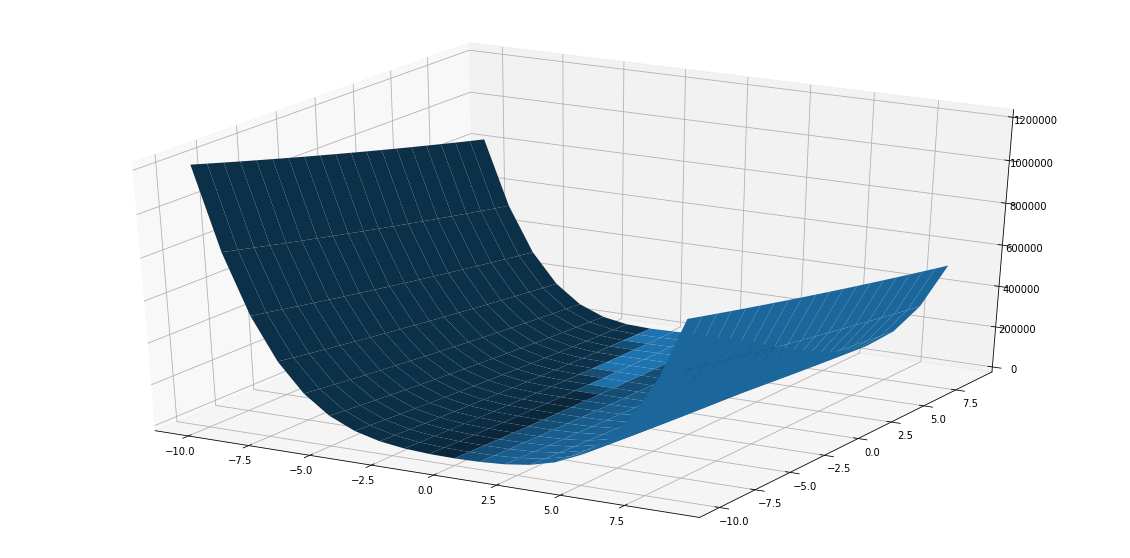

In [32]:
draw_function(x,y,f)